## **Problem Statement**
#### ***Business problem overview***<br>
In the telecom industry, customers are able to choose from multiple service providers and actively switch from one operator to another. In this highly competitive market, the telecommunications industry experiences an average of 15-25% annual churn rate. Given the fact that it costs 5-10 times more to acquire a new customer than to retain an existing one, **customer retention** has now become even more important than customer acquisition.

 

For many incumbent operators, retaining high profitable customers is the number one business goal.

 

To reduce customer churn, telecom companies need to **predict which customers are at high risk of churn.**

 

In this project, you will analyse customer-level data of a leading telecom firm, build predictive models to identify customers at high risk of churn and identify the main indicators of churn.

 

#### ***Understanding and defining churn***<br>
There are two main models of payment in the telecom industry - **`postpaid`** (customers pay a monthly/annual bill after using the services) and **`prepaid`** (customers pay/recharge with a certain amount in advance and then use the services).

 

In the postpaid model, when customers want to switch to another operator, they usually inform the existing operator to terminate the services, and you directly know that this is an instance of churn.

 

However, in the prepaid model, customers who want to switch to another network can simply stop using the services without any notice, and it is hard to know whether someone has actually churned or is simply not using the services temporarily (e.g. someone may be on a trip abroad for a month or two and then intend to resume using the services again).

 

Thus, churn prediction is usually more critical (and non-trivial) for prepaid customers, and the term ‘churn’ should be defined carefully.  Also, prepaid is the most common model in India and Southeast Asia, while postpaid is more common in Europe in North America.

 

*This project is based on the Indian and Southeast Asian market.*

 

#### ***Definitions of churn***<br>
There are various ways to define churn, such as:

**`Revenue-based churn`**: Customers who have not utilised any revenue-generating facilities such as mobile internet, outgoing calls, SMS etc. over a given period of time. One could also use aggregate metrics such as ‘customers who have generated less than INR 4 per month in total/average/median revenue’.

 

The main shortcoming of this definition is that there are customers who only receive calls/SMSes from their wage-earning counterparts, i.e. they don’t generate revenue but use the services. For example, many users in rural areas only receive calls from their wage-earning siblings in urban areas.

 

**`Usage-based churn`**: Customers who have not done any usage, either incoming or outgoing - in terms of calls, internet etc. over a period of time.

 

A potential shortcoming of this definition is that when the customer has stopped using the services for a while, it may be too late to take any corrective actions to retain them. For e.g., if you define churn based on a ‘two-months zero usage’ period, predicting churn could be useless since by that time the customer would have already switched to another operator.

 

In this project, you will use the **`usage-based definition`** to define churn.

 

#### ***High-value churn***<br>
In the Indian and the Southeast Asian market, approximately 80% of revenue comes from the top 20% customers (called high-value customers). Thus, if we can reduce churn of the high-value customers, we will be able to reduce significant revenue leakage.

 

In this project, you will define high-value customers based on a certain metric (mentioned later below) and predict churn only on high-value customers.

 

#### ***Understanding the business objective and the data***<br>
The dataset contains customer-level information for a span of four consecutive months - June, July, August and September. The months are encoded as 6, 7, 8 and 9, respectively. 


The business objective is to predict the churn in the last (i.e. the ninth) month using the data (features) from the first three months. To do this task well, understanding the typical customer behaviour during churn will be helpful.

 

#### ***Understanding customer behaviour during churn***
Customers usually do not decide to switch to another competitor instantly, but rather over a period of time (this is especially applicable to high-value customers). In churn prediction, we assume that there are **`three phases of customer lifecycle`** :

- The ***`‘good’`*** phase: In this phase, the customer is happy with the service and behaves as usual.

- The ***`‘action’`*** phase: The customer experience starts to sore in this phase, for e.g. he/she gets a compelling offer from a  competitor, faces unjust charges, becomes unhappy with service quality etc. In this phase, the customer usually shows different behaviour than the ‘good’ months. Also, it is crucial to identify high-churn-risk customers in this phase, since some corrective actions can be taken at this point (such as matching the competitor’s offer/improving the service quality etc.)

- The ***`‘churn’`*** phase: In this phase, the customer is said to have churned. You define churn based on this phase. Also, it is important to note that at the time of prediction (i.e. the action months), this data is not available to you for prediction. Thus, after **`tagging churn as 1/0 based on this phase`**, you discard all data corresponding to this phase.

 

In this case, since you are working over a four-month window, the first two months are the ‘good’ phase, the third month is the ‘action’ phase, while the fourth month is the ‘churn’ phase.


In [1]:
#Importing libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA, IncrementalPCA

# supress warnings that are generated by seaborn 
import warnings
warnings.filterwarnings('ignore')

# to display all Columns without restrictions
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', -1)

# 1. Data Reading and Understanding

In [2]:
# Reading the csv data file.
telecom_data = pd.read_csv("telecom_churn_data.csv")

# Displaying the first 10 field with all columns in the dataset
telecom_data.head(10)

mobile_number  circle_id  loc_og_t2o_mou  std_og_t2o_mou  loc_ic_t2o_mou  \
0  7000842753     109        0.0             0.0             0.0              
1  7001865778     109        0.0             0.0             0.0              
2  7001625959     109        0.0             0.0             0.0              
3  7001204172     109        0.0             0.0             0.0              
4  7000142493     109        0.0             0.0             0.0              
5  7000286308     109        0.0             0.0             0.0              
6  7001051193     109        0.0             0.0             0.0              
7  7000701601     109        0.0             0.0             0.0              
8  7001524846     109        0.0             0.0             0.0              
9  7001864400     109        0.0             0.0             0.0              

  last_date_of_month_6 last_date_of_month_7 last_date_of_month_8  \
0  6/30/2014            7/31/2014            8/31/2014             
1  6/30/2014            7/31/2014            8/31/2014             
2  6/30/2014            7/31/2014            8/31/2014             
3  6/30/2014            7/31/2014            8/31/2014             
4  6/30/2014            7/31/2014            8/31/2014             
5  6/30/2014            7/31/2014            8/31/2014             
6  6/30/2014            7/31/2014            8/31/2014             
7  6/30/2014            7/31/2014            8/31/2014             
8  6/30/2014            7/31/2014            8/31/2014             
9  6/30/2014            7/31/2014            8/31/2014             

  last_date_of_month_9    arpu_6    arpu_7    arpu_8   arpu_9  onnet_mou_6  \
0  9/30/2014            197.385   214.816   213.803   21.100  NaN            
1  9/30/2014            34.047    355.074   268.321   86.285   24.11         
2  9/30/2014            167.690   189.058   210.226   290.714  11.54         
3  9/30/2014            221.338   251.102   508.054   389.500  99.91         
4  9/30/2014            261.636   309.876   238.174   163.426  50.31         
5  9/30/2014            50.258    58.810    83.386    170.826  50.16         
6  9/30/2014            429.023   190.704   255.114   114.751  71.03         
7  9/30/2014            1069.180  1349.850  3171.480  500.000  57.84         
8  9/30/2014            378.721   492.223   137.362   166.787  413.69        
9  9/30/2014            119.518   247.435   170.231   160.042  33.89         

   onnet_mou_7  onnet_mou_8  onnet_mou_9  offnet_mou_6  offnet_mou_7  \
0 NaN           0.00        NaN          NaN           NaN             
1  78.68        7.68         18.34        15.74         99.84          
2  55.24        37.26        74.81        143.33        220.59         
3  54.39        310.98       241.71       123.31        109.01         
4  149.44       83.89        58.78        76.96         91.88          
5  43.63        85.48        138.79       19.28         13.44          
6  45.03        76.66        15.23        262.73        49.24          
7  54.68        52.29       NaN           453.43        567.16         
8  351.03       35.08        33.46        94.66         80.63          
9  30.11        22.43        27.84        63.48         54.16          

   offnet_mou_8  offnet_mou_9  roam_ic_mou_6  roam_ic_mou_7  roam_ic_mou_8  \
0  0.00         NaN           NaN            NaN             0.00            
1  304.76        53.76         0.00           0.00           0.00            
2  208.36        118.91        0.00           0.00           0.00            
3  71.68         113.54        0.00           54.86          44.38           
4  124.26        45.81         0.00           0.00           0.00            
5  14.46         46.91         0.00           0.00           0.00            
6  92.08         50.33         0.00           0.00           0.00            
7  325.91       NaN            16.23          33.49          31.64           
8  136.48        108.71       

In [3]:
# Checking the dimensions of the dataset
telecom_data.shape

(99999, 226)

##### This telecom dataset has 99999 rows and 226 columns

In [4]:
# check statistics for numerical columns
telecom_data.describe()

mobile_number  circle_id  loc_og_t2o_mou  std_og_t2o_mou  \
count  9.999900e+04   99999.0    98981.0         98981.0          
mean   7.001207e+09   109.0      0.0             0.0              
std    6.956694e+05   0.0        0.0             0.0              
min    7.000000e+09   109.0      0.0             0.0              
25%    7.000606e+09   109.0      0.0             0.0              
50%    7.001205e+09   109.0      0.0             0.0              
75%    7.001812e+09   109.0      0.0             0.0              
max    7.002411e+09   109.0      0.0             0.0              

       loc_ic_t2o_mou        arpu_6        arpu_7        arpu_8        arpu_9  \
count  98981.0         99999.000000  99999.000000  99999.000000  99999.000000   
mean   0.0             282.987358    278.536648    279.154731    261.645069     
std    0.0             328.439770    338.156291    344.474791    341.998630     
min    0.0            -2258.709000  -2014.045000  -945.808000   -1899.505000    
25%    0.0             93.411500     86.980500     84.126000     62.685000      
50%    0.0             197.704000    191.640000    192.080000    176.849000     
75%    0.0             371.060000    365.344500    369.370500    353.466500     
max    0.0             27731.088000  35145.834000  33543.624000  38805.617000   

        onnet_mou_6   onnet_mou_7   onnet_mou_8   onnet_mou_9  offnet_mou_6  \
count  96062.000000  96140.000000  94621.000000  92254.000000  96062.000000   
mean   132.395875    133.670805    133.018098    130.302327    197.935577     
std    297.207406    308.794148    308.951589    308.477668    316.851613     
min    0.000000      0.000000      0.000000      0.000000      0.000000       
25%    7.380000      6.660000      6.460000      5.330000      34.730000      
50%    34.310000     32.330000     32.360000     29.840000     96.310000      
75%    118.740000    115.595000    115.860000    112.130000    231.860000     
max    7376.710000   8157.780000   10752.560000  10427.460000  8362.360000    

       offnet_mou_7  offnet_mou_8  offnet_mou_9  roam_ic_mou_6  roam_ic_mou_7  \
count  96140.000000  94621.000000  92254.000000  96062.000000   96140.000000    
mean   197.045133    196.574803    190.337222    9.950013       7.149898        
std    325.862803    327.170662    319.396092    72.825411      73.447948       
min    0.000000      0.000000      0.000000      0.000000       0.000000        
25%    32.190000     31.630000     27.130000     0.000000       0.000000        
50%    91.735000     92.140000     87.290000     0.000000       0.000000        
75%    226.815000    228.260000    220.505000    0.000000       0.000000        
max    9667.130000   14007.340000  10310.760000  13724.380000   15371.040000    

       roam_ic_mou_8  roam_ic_mou_9  roam_og_mou_6  roam_og_mou_7  \
count  94621.000000   92254.000000   96062.000000   96140.000000    
mean   7.292981       6.343841       13.911337      9.818732        
std    68.402466      57.137537      71.443196      58.455762       
min    0.000000       0.000000       0.000000       0.000000        
25%    0.000000       0.000000       0.000000       0.000000        
50%    0.000000       0.000000       0.000000       0.000000        
75%    0.000000       0.000000       0.000000       0.000000        
max    13095.360000   8464.030000    3775.110000    2812.040000     

       roam_og_mou_8  roam_og_mou_9  loc_og_t2t_mou_6  loc_og_t2t_mou_7  \
count  94621.000000   92254.000000   96062.000000      96140.000000       
mean   9.971890       8.555519       47.100763         46.473010          
std    64.713221      58.438186      150.856393        155.318705         
min    0.000000       0.000000       0.000000          0.000000           
25%    0.000000       0.000000       1.660000          1.630000           
50%    0.000000       0.000000       11.910000         11.610000          
75%    0.000000       0.000000       40.960000         39.910000          
max    53

In [5]:
# Checking the informations regarding the dataset
telecom_data.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Data columns (total 226 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   mobile_number             int64  
 1   circle_id                 int64  
 2   loc_og_t2o_mou            float64
 3   std_og_t2o_mou            float64
 4   loc_ic_t2o_mou            float64
 5   last_date_of_month_6      object 
 6   last_date_of_month_7      object 
 7   last_date_of_month_8      object 
 8   last_date_of_month_9      object 
 9   arpu_6                    float64
 10  arpu_7                    float64
 11  arpu_8                    float64
 12  arpu_9                    float64
 13  onnet_mou_6               float64
 14  onnet_mou_7               float64
 15  onnet_mou_8               float64
 16  onnet_mou_9               float64
 17  offnet_mou_6              float64
 18  offnet_mou_7              float64
 19  offnet_mou_8              float64
 20  offnet_mou_9              f

# 2. Data Cleaning and Preparation

## 2.1 check the columns unique values

In [6]:
# lets check the columns unique values and drop columns which have only <2 unique values

unique_1_col=[]

for i in telecom_data.columns:
    if telecom_data[i].nunique() == 1:
        unique_1_col.append(i)
    else:
        pass

telecom_data.drop(unique_1_col, axis=1, inplace = True)
print("The following columns are dropped from the dataset as their unique value count is 1: ", unique_1_col)

The following columns are dropped from the dataset as their unique value count is 1:  ['circle_id', 'loc_og_t2o_mou', 'std_og_t2o_mou', 'loc_ic_t2o_mou', 'last_date_of_month_6', 'last_date_of_month_7', 'last_date_of_month_8', 'last_date_of_month_9', 'std_og_t2c_mou_6', 'std_og_t2c_mou_7', 'std_og_t2c_mou_8', 'std_og_t2c_mou_9', 'std_ic_t2o_mou_6', 'std_ic_t2o_mou_7', 'std_ic_t2o_mou_8', 'std_ic_t2o_mou_9']


## 2.2 Converting the selected columns to datetime format

In [7]:
# selecting all the columns with datetime format
date_col = telecom_data.select_dtypes(include=['object'])
print("\n Columns available with datetime format but actually are object: \n", date_col.columns)

# Converting the selected columns to datetime format
for i in date_col.columns:
    telecom_data[i] = pd.to_datetime(telecom_data[i])

# Current dimension of the dataset
telecom_data.shape


 Columns available with datetime format but actually are object: 
 Index(['date_of_last_rech_6', 'date_of_last_rech_7', 'date_of_last_rech_8',
       'date_of_last_rech_9', 'date_of_last_rech_data_6',
       'date_of_last_rech_data_7', 'date_of_last_rech_data_8',
       'date_of_last_rech_data_9'],
      dtype='object')


(99999, 210)

In [8]:
# confirming the conversion of dtype
telecom_data.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Data columns (total 210 columns):
 #   Column                    Dtype         
---  ------                    -----         
 0   mobile_number             int64         
 1   arpu_6                    float64       
 2   arpu_7                    float64       
 3   arpu_8                    float64       
 4   arpu_9                    float64       
 5   onnet_mou_6               float64       
 6   onnet_mou_7               float64       
 7   onnet_mou_8               float64       
 8   onnet_mou_9               float64       
 9   offnet_mou_6              float64       
 10  offnet_mou_7              float64       
 11  offnet_mou_8              float64       
 12  offnet_mou_9              float64       
 13  roam_ic_mou_6             float64       
 14  roam_ic_mou_7             float64       
 15  roam_ic_mou_8             float64       
 16  roam_ic_mou_9             float64       
 17  roam_og_mou

## 2.3 Handling missing values

In [9]:
# Checking the percentage missing values in the dataset
((telecom_data.isnull().sum()/telecom_data.shape[0])*100).round(2).sort_values(ascending = False)

night_pck_user_6            74.85
arpu_2g_6                   74.85
count_rech_3g_6             74.85
av_rech_amt_data_6          74.85
count_rech_2g_6             74.85
max_rech_data_6             74.85
fb_user_6                   74.85
date_of_last_rech_data_6    74.85
total_rech_data_6           74.85
arpu_3g_6                   74.85
night_pck_user_7            74.43
arpu_2g_7                   74.43
total_rech_data_7           74.43
arpu_3g_7                   74.43
max_rech_data_7             74.43
av_rech_amt_data_7          74.43
count_rech_3g_7             74.43
date_of_last_rech_data_7    74.43
count_rech_2g_7             74.43
fb_user_7                   74.43
date_of_last_rech_data_9    74.08
arpu_2g_9                   74.08
max_rech_data_9             74.08
count_rech_3g_9             74.08
fb_user_9                   74.08
av_rech_amt_data_9          74.08
total_rech_data_9           74.08
arpu_3g_9                   74.08
count_rech_2g_9             74.08
night_pck_user

### 2.3.1 Handling missing values of meaningful attribute column

In [10]:
# Handling missing values with respect to `data recharge` variables
telecom_data[['date_of_last_rech_data_6','total_rech_data_6','max_rech_data_6']].head(12)

date_of_last_rech_data_6  total_rech_data_6  max_rech_data_6
0  2014-06-21                1.0                252.0          
1  NaT                      NaN                NaN             
2  NaT                      NaN                NaN             
3  NaT                      NaN                NaN             
4  2014-06-04                1.0                56.0           
5  NaT                      NaN                NaN             
6  NaT                      NaN                NaN             
7  NaT                      NaN                NaN             
8  NaT                      NaN                NaN             
9  NaT                      NaN                NaN             
10 NaT                      NaN                NaN             
11 NaT                      NaN                NaN

* `date_of_last_rech_data` indicates the date of the last recharge made by the customer in any given month for mobile internet. We can say that the `total_rech_data` and the `max_rech_data` also have missing values, therefore the missing values in all the columns mentioned can be considered as meaningfully missing.<br> 
* So, we can impute them with 0.<br>
* Meaningfully missing in this case represents that the customer has not recharged their balance.

### 2.3.2 Handling the missing values for the attributes `total_rech_data_`, `max_rech_data_` and for month 6,7,8 and 9

In [11]:
# Code for conditional imputation

for i in range(len(telecom_data)):
  # Handling missing values for 'total_rech_data', 'max_rech_data' and for month 6
    if pd.isnull((telecom_data['total_rech_data_6'][i]) and (telecom_data['max_rech_data_6'][i])):
        if pd.isnull(telecom_data['date_of_last_rech_data_6'][i]):
            telecom_data['total_rech_data_6'][i]=0
            telecom_data['max_rech_data_6'][i]=0

  # Handling missing values for 'total_rech_data', 'max_rech_data' and for month 7
    if pd.isnull((telecom_data['total_rech_data_7'][i]) and (telecom_data['max_rech_data_7'][i])):
        if pd.isnull(telecom_data['date_of_last_rech_data_7'][i]):
            telecom_data['total_rech_data_7'][i]=0
            telecom_data['max_rech_data_7'][i]=0

  # Handling missing values for 'total_rech_data', 'max_rech_data' and for month 8
    if pd.isnull((telecom_data['total_rech_data_8'][i]) and (telecom_data['max_rech_data_8'][i])):
        if pd.isnull(telecom_data['date_of_last_rech_data_8'][i]):
            telecom_data['total_rech_data_8'][i]=0
            telecom_data['max_rech_data_8'][i]=0

  # Handling missing values for 'total_rech_data', 'max_rech_data' and for month 9
    if pd.isnull((telecom_data['total_rech_data_9'][i]) and (telecom_data['max_rech_data_9'][i])):
        if pd.isnull(telecom_data['date_of_last_rech_data_9'][i]):
            telecom_data['total_rech_data_9'][i]=0
            telecom_data['max_rech_data_9'][i]=0

print("The columns \n'total_rech_data_6','total_rech_data_7','total_rech_data_8','total_rech_data_9'\n'max_rech_data_6','max_rech_data_7','max_rech_data_8','max_rech_data_9' are imputed with 0")

The columns 
'total_rech_data_6','total_rech_data_7','total_rech_data_8','total_rech_data_9'
'max_rech_data_6','max_rech_data_7','max_rech_data_8','max_rech_data_9' are imputed with 0


### 2.3.3 Handling the missing values for the attributes `count_rech_2g_`,`count_rech_3g_` for month 6 ,7, 8 and 9

In [12]:
# Checking the related columns values
telecom_data[['count_rech_2g_6','count_rech_3g_6','total_rech_data_6']].head(12)

count_rech_2g_6  count_rech_3g_6  total_rech_data_6
0   0.0              1.0              1.0              
1  NaN              NaN               0.0              
2  NaN              NaN               0.0              
3  NaN              NaN               0.0              
4   1.0              0.0              1.0              
5  NaN              NaN               0.0              
6  NaN              NaN               0.0              
7  NaN              NaN               0.0              
8  NaN              NaN               0.0              
9  NaN              NaN               0.0              
10 NaN              NaN               0.0              
11 NaN              NaN               0.0

* From the above tablular the column values of `total_rech_data` for each month from 6 to 9 respectively is the sum of the columns values of `count_rech_2g` for each month from 6 to 9 respectively and `count_rech_3g` for each month from 6 to 9 respectively, which derives to a multicollinearity issue. In order to reduce the multicollinearity, we can drop the columns `count_rech_2g` for each month from 6 to 9 respectively and `count_rech_3g` for each month from 6 to 9 respectively. *

In [13]:
# Dropping the columns 'count_rech_2g_*' & 'count_rech_3g_*' for the months 6,7,8 and 9 
telecom_data.drop(['count_rech_2g_6','count_rech_3g_6',
                   'count_rech_2g_7','count_rech_3g_7',
                   'count_rech_2g_8','count_rech_3g_8',
                   'count_rech_2g_9','count_rech_3g_9'],axis=1, inplace=True)

print("The 'count_rech_2g_6','count_rech_3g_6','count_rech_2g_7','count_rech_3g_7','count_rech_2g_8','count_rech_3g_8','count_rech_2g_9','count_rech_3g_9' columns are dropped as they can be explained from the 'total_rech_data'column")

The 'count_rech_2g_6','count_rech_3g_6','count_rech_2g_7','count_rech_3g_7','count_rech_2g_8','count_rech_3g_8','count_rech_2g_9','count_rech_3g_9' columns are dropped as they can be explained from the 'total_rech_data'column


In [14]:
# The curent dimensions of the dataset
telecom_data.shape

(99999, 202)

### 2.3.4 Handling the missing values for the attributes `arpu_3g_`,`arpu_2g_` for month 6, 7, 8 and 9

In [15]:
# Checking the related columns values
telecom_data[['arpu_3g_6','arpu_2g_6','av_rech_amt_data_6']].head(12)

arpu_3g_6  arpu_2g_6  av_rech_amt_data_6
0   212.17     212.17     252.0             
1  NaN        NaN        NaN                
2  NaN        NaN        NaN                
3  NaN        NaN        NaN                
4   0.00       0.00       56.0              
5  NaN        NaN        NaN                
6  NaN        NaN        NaN                
7  NaN        NaN        NaN                
8  NaN        NaN        NaN                
9  NaN        NaN        NaN                
10 NaN        NaN        NaN                
11 NaN        NaN        NaN

In [16]:
# Checking the correlation between the above mentioned columns in tabular for months 6,7,8 and 9

print("Correlation table for month 6\n\n", telecom_data[['arpu_3g_6','arpu_2g_6','av_rech_amt_data_6']].corr())
print("\nCorrelation table for month 7\n\n", telecom_data[['arpu_3g_7','arpu_2g_7','av_rech_amt_data_7']].corr())
print("\nCorrelation table for month 8\n\n", telecom_data[['arpu_3g_8','arpu_2g_8','av_rech_amt_data_8']].corr())
print("\nCorrelation table for month 9\n\n", telecom_data[['arpu_3g_9','arpu_2g_9','av_rech_amt_data_9']].corr())

Correlation table for month 6

                     arpu_3g_6  arpu_2g_6  av_rech_amt_data_6
arpu_3g_6           1.000000   0.932232   0.809695          
arpu_2g_6           0.932232   1.000000   0.834065          
av_rech_amt_data_6  0.809695   0.834065   1.000000          

Correlation table for month 7

                     arpu_3g_7  arpu_2g_7  av_rech_amt_data_7
arpu_3g_7           1.000000   0.930366   0.796131          
arpu_2g_7           0.930366   1.000000   0.815933          
av_rech_amt_data_7  0.796131   0.815933   1.000000          

Correlation table for month 8

                     arpu_3g_8  arpu_2g_8  av_rech_amt_data_8
arpu_3g_8           1.000000   0.924925   0.787165          
arpu_2g_8           0.924925   1.000000   0.805482          
av_rech_amt_data_8  0.787165   0.805482   1.000000          

Correlation table for month 9

                     arpu_3g_9  arpu_2g_9  av_rech_amt_data_9
arpu_3g_9           1.000000   0.852253   0.722932          
arpu_2g_9      

From the above correlation table between attributes `arpu_2g_` and `arpu_3g_` (for each month from 6 to 9 respectively) are highly correlated to the attribute `av_rech_amt_data_` for each month from 6 to 9 respectively.

Since they are highly correlated, it is better to drop `arpu_2g_` and `arpu_3g_`.

In [17]:
# Dropping the columns 'arpu_3g_*'&'arpu_2g_*' in month 6,7,8 and 9 datafrom the dataset due to high correlation

telecom_data.drop(['arpu_3g_6','arpu_2g_6',
                  'arpu_3g_7','arpu_2g_7',
                  'arpu_3g_8','arpu_2g_8',
                  'arpu_3g_9','arpu_2g_9'], axis = 1, inplace = True)

print("\nThe columns'arpu_3g_6','arpu_2g_6','arpu_3g_7','arpu_2g_7','arpu_3g_8','arpu_2g_8','arpu_3g_9','arpu_2g_9' are dropped from the dataset\n")


The columns'arpu_3g_6','arpu_2g_6','arpu_3g_7','arpu_2g_7','arpu_3g_8','arpu_2g_8','arpu_3g_9','arpu_2g_9' are dropped from the dataset



In [18]:
# The curent dimensions of the dataset

telecom_data.shape

(99999, 194)

### 2.3.5 Handling the other attributes with higher missing value percentage

The column `fb_user_` and `night_pck_user_` for each month from 6 to 9 respectively has a missing values above 50% and does not seem to add any information to understand the data. Hence we can drop these columns for further analysis.

In [19]:
telecom_data.drop(['fb_user_6','fb_user_7','fb_user_8','fb_user_9', 'night_pck_user_6','night_pck_user_7','night_pck_user_8','night_pck_user_9'],
                  axis = 1, inplace = True)

print("\nThe columns 'fb_user_6','fb_user_7','fb_user_8','fb_user_9','night_pck_user_6','night_pck_user_7','night_pck_user_8','night_pck_user_9' are dropped from the dataset\n")


The columns 'fb_user_6','fb_user_7','fb_user_8','fb_user_9','night_pck_user_6','night_pck_user_7','night_pck_user_8','night_pck_user_9' are dropped from the dataset



In [20]:
# The curent dimensions of the dataset

telecom_data.shape

(99999, 186)

### 2.3.6 Handling the missing values for the attributes `av_rech_amt_data_` for month 6, 7, 8 and 9

In [21]:
# Checking the related columns values

telecom_data[['av_rech_amt_data_7','max_rech_data_7','total_rech_data_7']].head(12)

av_rech_amt_data_7  max_rech_data_7  total_rech_data_7
0   252.0               252.0            1.0              
1   154.0               154.0            1.0              
2  NaN                  0.0              0.0              
3  NaN                  0.0              0.0              
4  NaN                  0.0              0.0              
5  NaN                  0.0              0.0              
6  NaN                  0.0              0.0              
7  NaN                  0.0              0.0              
8   177.0               154.0            2.0              
9   154.0               154.0            1.0              
10 NaN                  0.0              0.0              
11 NaN                  0.0              0.0

From the above table, it can be seen that the missing values for the column `av_rech_amt_data_` (for months from 6 to 9) can be replaced with 0 if the `total_rech_data_` (for months from 6 to 9) is 0. In other words, if the total recharge done is 0 then the average recharge amount will also be 0.

In [22]:
# Code for conditional imputation

for i in range(len(telecom_data)):
  # Handling missing values for `av_rech_amt_data`  for month 6
    if (pd.isnull(telecom_data['av_rech_amt_data_6'][i]) and (telecom_data['total_rech_data_6'][i] == 0)):
        telecom_data['av_rech_amt_data_6'][i] = 0

  # Handling missing values for `av_rech_amt_data`  for month 7
    if (pd.isnull(telecom_data['av_rech_amt_data_7'][i]) and (telecom_data['total_rech_data_7'][i] == 0)):
        telecom_data['av_rech_amt_data_7'][i] = 0

  # Handling missing values for `av_rech_amt_data`  for month 8
    if (pd.isnull(telecom_data['av_rech_amt_data_8'][i]) and (telecom_data['total_rech_data_8'][i] == 0)):
        telecom_data['av_rech_amt_data_8'][i] = 0

  # Handling missing values for `av_rech_amt_data`  for month 9
    if (pd.isnull(telecom_data['av_rech_amt_data_9'][i]) and (telecom_data['total_rech_data_9'][i] == 0)):
        telecom_data['av_rech_amt_data_9'][i] = 0


print("\n The columns 'av_rech_amt_data_6','av_rech_amt_data_7','av_rech_amt_data_8' and 'av_rech_amt_data_9' are imputed with 0 \n")


 The columns 'av_rech_amt_data_6','av_rech_amt_data_7','av_rech_amt_data_8' and 'av_rech_amt_data_9' are imputed with 0 



In [23]:
# Checking missing values in the dataset after imputation
((telecom_data.isnull().sum()/telecom_data.shape[0])*100).round(2).sort_values(ascending = False)

date_of_last_rech_data_6    74.85
date_of_last_rech_data_7    74.43
date_of_last_rech_data_9    74.08
date_of_last_rech_data_8    73.66
std_ic_t2t_mou_9            7.75 
loc_og_t2f_mou_9            7.75 
std_ic_t2f_mou_9            7.75 
loc_og_t2t_mou_9            7.75 
std_ic_mou_9                7.75 
std_og_mou_9                7.75 
loc_og_t2m_mou_9            7.75 
spl_ic_mou_9                7.75 
ic_others_9                 7.75 
isd_ic_mou_9                7.75 
std_ic_t2m_mou_9            7.75 
loc_og_t2c_mou_9            7.75 
std_og_t2f_mou_9            7.75 
std_og_t2m_mou_9            7.75 
loc_og_mou_9                7.75 
roam_og_mou_9               7.75 
std_og_t2t_mou_9            7.75 
spl_og_mou_9                7.75 
loc_ic_mou_9                7.75 
loc_ic_t2m_mou_9            7.75 
loc_ic_t2t_mou_9            7.75 
loc_ic_t2f_mou_9            7.75 
offnet_mou_9                7.75 
onnet_mou_9                 7.75 
og_others_9                 7.75 
roam_ic_mou_9 

We can see we still columns with high missing values.

In [24]:
telecom_data.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Data columns (total 186 columns):
 #   Column                    Dtype         
---  ------                    -----         
 0   mobile_number             int64         
 1   arpu_6                    float64       
 2   arpu_7                    float64       
 3   arpu_8                    float64       
 4   arpu_9                    float64       
 5   onnet_mou_6               float64       
 6   onnet_mou_7               float64       
 7   onnet_mou_8               float64       
 8   onnet_mou_9               float64       
 9   offnet_mou_6              float64       
 10  offnet_mou_7              float64       
 11  offnet_mou_8              float64       
 12  offnet_mou_9              float64       
 13  roam_ic_mou_6             float64       
 14  roam_ic_mou_7             float64       
 15  roam_ic_mou_8             float64       
 16  roam_ic_mou_9             float64       
 17  roam_og_mou

We can conclude, the column `date_of_last_rech_data` corresponding to months 6, 7, 8 and 9 are of no significance after the conditional imputation of columns `total_rech_data_*`,` max_rech_data_*`.

Also the missing value percentage is high for these columns (>50%) and can be safely dropped from the dataset.

In [25]:
# Dropping the columns related to datetime datatype from the dataset as it has no significance

telecom_data.drop(["date_of_last_rech_data_6","date_of_last_rech_data_7", "date_of_last_rech_data_8","date_of_last_rech_data_9"], axis = 1, inplace = True)

print("\nThe columns 'date_of_last_rech_data_6','date_of_last_rech_data_7','date_of_last_rech_data_8','date_of_last_rech_data_9' have been dropped\n")


The columns 'date_of_last_rech_data_6','date_of_last_rech_data_7','date_of_last_rech_data_8','date_of_last_rech_data_9' have been dropped



With the above dropping of columns, we can no more utilise the datetime columns. Therefore, we can drop the `date_of_last_rech_data_` column corresponding to months 6, 7, 8 and 9 respectively

In [26]:
# Dropping the columns related to datetime dtype from the dataset as it has no significance

telecom_data.drop(["date_of_last_rech_6","date_of_last_rech_7", "date_of_last_rech_8","date_of_last_rech_9"], axis = 1, inplace = True)
print("\nThe columns 'date_of_last_rech_6','date_of_last_rech_7','date_of_last_rech_8','date_of_last_rech_9' are dropped \n")


The columns 'date_of_last_rech_6','date_of_last_rech_7','date_of_last_rech_8','date_of_last_rech_9' are dropped 



In [27]:
# The curent dimensions of the dataset
telecom_data.shape

(99999, 178)

**Since the columns used to determine the High Value Customer is clear of null values, we can filter the overall data and then handle the remaining missing values for each column**

## 2.4 Filtering high value customers from the good phase (months: 6 and 7)

In [28]:
#Filtering the high value cuustomers (in accordance with total revenue generated per customer)

#Calculating the total recharge amount done for data alone in months 6,7,8 and 9
telecom_data['total_rech_amt_data_6'] = telecom_data['av_rech_amt_data_6'] * telecom_data['total_rech_data_6']
telecom_data['total_rech_amt_data_7'] = telecom_data['av_rech_amt_data_7'] * telecom_data['total_rech_data_7']

#Calculating the overall recharge amount for the months 6,7,8 and 9
telecom_data['overall_rech_amt_6'] = telecom_data['total_rech_amt_data_6'] + telecom_data['total_rech_amt_6']
telecom_data['overall_rech_amt_7'] = telecom_data['total_rech_amt_data_7'] + telecom_data['total_rech_amt_7']

#Calculating the average recharge done per customer in months June and July (6th and 7th month)
telecom_data['avg_rech_amt_6_7'] = (telecom_data['overall_rech_amt_6'] + telecom_data['overall_rech_amt_7'])/2

#Finding the value of 70th percentage as per revenue generated (per customer)
#This will help us in finding high value customers
cut_off = telecom_data['avg_rech_amt_6_7'].quantile(0.70)

print("\n The 70th quantile value is: ", cut_off, "\n")

# Filtering the data to the top 30% considered as High Value Customer
telecom_data = telecom_data[telecom_data['avg_rech_amt_6_7'] >= cut_off]


 The 70th quantile value is:  478.0 



In [29]:
# The curent dimension of the dataset
telecom_data.shape

(30001, 183)

According to the updated dataset, we have a total of 30k customers who are viewed as high value customers by the company.

In [30]:
# Checking the missing values percentages again for the high value customer group
((telecom_data.isnull().sum()/telecom_data.shape[0])*100).round(2).sort_values(ascending = False)

og_others_9              6.34
ic_others_9              6.34
std_ic_mou_9             6.34
spl_og_mou_9             6.34
loc_og_t2t_mou_9         6.34
spl_ic_mou_9             6.34
isd_ic_mou_9             6.34
loc_og_t2m_mou_9         6.34
isd_og_mou_9             6.34
roam_ic_mou_9            6.34
loc_og_t2f_mou_9         6.34
std_og_mou_9             6.34
std_og_t2f_mou_9         6.34
loc_og_t2c_mou_9         6.34
std_og_t2m_mou_9         6.34
loc_og_mou_9             6.34
std_ic_t2f_mou_9         6.34
roam_og_mou_9            6.34
std_og_t2t_mou_9         6.34
std_ic_t2m_mou_9         6.34
offnet_mou_9             6.34
std_ic_t2t_mou_9         6.34
loc_ic_t2t_mou_9         6.34
loc_ic_mou_9             6.34
loc_ic_t2m_mou_9         6.34
onnet_mou_9              6.34
loc_ic_t2f_mou_9         6.34
isd_og_mou_8             3.91
og_others_8              3.91
std_og_t2m_mou_8         3.91
loc_ic_t2t_mou_8         3.91
std_og_t2f_mou_8         3.91
loc_ic_t2m_mou_8         3.91
std_ic_t2f

**The remaining attributes with missing value can be imputed using an imputation technique called `KNNImputer`**

In [31]:
# filtering all the numerical columns
num_col = telecom_data.select_dtypes(include = ['int64','float64']).columns.tolist()

In [32]:
# Importing the libraries for Scaling and Imputation
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler

# Calling the Scaling function
scalar = MinMaxScaler()

# Scaling and transforming the data for the columns that are numerical
telecom_data[num_col] = scalar.fit_transform(telecom_data[num_col])

# Calling the KNN Imputer function
knn = KNNImputer(n_neighbors = 3) #default is 5. It is the number of neighboring samples to use for imputation. As the dataset 
#is huge, we are using only 3 samples

# Imputing the NaN values using KNN Imputer
telecom_data_knn = pd.DataFrame(knn.fit_transform(telecom_data[num_col]))
telecom_data_knn.columns=telecom_data[num_col].columns

In [33]:
# check for any null values after imputation for numerical columns
telecom_data_knn.isnull().sum().sum()

0

We can see that the KNN Imputer has replaced all the null values in the numerical columns using K-means algorithm perfectly.

In [34]:
#Since we scaled the numerical columns for the purpose of handling the null values, 
#we can restore the scaled values to their original form

# Converting the scaled data back to the original data
telecom_data[num_col] = scalar.inverse_transform(telecom_data_knn)

# Checking the top 10 data
telecom_data.head(10)

mobile_number    arpu_6    arpu_7    arpu_8    arpu_9  onnet_mou_6  \
0   7.000843e+09   197.385   214.816   213.803   21.100    53.27         
7   7.000702e+09   1069.180  1349.850  3171.480  500.000   57.84         
8   7.001525e+09   378.721   492.223   137.362   166.787   413.69        
21  7.002124e+09   514.453   597.753   637.760   578.596   102.41        
23  7.000887e+09   74.350    193.897   366.966   811.480   48.96         
33  7.000150e+09   977.020   2362.833  409.230   799.356   0.00          
38  7.000815e+09   363.987   486.558   393.909   391.709   248.99        
41  7.000721e+09   482.832   425.764   229.769   143.596   86.39         
48  7.000294e+09   1873.271  575.927   179.218   1189.744  2061.69       
53  7.002189e+09   978.077   1141.296  706.020   1076.247  135.14        

    onnet_mou_7  onnet_mou_8  onnet_mou_9  offnet_mou_6  offnet_mou_7  \
0   24.613333    0.00         33.590000    84.23         23.993333      
7   54.680000    52.29        65.276667    453.43        567.160000     
8   351.030000   35.08        33.460000    94.66         80.630000      
21  132.110000   85.14        161.630000   757.93        896.680000     
23  50.660000    33.58        15.740000    85.41         89.360000      
33  0.000000     0.00         0.000000     0.00          0.000000       
38  619.960000   666.38       494.790000   88.86         50.580000      
41  118.880000   80.44        40.060000    232.36        280.780000     
48  881.430000   156.91       1589.230000  1087.76       258.290000     
53  119.590000   102.69       99.830000    479.31        543.180000     

    offnet_mou_8  offnet_mou_9  roam_ic_mou_6  roam_ic_mou_7  roam_ic_mou_8  \
0   0.00          27.833333     0.00           0.00           0.00            
7   325.91        172.050000    16.23          33.49          31.64           
8   136.48        108.710000    0.00           0.00           0.00            
21  983.39        869.890000    0.00           0.00           0.00            
23  205.89        111.880000    0.00           0.00           0.00            
33  0.00          0.000000      0.00           0.00           0.00            
38  97.81         213.240000    0.00           0.00           0.00            
41  136.69        49.060000     0.00           0.00           0.00            
48  68.18         728.410000    0.00           0.00           0.00            
53  261.34        403.230000    0.00           0.00           0.00            

    roam_ic_mou_9  roam_og_mou_6  roam_og_mou_7  roam_og_mou_8  roam_og_mou_9  \
0   0.000000       0.00           0.00           0.00           0.000000        
7   4.776667       23.74          12.59          38.06          7.876667        
8   0.000000       0.00           0.00           0.00           0.000000        
21  0.000000       0.00           0.00           0.00           0.000000        
23  0.000000       0.00           0.00           0.00           0.000000        
33  0.000000       0.00           0.00           0.00           0.000000        
38  0.000000       0.00           0.00           0.00           0.000000        
41  0.000000       0.00           0.00           0.00           0.000000        
48  0.000000       0.00           0.00           0.00           0.000000        
53  0.000000       0.00           0.00           0.00           0.000000        

    loc_og_t2t_mou_6  loc_og_t2t_mou_7  loc_og_t2t_mou_8  loc_og_t2t_mou_9  \
0   53.27             24.613333         0.00              33.206667          
7   51.39             31.380000         40.28             43.380000          
8   297.13            217.590000        12.49             26.130000          
21  4.48              6.160000          23.34             29.980000          
23  48.96             50.660000         33.58             15.740000          
33  0.00              0.000000          0.00              0.000000           
38  29.88             17.330000         9.48              16.390000          

In [35]:
# Checking the overall missing values in the dataset
((telecom_data.isnull().sum()/telecom_data.shape[0])*100).round(2).sort_values(ascending=False)

avg_rech_amt_6_7         0.0
og_others_8              0.0
og_others_6              0.0
spl_og_mou_9             0.0
spl_og_mou_8             0.0
spl_og_mou_7             0.0
spl_og_mou_6             0.0
isd_og_mou_9             0.0
isd_og_mou_8             0.0
isd_og_mou_7             0.0
isd_og_mou_6             0.0
std_og_mou_9             0.0
std_og_mou_8             0.0
std_og_mou_7             0.0
std_og_mou_6             0.0
std_og_t2f_mou_9         0.0
std_og_t2f_mou_8         0.0
std_og_t2f_mou_7         0.0
std_og_t2f_mou_6         0.0
std_og_t2m_mou_9         0.0
std_og_t2m_mou_8         0.0
og_others_7              0.0
og_others_9              0.0
std_og_t2m_mou_6         0.0
total_og_mou_6           0.0
loc_ic_mou_9             0.0
loc_ic_mou_8             0.0
loc_ic_mou_7             0.0
loc_ic_mou_6             0.0
loc_ic_t2f_mou_9         0.0
loc_ic_t2f_mou_8         0.0
loc_ic_t2f_mou_7         0.0
loc_ic_t2f_mou_6         0.0
loc_ic_t2m_mou_9         0.0
loc_ic_t2m_mou

In [36]:
# Reconfirming for missing values if any
telecom_data.isnull().sum().sum()

0

## 2.5 Deriving new features

In [37]:
#creating new, useful variables and keeping with the dataset's naming conventions

telecom_data['diff_ic_og_6'] = telecom_data['total_ic_mou_6'] - telecom_data['total_og_mou_6'] #difference in minutes of usage of total incoming and outgoing calls for the 6th month
telecom_data['diff_ic_og_7'] = telecom_data['total_ic_mou_7'] - telecom_data['total_og_mou_7'] #difference in minutes of usage of total incoming and outgoing calls for the 7th month
telecom_data['diff_ic_og_8'] = telecom_data['total_ic_mou_8'] - telecom_data['total_og_mou_8'] #difference in minutes of usage of total incoming and outgoing calls for the 8th month
telecom_data['diff_ic_og_9'] = telecom_data['total_ic_mou_9'] - telecom_data['total_og_mou_9'] #difference in minutes of usage of total incoming and outgoing calls for the 9th month

telecom_data['diff_vol_3g_2g_6'] = telecom_data['vol_3g_mb_6'] - telecom_data['vol_2g_mb_6'] #difference in volume of usage between 3G and 2G data (month 6)
telecom_data['diff_vol_3g_2g_7'] = telecom_data['vol_3g_mb_7'] - telecom_data['vol_2g_mb_7'] #difference in volume of usage between 3G and 2G data (month 7)
telecom_data['diff_vol_3g_2g_8'] = telecom_data['vol_3g_mb_8'] - telecom_data['vol_2g_mb_8'] #difference in volume of usage between 3G and 2G data (month 8)
telecom_data['diff_vol_3g_2g_9'] = telecom_data['vol_3g_mb_9'] - telecom_data['vol_2g_mb_9'] #difference in volume of usage between 3G and 2G data (month 9)

telecom_data['diff_ic_good_active_phase'] = telecom_data['total_ic_mou_6'] + telecom_data['total_ic_mou_7'] - telecom_data['total_ic_mou_8'] #difference in incoming calls of the good and active phases 
telecom_data['diff_og_good_active_phase'] = telecom_data['total_og_mou_6'] + telecom_data['total_og_mou_7'] - telecom_data['total_og_mou_8'] #difference in outgoing calls of the good and active phases
telecom_data['diff_2g_good_active_phase'] = telecom_data['vol_2g_mb_6'] + telecom_data['vol_2g_mb_7'] - telecom_data['vol_2g_mb_8'] #difference in volume of 2G services of the good and active phases
telecom_data['diff_3g_good_active_phase'] = telecom_data['vol_3g_mb_6'] + telecom_data['vol_3g_mb_7'] - telecom_data['vol_3g_mb_8'] #difference in volume of 3G services of the good and active phases

telecom_data['diff_total_rech_amt_good_active'] = telecom_data['total_rech_amt_6']+telecom_data['total_rech_amt_7']-telecom_data['total_rech_amt_8'] #difference in total recharge amount of the good and active phases

## 2.6 Tagging customers with churn (1) or no-churn (0) (Our target variable)

In [38]:
telecom_data['churn'] = telecom_data['total_ic_mou_9'] + telecom_data['total_og_mou_9'] + telecom_data['vol_2g_mb_9'] + telecom_data['vol_3g_mb_9']
telecom_data['churn'] = telecom_data['churn'].apply(lambda x: 1 if x == 0 else 0)

In [39]:
telecom_data.churn.value_counts()

0    27560
1    2441 
Name: churn, dtype: int64

After applying mapping, we have 2441 customers marked as churned

In [40]:
#finding out the customers without any churn data
customers_without_churn_data = [x for x in telecom_data.columns if '_9' not in x and 'sep' not in x]

In [41]:
customers_without_churn_data

['mobile_number',
 'arpu_6',
 'arpu_7',
 'arpu_8',
 'onnet_mou_6',
 'onnet_mou_7',
 'onnet_mou_8',
 'offnet_mou_6',
 'offnet_mou_7',
 'offnet_mou_8',
 'roam_ic_mou_6',
 'roam_ic_mou_7',
 'roam_ic_mou_8',
 'roam_og_mou_6',
 'roam_og_mou_7',
 'roam_og_mou_8',
 'loc_og_t2t_mou_6',
 'loc_og_t2t_mou_7',
 'loc_og_t2t_mou_8',
 'loc_og_t2m_mou_6',
 'loc_og_t2m_mou_7',
 'loc_og_t2m_mou_8',
 'loc_og_t2f_mou_6',
 'loc_og_t2f_mou_7',
 'loc_og_t2f_mou_8',
 'loc_og_t2c_mou_6',
 'loc_og_t2c_mou_7',
 'loc_og_t2c_mou_8',
 'loc_og_mou_6',
 'loc_og_mou_7',
 'loc_og_mou_8',
 'std_og_t2t_mou_6',
 'std_og_t2t_mou_7',
 'std_og_t2t_mou_8',
 'std_og_t2m_mou_6',
 'std_og_t2m_mou_7',
 'std_og_t2m_mou_8',
 'std_og_t2f_mou_6',
 'std_og_t2f_mou_7',
 'std_og_t2f_mou_8',
 'std_og_mou_6',
 'std_og_mou_7',
 'std_og_mou_8',
 'isd_og_mou_6',
 'isd_og_mou_7',
 'isd_og_mou_8',
 'spl_og_mou_6',
 'spl_og_mou_7',
 'spl_og_mou_8',
 'og_others_6',
 'og_others_7',
 'og_others_8',
 'total_og_mou_6',
 'total_og_mou_7',
 'total_og_

In [42]:
telecom_data = telecom_data[customers_without_churn_data]

In [43]:
telecom_data.shape

(30001, 151)

## 2.7 Checking for duplicates

In [44]:
print(any(telecom_data['mobile_number'].duplicated())) 

False


We can see that there are no duplicate data to be found in the dataset

## 2.8 Checking for outliers

In [45]:
all_columns = telecom_data.columns
date_columns = [x for x in all_columns if 'date' in x] #columns that have dates
numeric_columns = [x for x in all_columns if x not in date_columns] #numerical columns

In [46]:
# Checking for outliers in the continuous variables
num_df = telecom_data[[x for x in telecom_data.columns if x not in date_columns]]

In [47]:
#Creating percentiles
num_df.describe(percentiles = [0.25, 0.5, 0.75, 0.90, 0.95, 0.99])

mobile_number        arpu_6        arpu_7        arpu_8   onnet_mou_6  \
count  3.000100e+04   30001.000000  30001.000000  30001.000000  30001.000000   
mean   7.001206e+09   558.490824    560.782203    508.597957    262.072836     
std    6.908784e+05   460.640461    479.776947    501.961981    459.701530     
min    7.000000e+09  -2258.709000  -2014.045000  -945.808000    0.000000       
25%    7.000609e+09   309.865000    309.826000    231.473000    18.540000      
50%    7.001203e+09   481.694000    480.943000    427.585000    85.880000      
75%    7.001804e+09   699.943000    698.315000    661.491000    291.760000     
90%    7.002165e+09   994.099000    995.859000    977.345000    755.060000     
95%    7.002285e+09   1240.964000   1261.272000   1255.019000   1135.760000    
99%    7.002386e+09   1985.115000   1999.500000   1986.622000   2157.580000    
max    7.002411e+09   27731.088000  35145.834000  33543.624000  7376.710000    

        onnet_mou_7   onnet_mou_8  offnet_mou_6  offnet_mou_7  offnet_mou_8  \
count  30001.000000  30001.000000  30001.000000  30001.000000  30001.000000   
mean   268.587256    236.153697    375.749296    379.768821    338.698012     
std    479.726631    457.950169    481.630184    498.095471    480.486293     
min    0.000000      0.000000      0.000000      0.000000      0.000000       
25%    17.290000     13.230000     75.340000     72.780000     54.260000      
50%    84.140000     68.480000     224.190000    221.530000    186.310000     
75%    290.630000    242.590000    488.890000    494.230000    440.290000     
90%    784.690000    666.280000    896.590000    916.240000    824.010000     
95%    1186.510000   1074.980000   1256.630000   1272.640000   1167.740000    
99%    2201.960000   2159.110000   2326.360000   2410.890000   2193.130000    
max    8157.780000   10752.560000  8362.360000   9667.130000   14007.340000   

       roam_ic_mou_6  roam_ic_mou_7  roam_ic_mou_8  roam_og_mou_6  \
count  30001.000000   30001.000000   30001.000000   30001.000000    
mean   16.398485      12.857273      12.904151      26.934779       
std    76.738770      76.095190      74.695595      116.449103      
min    0.000000       0.000000       0.000000       0.000000        
25%    0.000000       0.000000       0.000000       0.000000        
50%    0.000000       0.000000       0.000000       0.000000        
75%    0.000000       0.000000       0.000000       0.000000        
90%    28.610000      15.040000      16.840000      52.090000       
95%    86.810000      56.940000      58.160000      147.410000      
99%    347.280000     283.790000     285.710000     532.040000      
max    2613.310000    3813.290000    4169.810000    3775.110000     

       roam_og_mou_7  roam_og_mou_8  loc_og_t2t_mou_6  loc_og_t2t_mou_7  \
count  30001.000000   30001.000000   30001.000000      30001.000000       
mean   20.433422      20.403868      84.842095         86.009183          
std    96.238871      104.973939     228.719726        240.469391         
min    0.000000       0.000000       0.000000          0.000000           
25%    0.000000       0.000000       4.940000          5.110000           
50%    0.000000       0.000000       24.880000         25.080000          
75%    0.000000       0.000000       78.390000         78.780000          
90%    32.840000      32.210000      188.260000        191.190000         
95%    107.330000     103.710000     322.740000        324.540000         
99%    438.590000     427.710000     1006.360000       1018.530000        
max    2812.040000    5337.040000    6431.330000       7400.660000        

       loc_og_t2t_mou_8  loc_og_t2m_mou_6  loc_og_t2m_mou_7  loc_og_t2m_mou_8  \
count  30001.000000      30001.000000      30001.000000      30001.000000       
mean   78.787985         164.141722        163.847293        153.513156         
std    227.323078        249.759583        241.249556        233.171374         
min    0.000000          0.000000          

We can see outliers in our data. We will treat these outliers now.

In [48]:
filt_df = telecom_data[[x for x in telecom_data.columns if x not in date_columns]] #filtering the numerical variables and storing them

# low = 0.001
# high = 0.999
quant_df = filt_df.quantile([0.001, 0.999])
quant_df.head()

mobile_number    arpu_6    arpu_7    arpu_8  onnet_mou_6  onnet_mou_7  \
0.001  7.000002e+09  -3.000    -7.420    -5.000     0.00         0.00          
0.999  7.002408e+09   3884.712  4115.703  3976.261  4136.34      4355.98       

       onnet_mou_8  offnet_mou_6  offnet_mou_7  offnet_mou_8  roam_ic_mou_6  \
0.001  0.00         0.00          0.00          0.00          0.00            
0.999  4165.71      4175.83       4546.48       4472.46       920.59          

       roam_ic_mou_7  roam_ic_mou_8  roam_og_mou_6  roam_og_mou_7  \
0.001  0.00           0.00           0.00           0.00            
0.999  1022.38        917.96         1458.89        1244.64         

       roam_og_mou_8  loc_og_t2t_mou_6  loc_og_t2t_mou_7  loc_og_t2t_mou_8  \
0.001  0.00           0.00              0.00              0.00               
0.999  1365.11        3006.24           3098.94           2767.29            

       loc_og_t2m_mou_6  loc_og_t2m_mou_7  loc_og_t2m_mou_8  loc_og_t2f_mou_6  \
0.001  0.00              0.00              0.00              0.00               
0.999  2401.48           2192.58           2099.48           257.18             

       loc_og_t2f_mou_7  loc_og_t2f_mou_8  loc_og_t2c_mou_6  loc_og_t2c_mou_7  \
0.001  0.00              0.00              0.00              0.00               
0.999  242.26            234.68            72.29             90.53              

       loc_og_t2c_mou_8  loc_og_mou_6  loc_og_mou_7  loc_og_mou_8  \
0.001  0.00              0.00          0.00          0.00           
0.999  75.43             3508.19       3604.84       3353.39        

       std_og_t2t_mou_6  std_og_t2t_mou_7  std_og_t2t_mou_8  std_og_t2m_mou_6  \
0.001  0.00              0.00              0.00              0.00               
0.999  3708.53           3877.74           3779.73           3884.23            

       std_og_t2m_mou_7  std_og_t2m_mou_8  std_og_t2f_mou_6  std_og_t2f_mou_7  \
0.001  0.00              0.00              0.00              0.00               
0.999  4267.94           4240.41           180.08            183.98             

       std_og_t2f_mou_8  std_og_mou_6  std_og_mou_7  std_og_mou_8  \
0.001  0.00              0.00          0.00          0.00           
0.999  161.74            4929.71       5003.64       5269.71        

       isd_og_mou_6  isd_og_mou_7  isd_og_mou_8  spl_og_mou_6  spl_og_mou_7  \
0.001  0.00          0.00          0.00          0.00          0.00           
0.999  301.69        302.21        358.88        208.46        253.73         

       spl_og_mou_8  og_others_6  og_others_7  og_others_8  total_og_mou_6  \
0.001  0.00          0.00         0.00         0.0          0.00             
0.999  273.46        23.53        6.09         6.7          5423.59          

       total_og_mou_7  total_og_mou_8  loc_ic_t2t_mou_6  loc_ic_t2t_mou_7  \
0.001  0.00            0.00            0.00              0.00               
0.999  5766.44         5762.48         2182.88           2436.23            

       loc_ic_t2t_mou_8  loc_ic_t2m_mou_6  loc_ic_t2m_mou_7  loc_ic_t2m_mou_8  \
0.001  0.00              0.00              0.00              0.00               
0.999  2169.71           2225.44           2356.78           2172.51            

       loc_ic_t2f_mou_6  loc_ic_t2f_mou_7  loc_ic_t2f_mou_8  loc_ic_mou_6  \
0.001  0.00              0.00              0.00              0.00           
0.999  512.79            602.33            487.44            3075.49        

       loc_ic_mou_7  loc_ic_mou_8  std_ic_t2t_mou_6  std_ic_t2t_mou_7  \
0.001  0.00          0.00          0.00              0.00               
0.999  3150.29       2971.36       981.99            945.26             

       std_ic_t2t_mou_8  std_ic_t2m_mou_6  std_ic_t2m_mou_7  std_ic_t2m_mou_8  \
0.001  0.00              0.00              0.00              0.00               
0.999  879.04            1353.39           1555.24           1443.81            

       std_ic_t2f_mou_6  std_ic_t2f_mou_7  std_i

In [49]:
##removing the low end and high end outliers
filt_df = filt_df.apply(lambda x: x[(x>=quant_df.loc[0.001, x.name]) & (x <= quant_df.loc[0.999, x.name])], axis=0) 

In [50]:
#Merging with the leads dataframe
telecom_data = pd.concat([telecom_data.loc[:, ~telecom_data.columns.isin([x for x in telecom_data.columns if x not in date_columns])], filt_df], axis=1)

In [51]:
#Dropping NA values
telecom_data.dropna(inplace = True)
telecom_data.shape

(28083, 151)

In [52]:
telecom_data.churn.value_counts()

0    25821
1    2262 
Name: churn, dtype: int64


## 2.9 Plotting a heatmap and checking the correlations

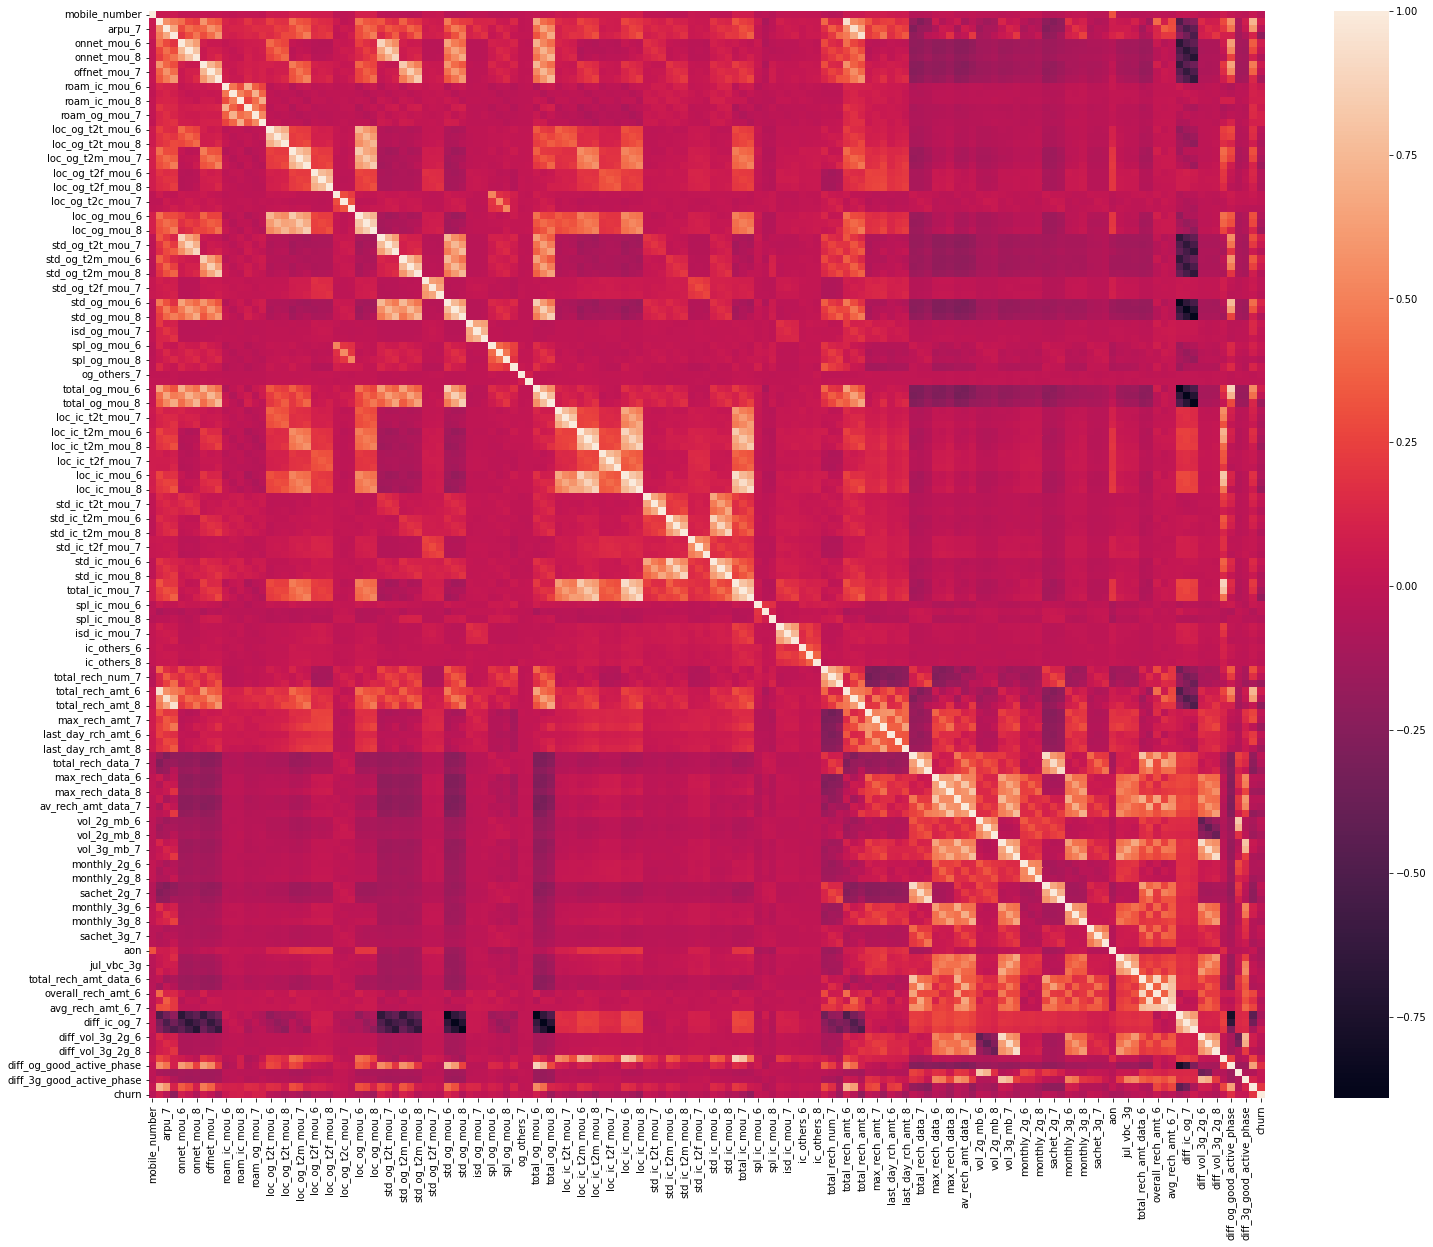

In [53]:
plt.figure(figsize = [25, 20])

sns.heatmap(telecom_data.corr())

plt.show()

In [54]:
#finding out the most correlated variables

corr_matrix = telecom_data.corr().abs()

#the matrix is symmetric so we need to extract upper triangle matrix without diagonal (k = 1)
upper_triangle = (corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k = 1).astype(np.bool))) #triu: Return a copy of an array with the elements below the k-th diagonal zeroed

highly_correlated_features = [x for x in upper_triangle.columns if any(upper_triangle[x] > 0.80)] #correlation cutoff

print("Highly correlated variables (> 0.8):\n\n", highly_correlated_features)
print("\n\nNumber of such variables: ", len(highly_correlated_features))

Highly correlated variables (> 0.8):

 ['onnet_mou_8', 'loc_og_t2t_mou_8', 'loc_og_t2m_mou_8', 'loc_og_mou_6', 'loc_og_mou_7', 'loc_og_mou_8', 'std_og_t2t_mou_6', 'std_og_t2t_mou_7', 'std_og_t2t_mou_8', 'std_og_t2m_mou_6', 'std_og_t2m_mou_7', 'std_og_t2m_mou_8', 'std_og_mou_8', 'total_og_mou_6', 'total_og_mou_7', 'total_og_mou_8', 'loc_ic_t2t_mou_8', 'loc_ic_t2m_mou_8', 'loc_ic_mou_6', 'loc_ic_mou_7', 'loc_ic_mou_8', 'std_ic_mou_6', 'std_ic_mou_7', 'std_ic_mou_8', 'total_ic_mou_6', 'total_ic_mou_7', 'total_ic_mou_8', 'total_rech_amt_6', 'total_rech_amt_7', 'total_rech_amt_8', 'av_rech_amt_data_6', 'av_rech_amt_data_7', 'av_rech_amt_data_8', 'sachet_2g_6', 'sachet_2g_7', 'sachet_2g_8', 'total_rech_amt_data_6', 'overall_rech_amt_6', 'overall_rech_amt_7', 'avg_rech_amt_6_7', 'diff_ic_og_6', 'diff_ic_og_7', 'diff_ic_og_8', 'diff_vol_3g_2g_6', 'diff_vol_3g_2g_7', 'diff_vol_3g_2g_8', 'diff_ic_good_active_phase', 'diff_og_good_active_phase', 'diff_2g_good_active_phase', 'diff_3g_good_active_p

We can see there are 50 highly correlated variables.

The ideal thing to do now is to keep these highly correlated features for now. We will be performing Principal Component Analysis and PCA will automatically handle such variables.

# 3. Exploratory Data Analysis

In [55]:
telecom_data.shape

(28083, 151)

In [56]:
telecom_data.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28083 entries, 0 to 99997
Data columns (total 151 columns):
 #   Column                           Dtype  
---  ------                           -----  
 0   mobile_number                    float64
 1   arpu_6                           float64
 2   arpu_7                           float64
 3   arpu_8                           float64
 4   onnet_mou_6                      float64
 5   onnet_mou_7                      float64
 6   onnet_mou_8                      float64
 7   offnet_mou_6                     float64
 8   offnet_mou_7                     float64
 9   offnet_mou_8                     float64
 10  roam_ic_mou_6                    float64
 11  roam_ic_mou_7                    float64
 12  roam_ic_mou_8                    float64
 13  roam_og_mou_6                    float64
 14  roam_og_mou_7                    float64
 15  roam_og_mou_8                    float64
 16  loc_og_t2t_mou_6                 float64
 17  loc_og_t2t_

In [57]:
#creating a custom function for plotting boxplots

def boxplots(y):
  plt.figure(figsize = [20, 6])
  data = telecom_data
  plt.title("First 3 months' boxplots of " + y)

  plt.subplot(1, 3, 1)
  sns.boxplot(data = telecom_data, x = "churn", y = y+"_6", palette = "deep")

  plt.subplot(1, 3, 2)
  sns.boxplot(data = telecom_data, x = "churn", y = y+"_7", palette = "YlGn")

  plt.subplot(1, 3, 3)
  sns.boxplot(data = telecom_data, x = "churn", y = y+"_8", palette = "plasma")
  plt.show()

In [58]:
Cols = telecom_data.columns

a = [x for x in Cols]
print(a)

['mobile_number', 'arpu_6', 'arpu_7', 'arpu_8', 'onnet_mou_6', 'onnet_mou_7', 'onnet_mou_8', 'offnet_mou_6', 'offnet_mou_7', 'offnet_mou_8', 'roam_ic_mou_6', 'roam_ic_mou_7', 'roam_ic_mou_8', 'roam_og_mou_6', 'roam_og_mou_7', 'roam_og_mou_8', 'loc_og_t2t_mou_6', 'loc_og_t2t_mou_7', 'loc_og_t2t_mou_8', 'loc_og_t2m_mou_6', 'loc_og_t2m_mou_7', 'loc_og_t2m_mou_8', 'loc_og_t2f_mou_6', 'loc_og_t2f_mou_7', 'loc_og_t2f_mou_8', 'loc_og_t2c_mou_6', 'loc_og_t2c_mou_7', 'loc_og_t2c_mou_8', 'loc_og_mou_6', 'loc_og_mou_7', 'loc_og_mou_8', 'std_og_t2t_mou_6', 'std_og_t2t_mou_7', 'std_og_t2t_mou_8', 'std_og_t2m_mou_6', 'std_og_t2m_mou_7', 'std_og_t2m_mou_8', 'std_og_t2f_mou_6', 'std_og_t2f_mou_7', 'std_og_t2f_mou_8', 'std_og_mou_6', 'std_og_mou_7', 'std_og_mou_8', 'isd_og_mou_6', 'isd_og_mou_7', 'isd_og_mou_8', 'spl_og_mou_6', 'spl_og_mou_7', 'spl_og_mou_8', 'og_others_6', 'og_others_7', 'og_others_8', 'total_og_mou_6', 'total_og_mou_7', 'total_og_mou_8', 'loc_ic_t2t_mou_6', 'loc_ic_t2t_mou_7', 'loc_i

In [59]:
#choosing only the base variables (we will impute _6,_7,_8 later)
boxplotColumns = ["arpu", "onnet_mou", 'offnet_mou', 'roam_ic_mou', 'roam_og_mou', 'loc_og_t2t_mou', 'loc_og_t2m_mou', 'loc_og_t2f_mou', 'loc_og_t2c_mou', 'loc_og_mou', 'std_og_t2t_mou', 'std_og_t2m_mou', 'std_og_t2f_mou', 'std_og_mou', 'isd_og_mou', 'spl_og_mou', 'og_others', 'total_og_mou', 'loc_ic_t2t_mou', 'loc_ic_t2m_mou', 'loc_ic_t2f_mou', 'loc_ic_mou', 'std_ic_t2t_mou', 'std_ic_t2m_mou', 'std_ic_t2f_mou', 'std_ic_mou', 'total_ic_mou', 'spl_ic_mou', 'isd_ic_mou', 'ic_others', 'total_rech_num', 'total_rech_amt', 'max_rech_amt', 'last_day_rch_amt', 'total_rech_data', 'max_rech_data', 'av_rech_amt_data', 'vol_2g_mb', 'vol_3g_mb', 'monthly_2g', 'sachet_2g', 'monthly_3g', 'sachet_3g', 'diff_ic_og', 'diff_vol_3g_2g']

### 3.1 Boxplots with fliers

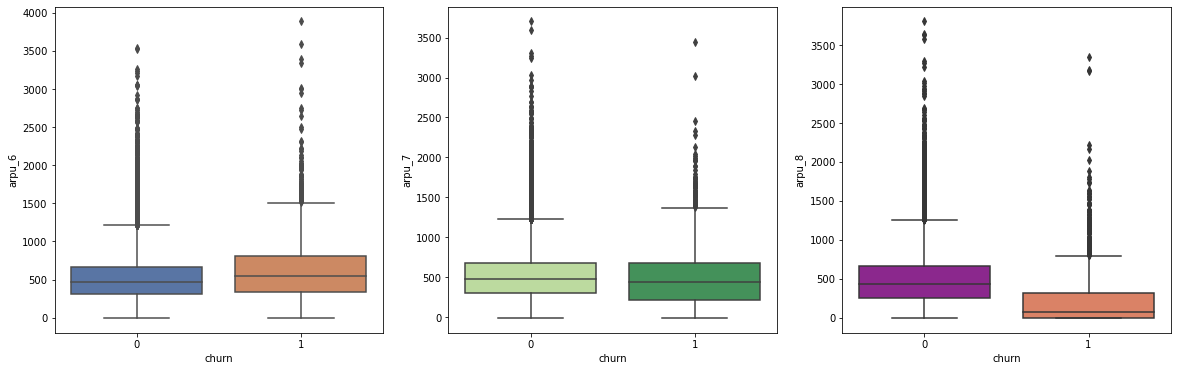

x------------------------------------------------------------------------------------------------------------------------------------------------------x


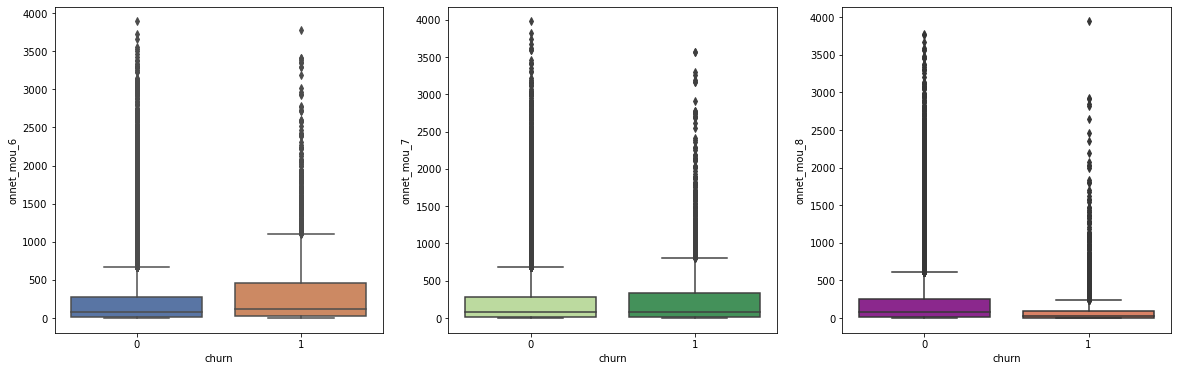

x------------------------------------------------------------------------------------------------------------------------------------------------------x


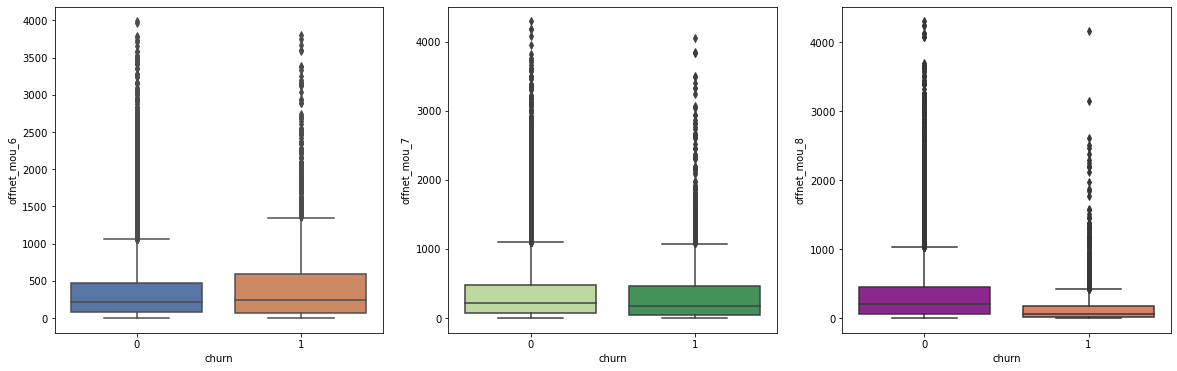

x------------------------------------------------------------------------------------------------------------------------------------------------------x


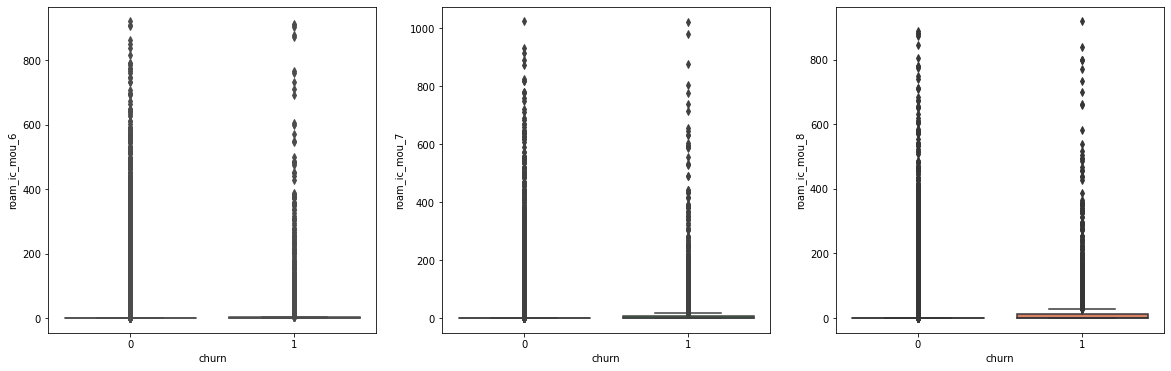

x------------------------------------------------------------------------------------------------------------------------------------------------------x


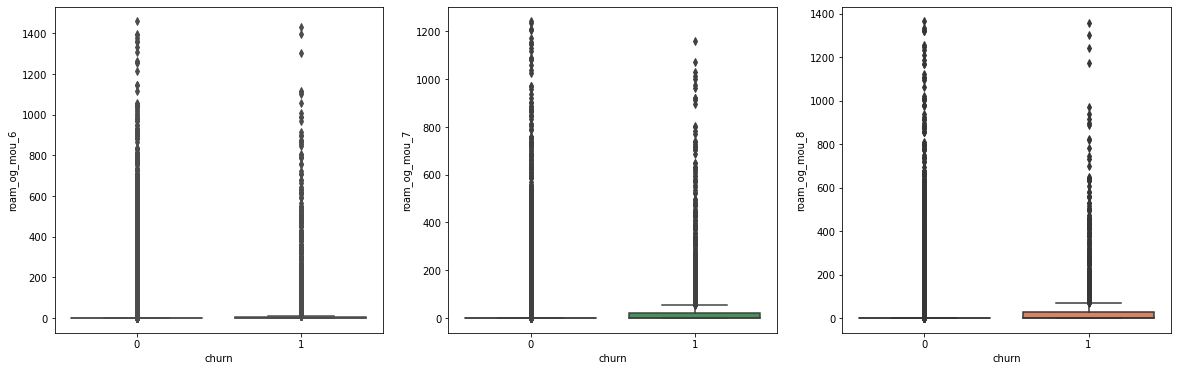

x------------------------------------------------------------------------------------------------------------------------------------------------------x


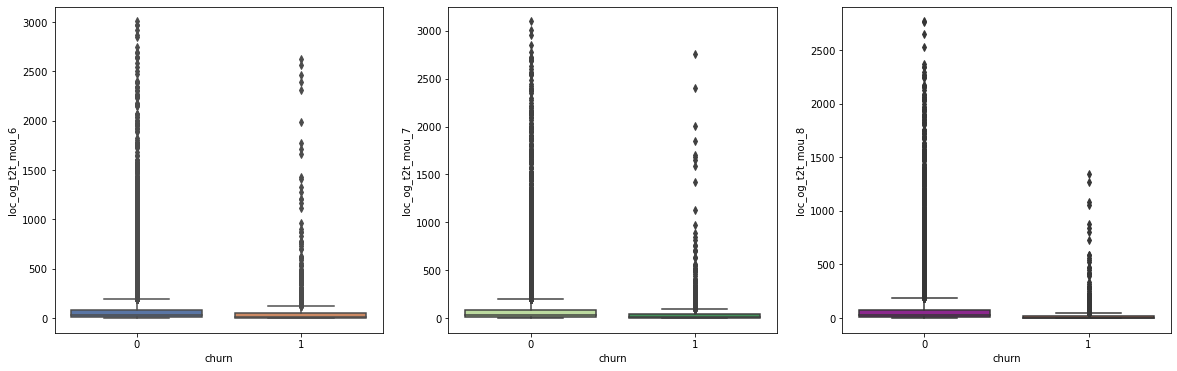

x------------------------------------------------------------------------------------------------------------------------------------------------------x


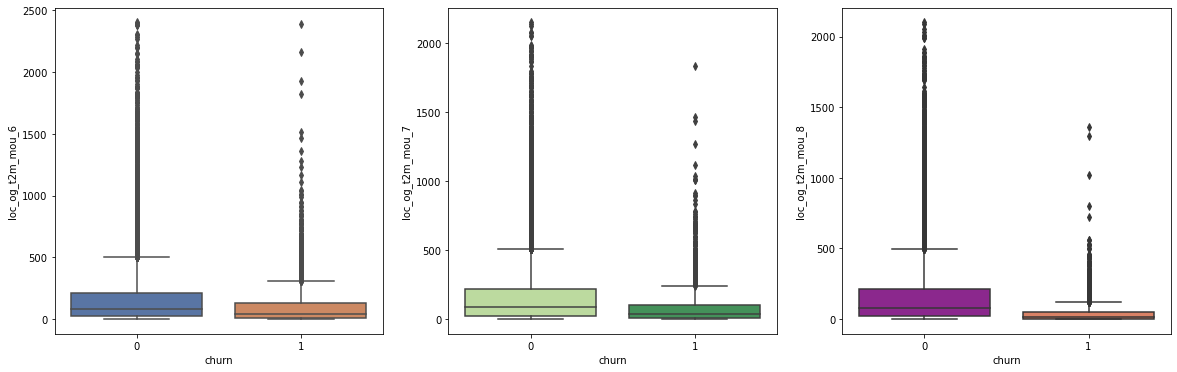

x------------------------------------------------------------------------------------------------------------------------------------------------------x


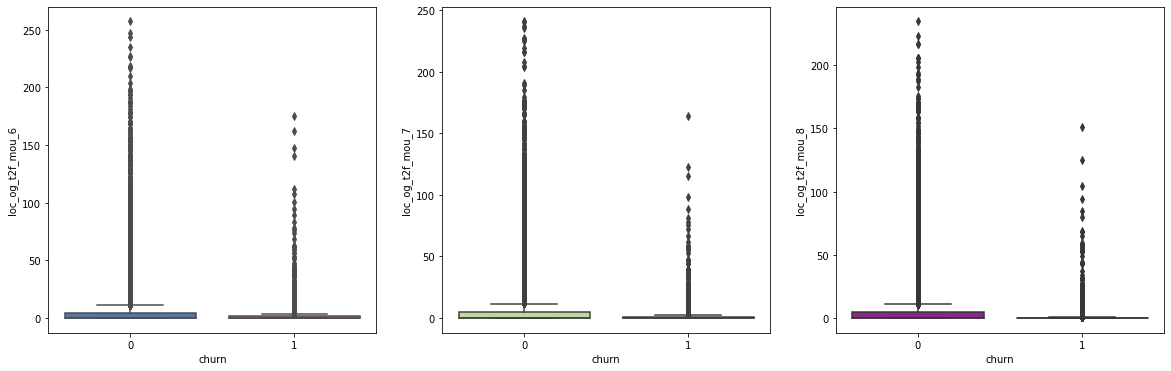

x------------------------------------------------------------------------------------------------------------------------------------------------------x


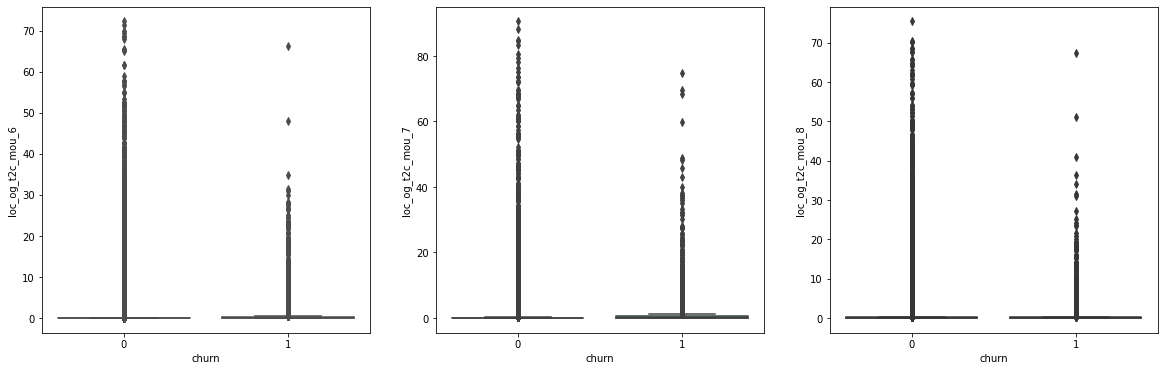

x------------------------------------------------------------------------------------------------------------------------------------------------------x


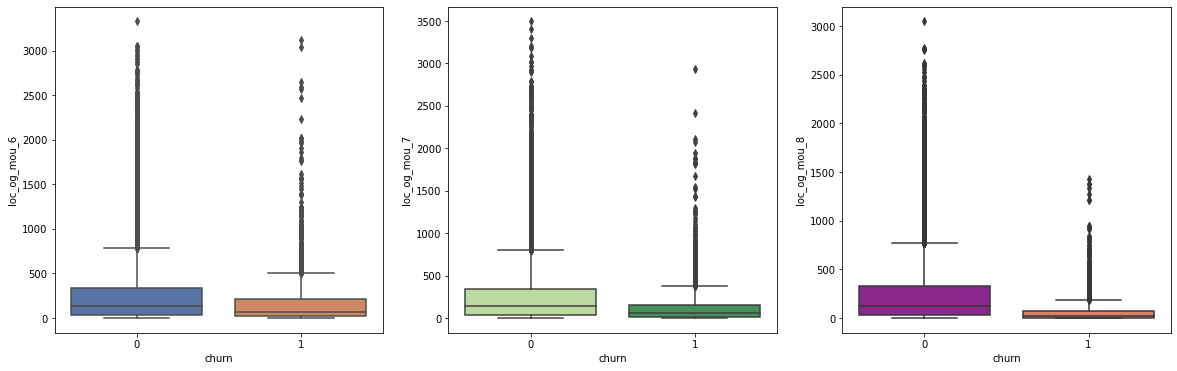

x------------------------------------------------------------------------------------------------------------------------------------------------------x


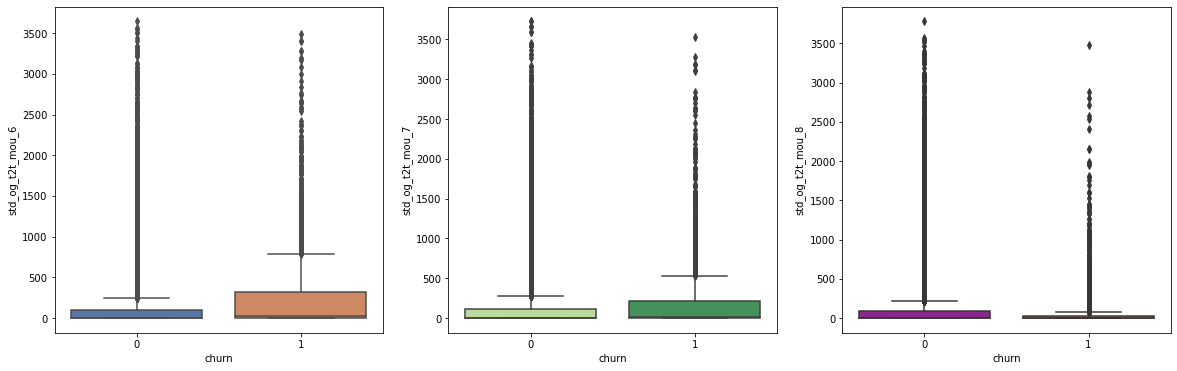

x------------------------------------------------------------------------------------------------------------------------------------------------------x


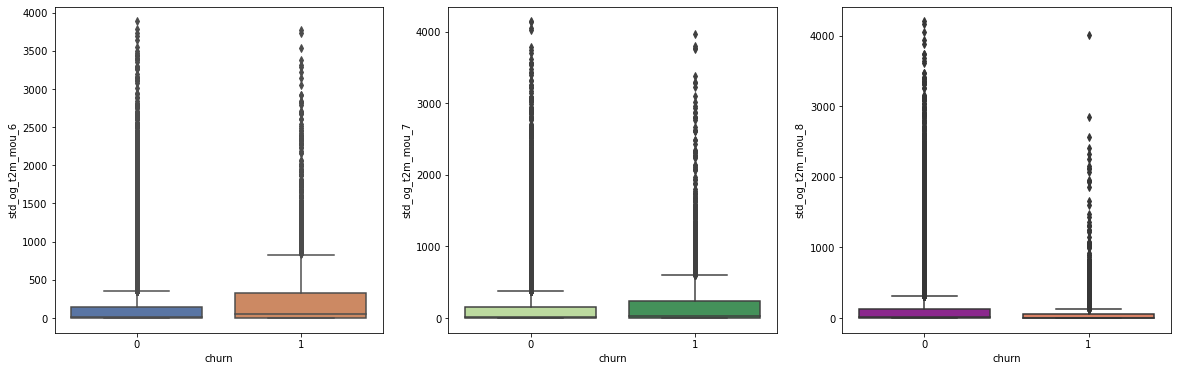

x------------------------------------------------------------------------------------------------------------------------------------------------------x


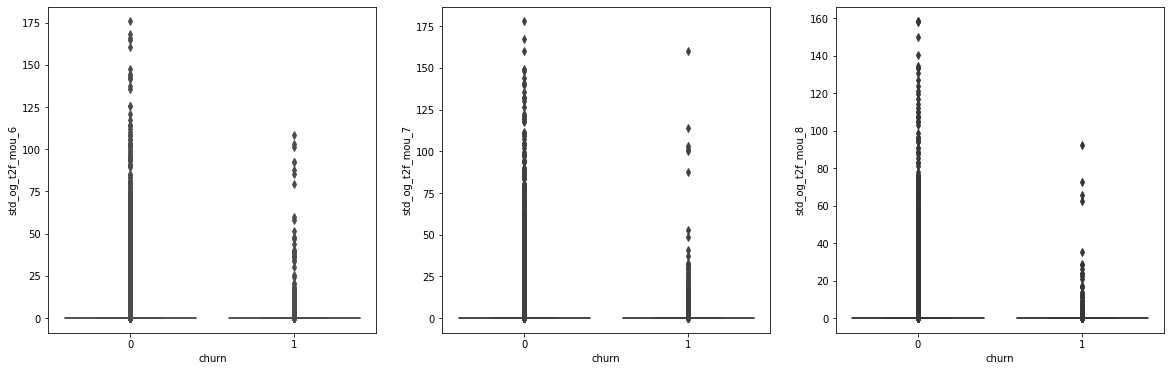

x------------------------------------------------------------------------------------------------------------------------------------------------------x


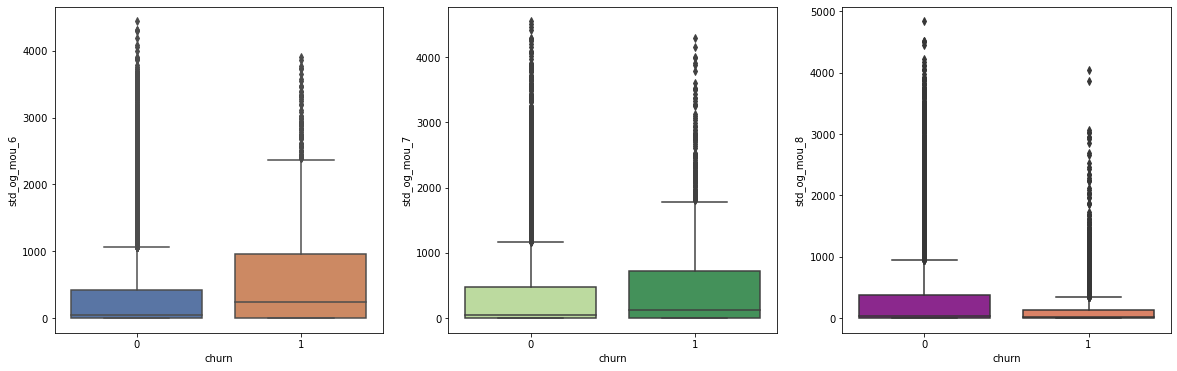

x------------------------------------------------------------------------------------------------------------------------------------------------------x


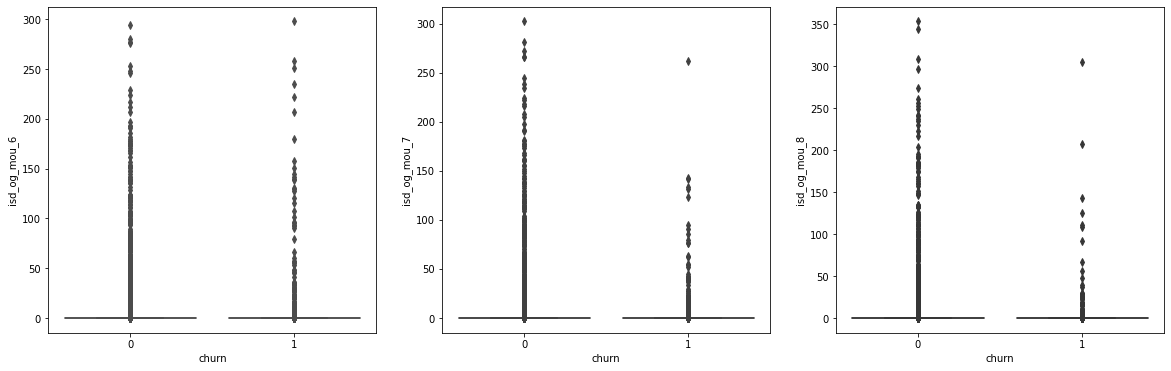

x------------------------------------------------------------------------------------------------------------------------------------------------------x


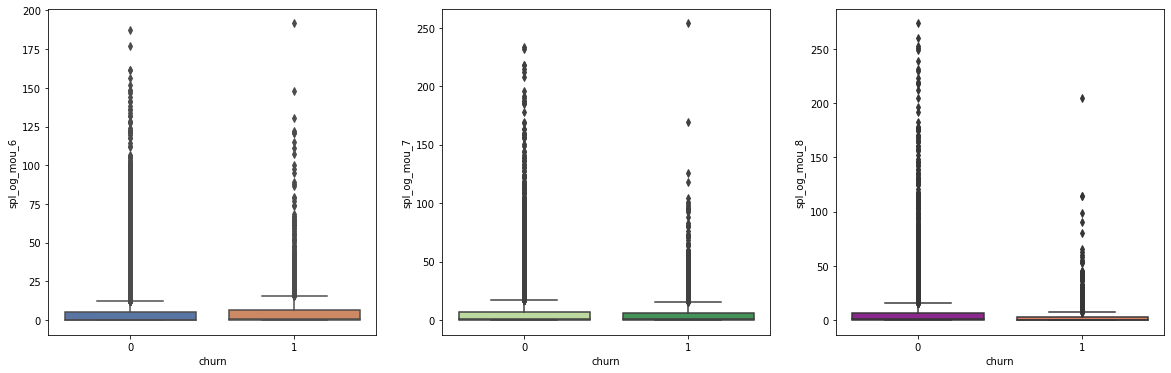

x------------------------------------------------------------------------------------------------------------------------------------------------------x


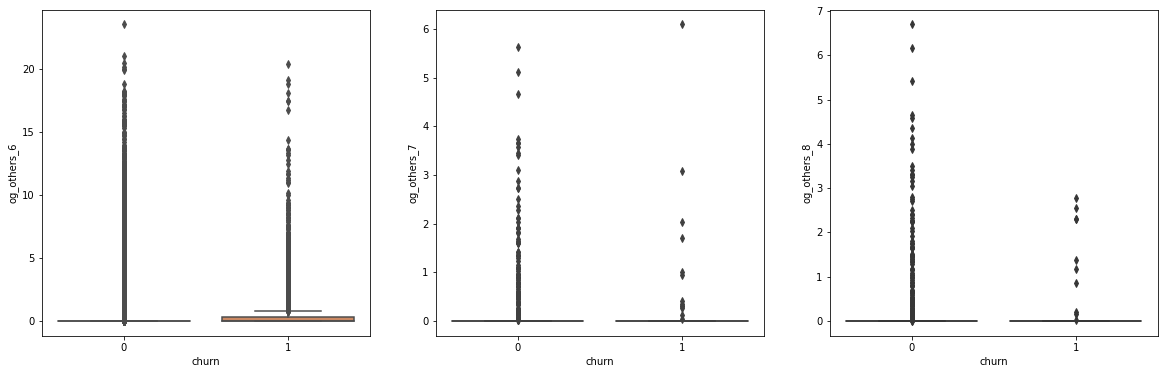

x------------------------------------------------------------------------------------------------------------------------------------------------------x


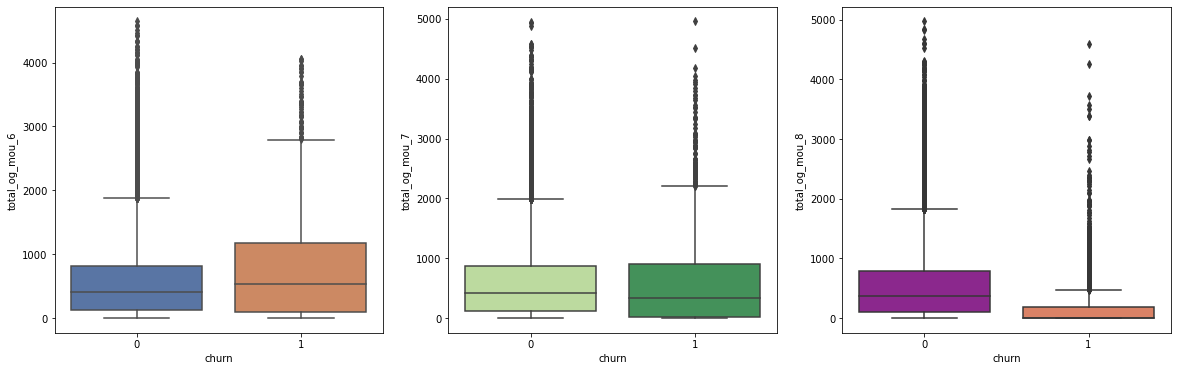

x------------------------------------------------------------------------------------------------------------------------------------------------------x


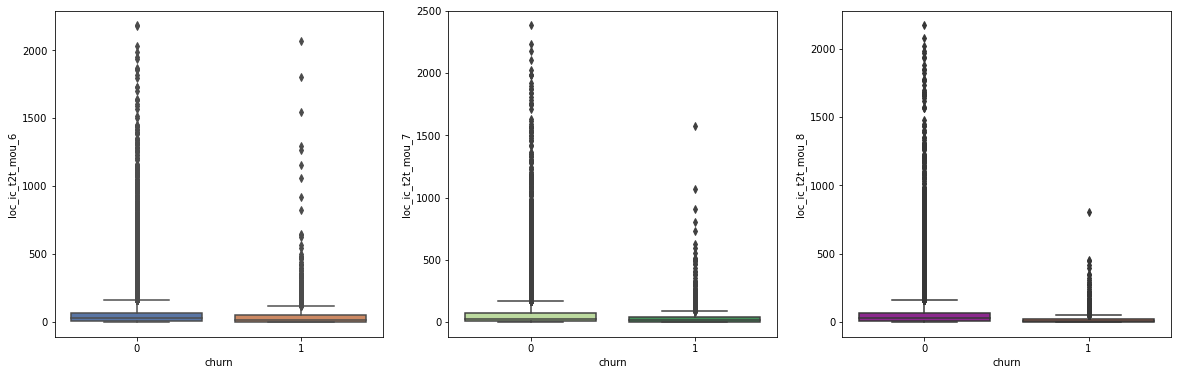

x------------------------------------------------------------------------------------------------------------------------------------------------------x


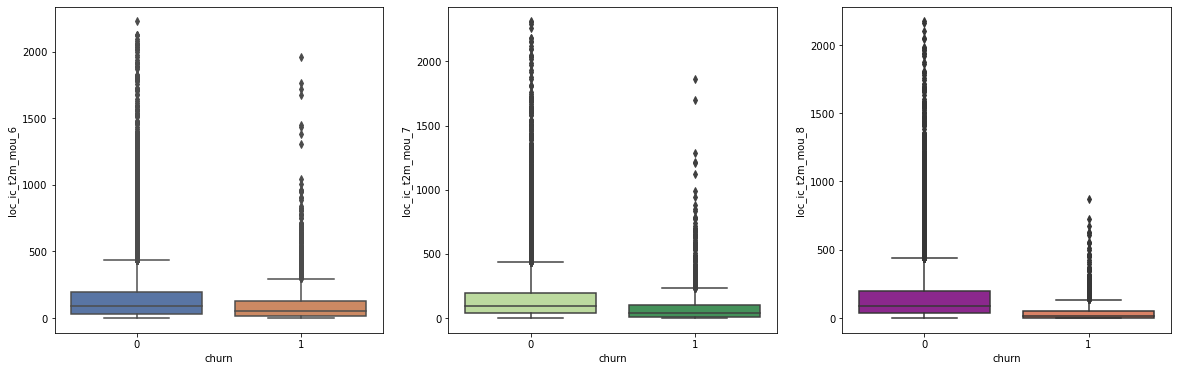

x------------------------------------------------------------------------------------------------------------------------------------------------------x


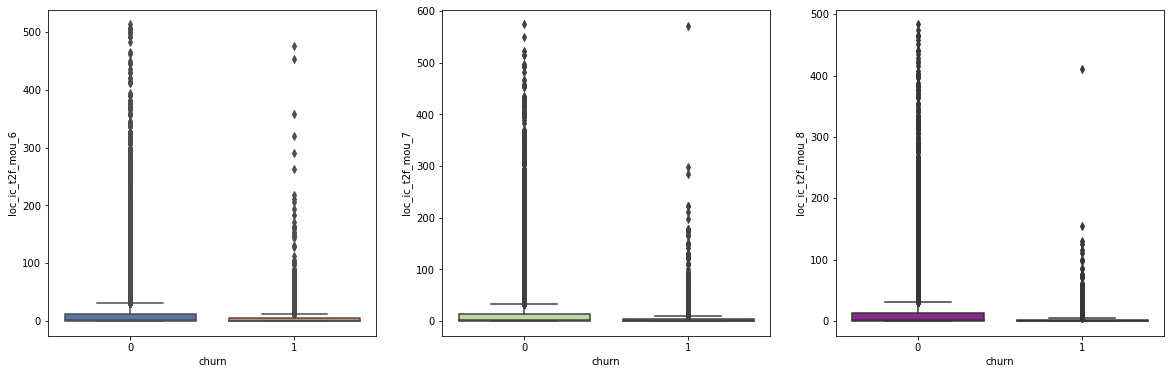

x------------------------------------------------------------------------------------------------------------------------------------------------------x


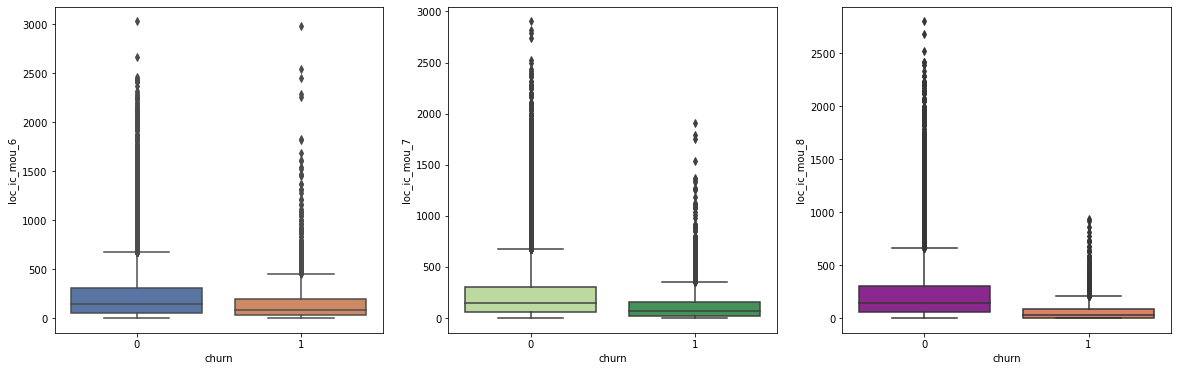

x------------------------------------------------------------------------------------------------------------------------------------------------------x


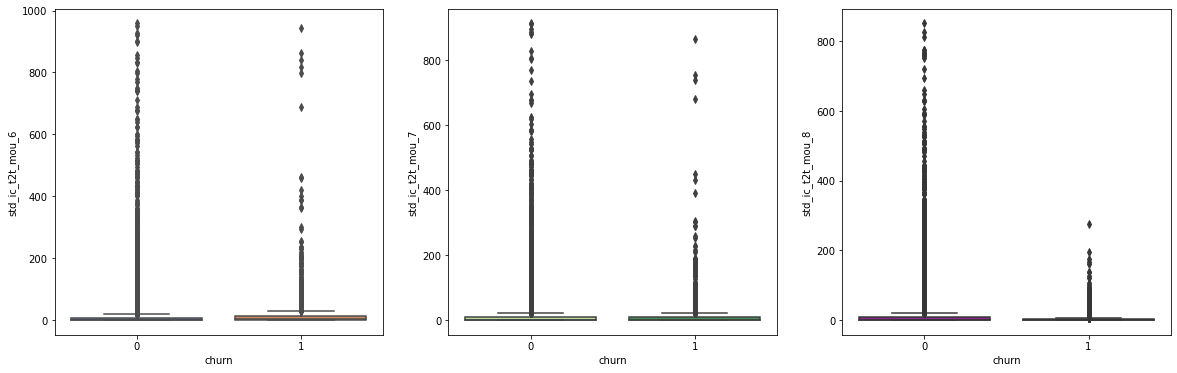

x------------------------------------------------------------------------------------------------------------------------------------------------------x


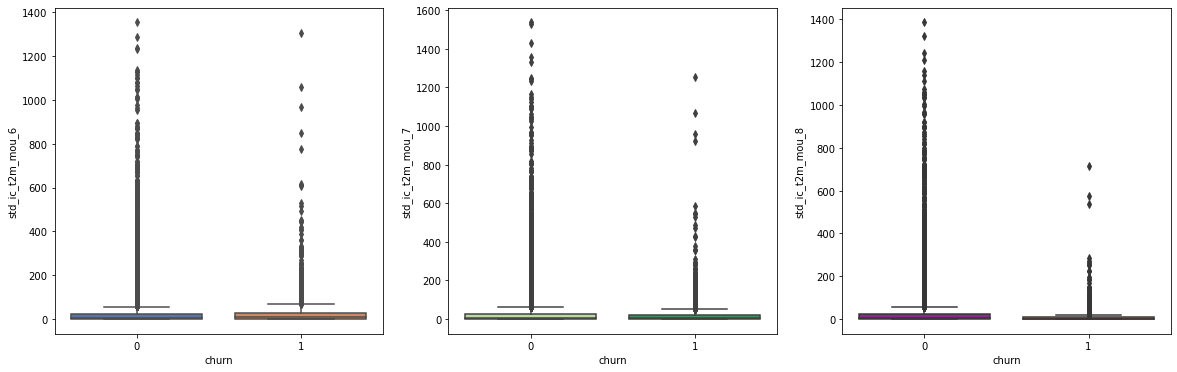

x------------------------------------------------------------------------------------------------------------------------------------------------------x


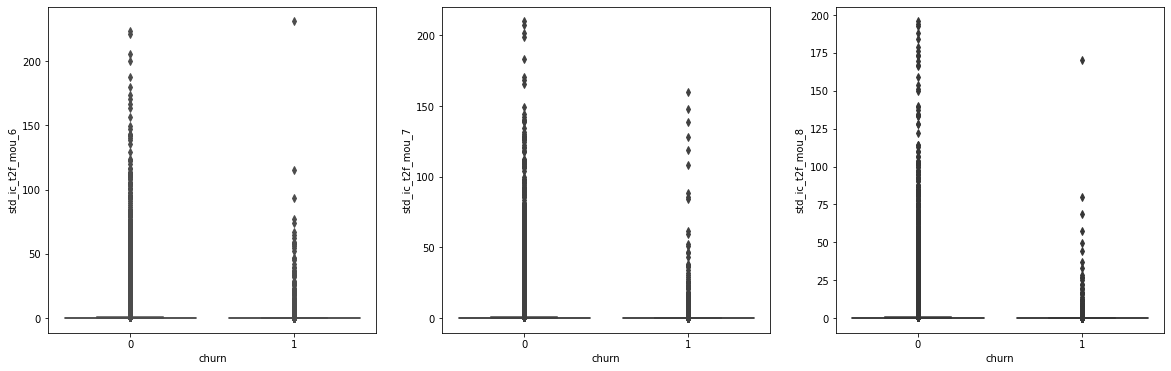

x------------------------------------------------------------------------------------------------------------------------------------------------------x


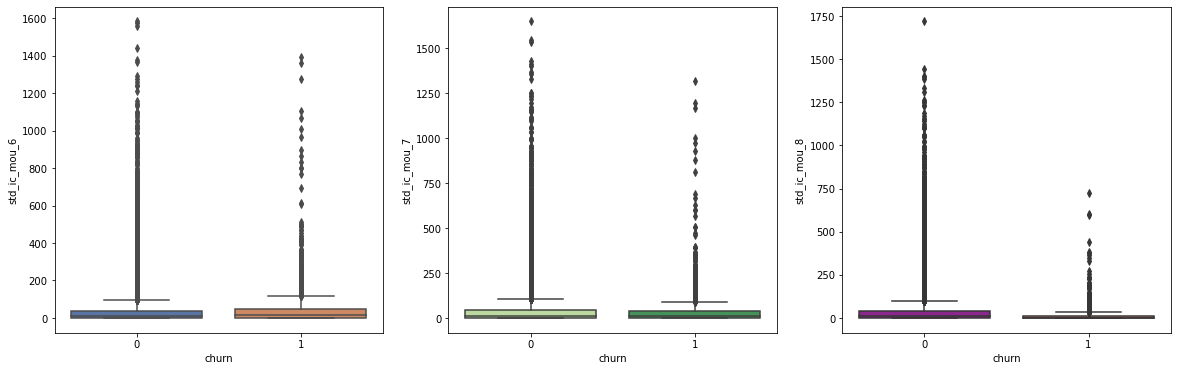

x------------------------------------------------------------------------------------------------------------------------------------------------------x


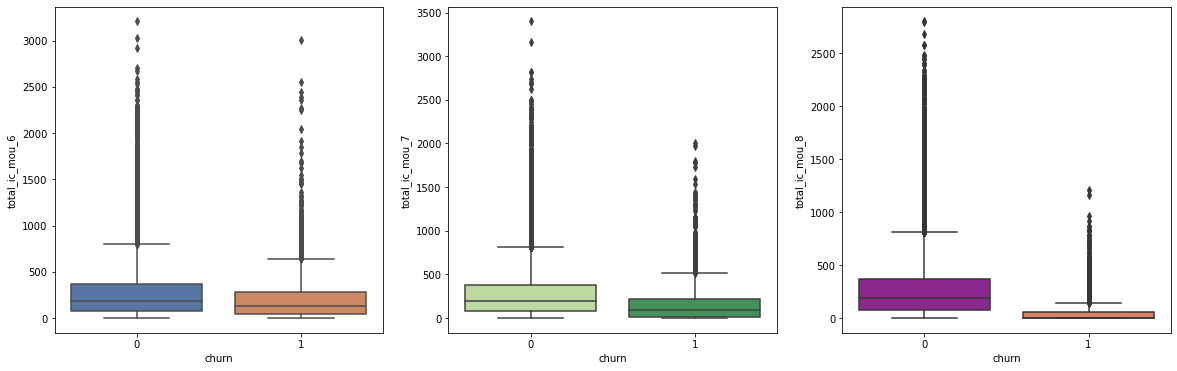

x------------------------------------------------------------------------------------------------------------------------------------------------------x


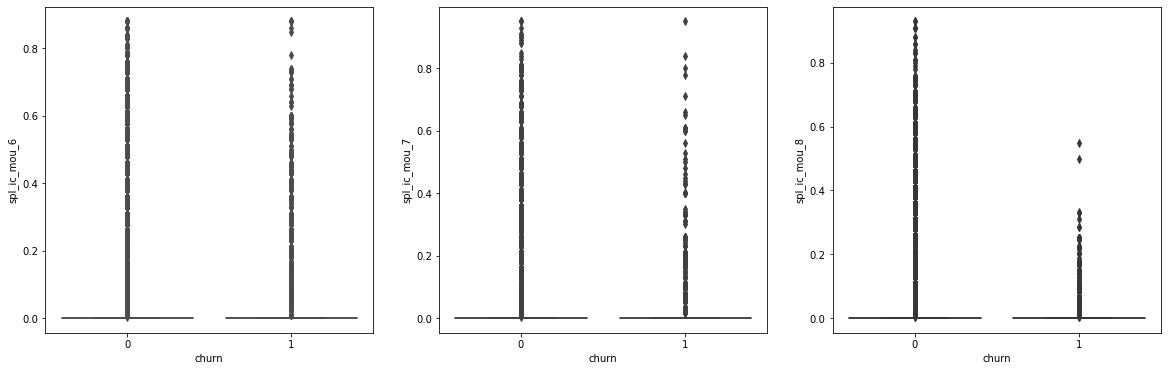

x------------------------------------------------------------------------------------------------------------------------------------------------------x


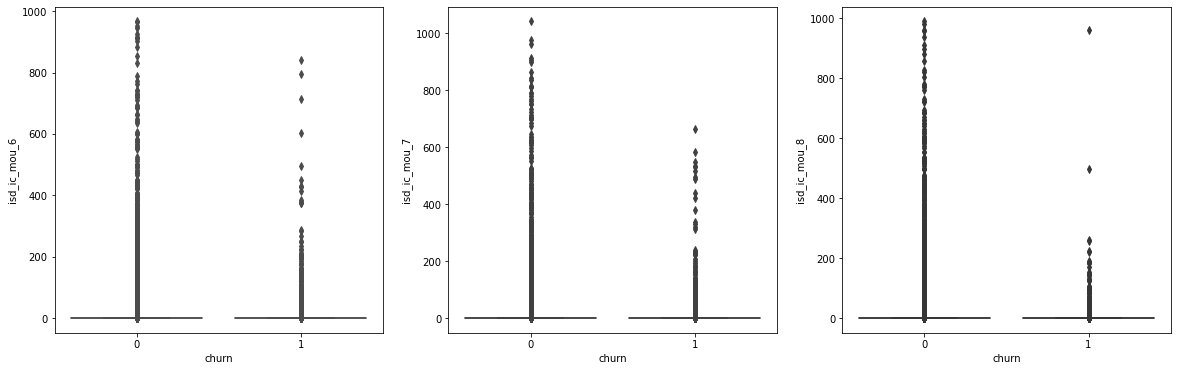

x------------------------------------------------------------------------------------------------------------------------------------------------------x


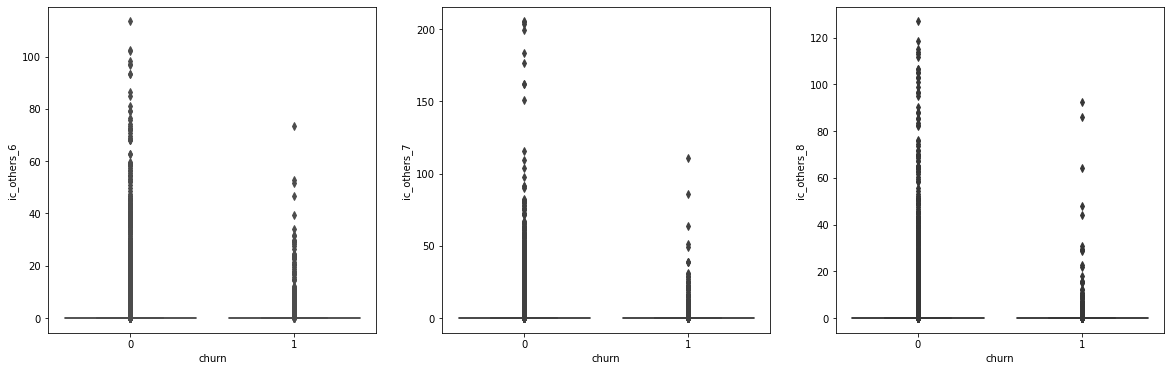

x------------------------------------------------------------------------------------------------------------------------------------------------------x


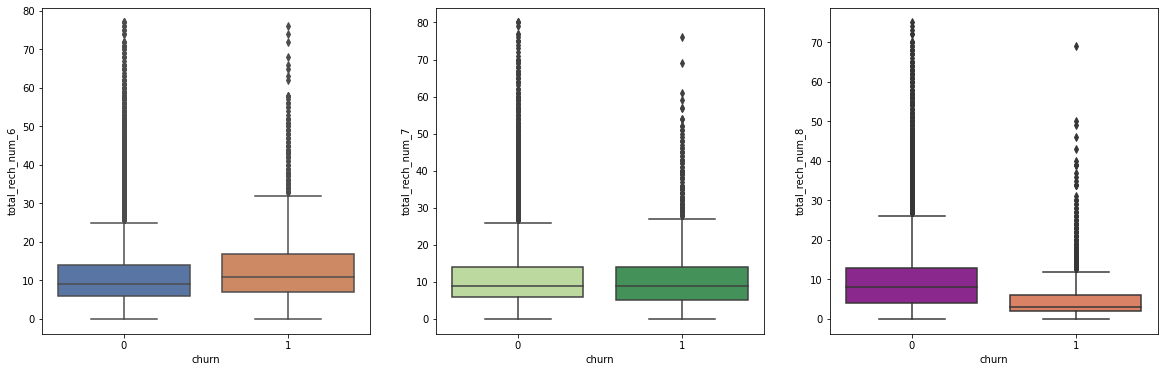

x------------------------------------------------------------------------------------------------------------------------------------------------------x


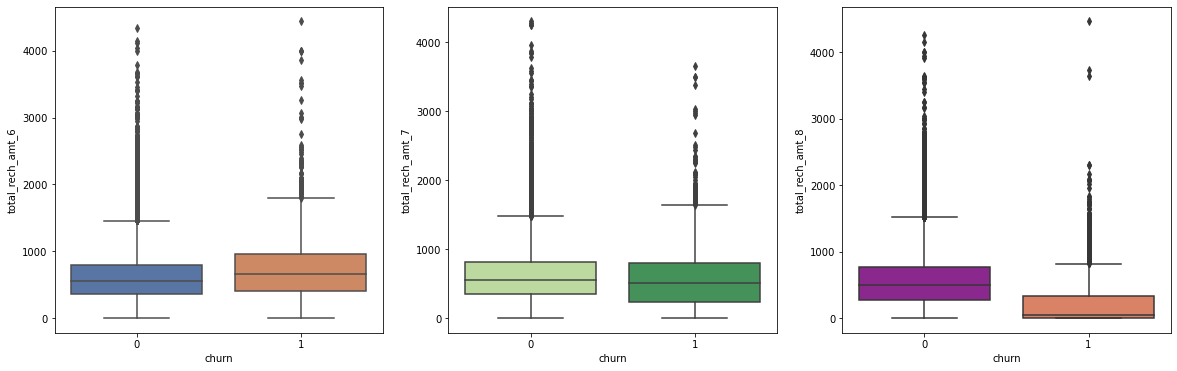

x------------------------------------------------------------------------------------------------------------------------------------------------------x


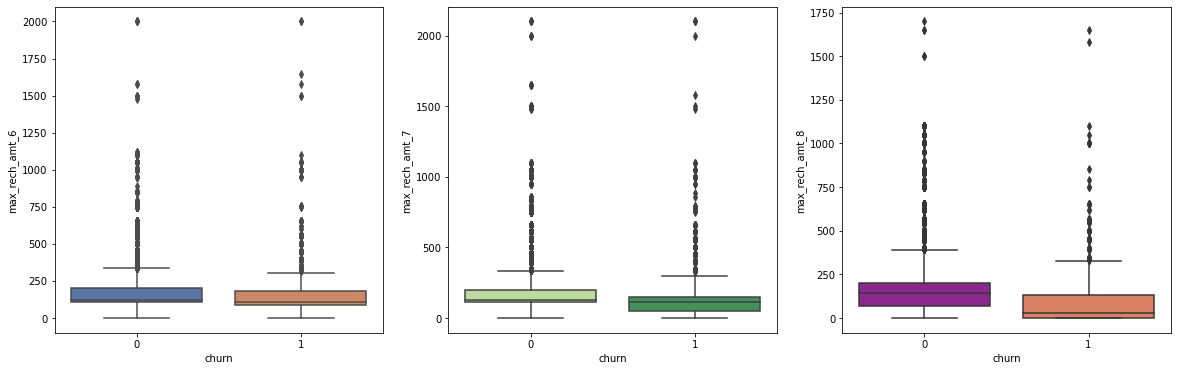

x------------------------------------------------------------------------------------------------------------------------------------------------------x


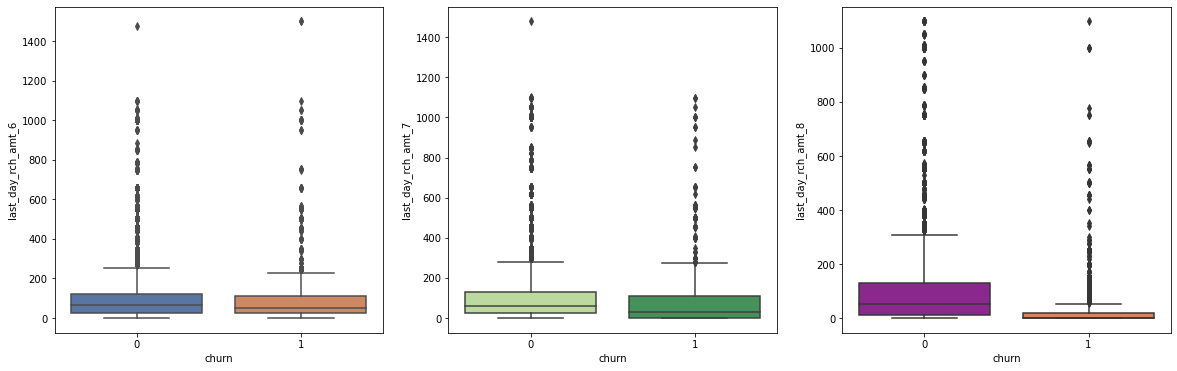

x------------------------------------------------------------------------------------------------------------------------------------------------------x


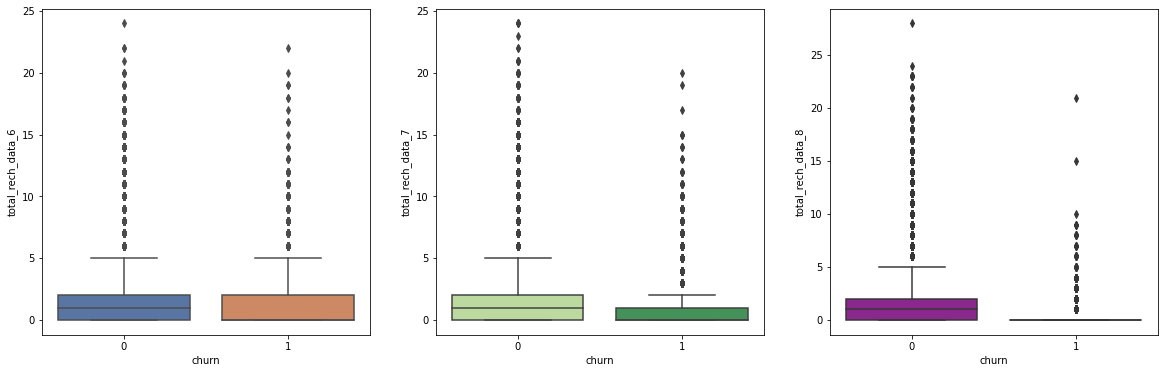

x------------------------------------------------------------------------------------------------------------------------------------------------------x


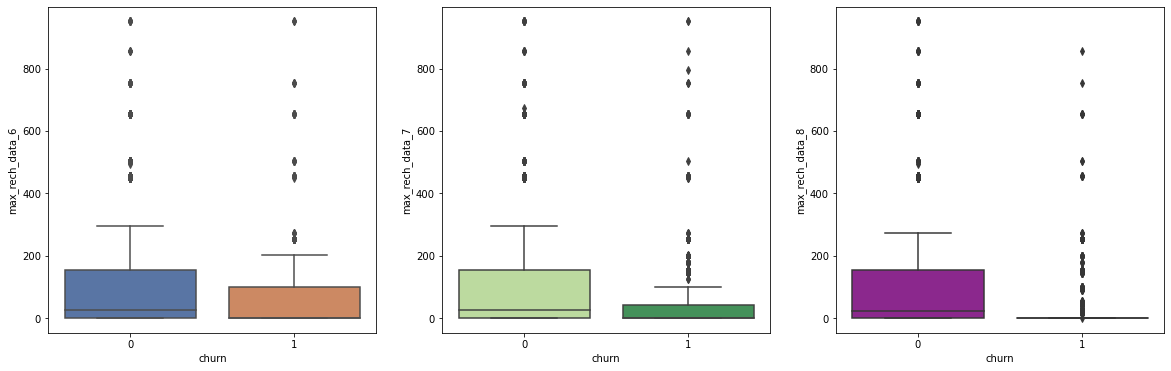

x------------------------------------------------------------------------------------------------------------------------------------------------------x


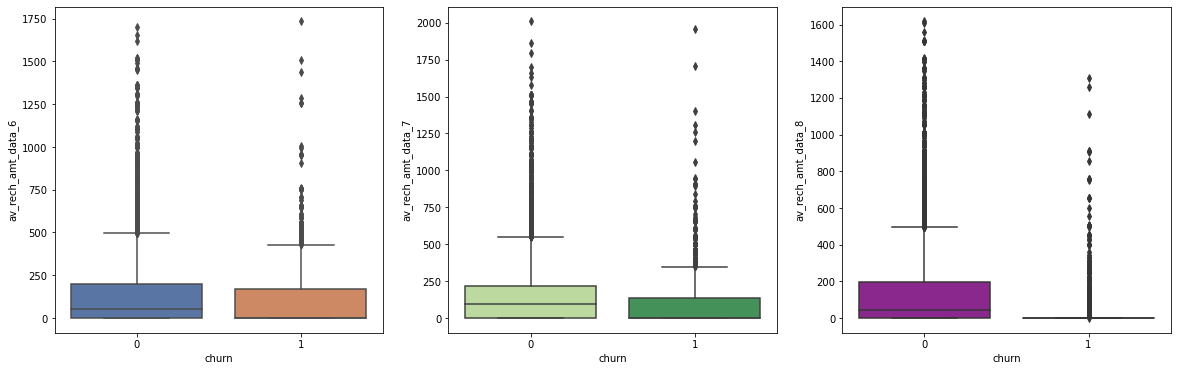

x------------------------------------------------------------------------------------------------------------------------------------------------------x


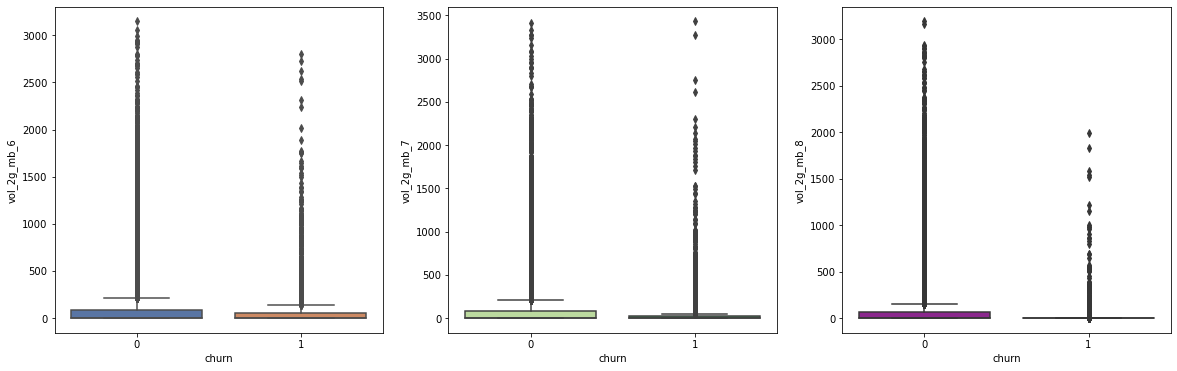

x------------------------------------------------------------------------------------------------------------------------------------------------------x


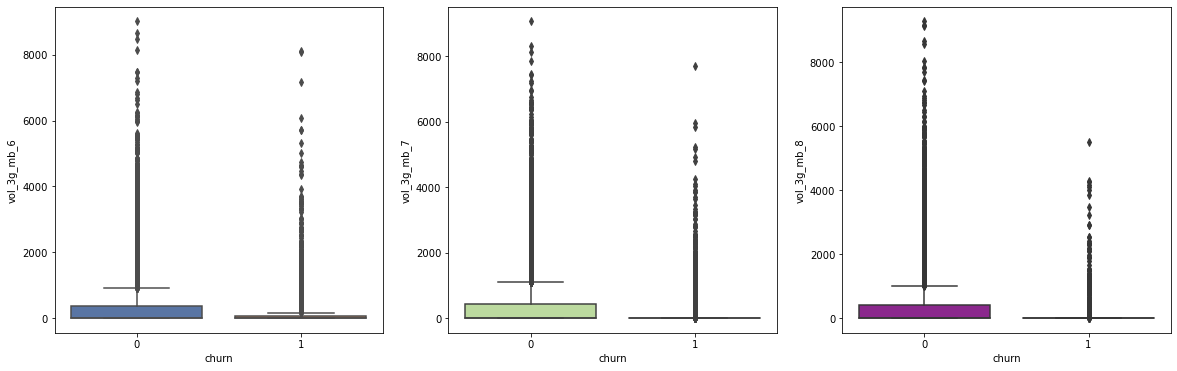

x------------------------------------------------------------------------------------------------------------------------------------------------------x


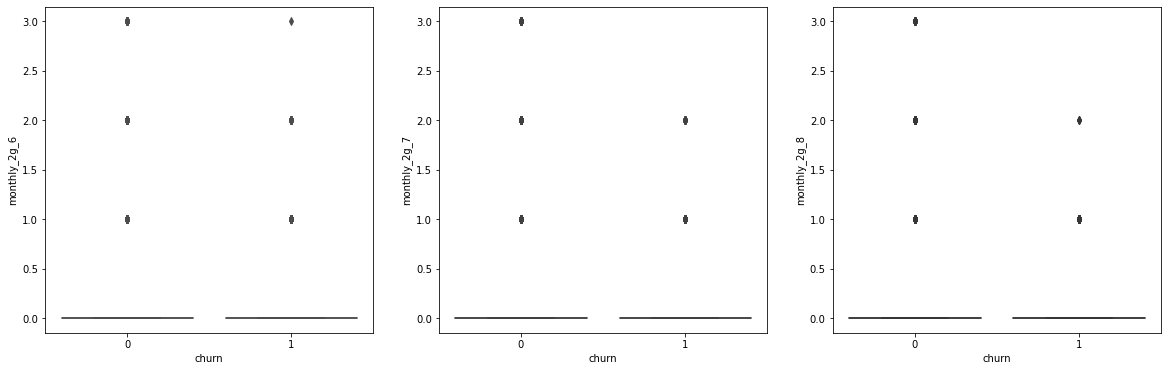

x------------------------------------------------------------------------------------------------------------------------------------------------------x


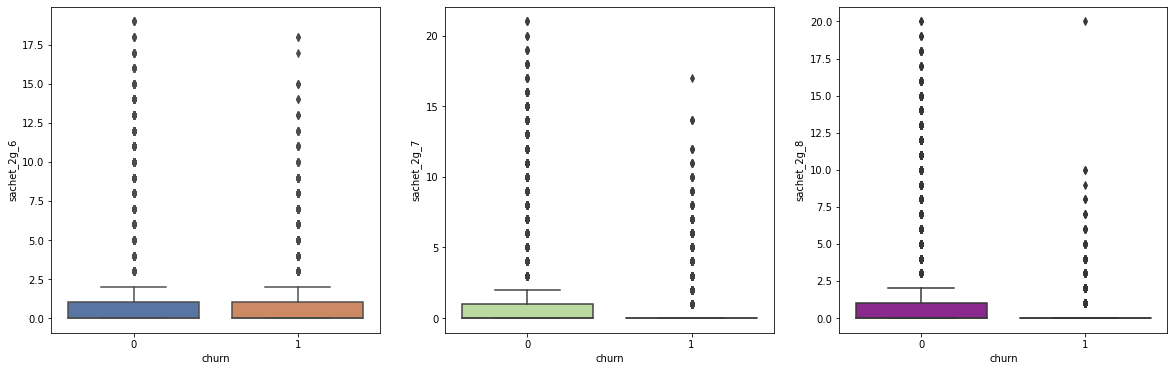

x------------------------------------------------------------------------------------------------------------------------------------------------------x


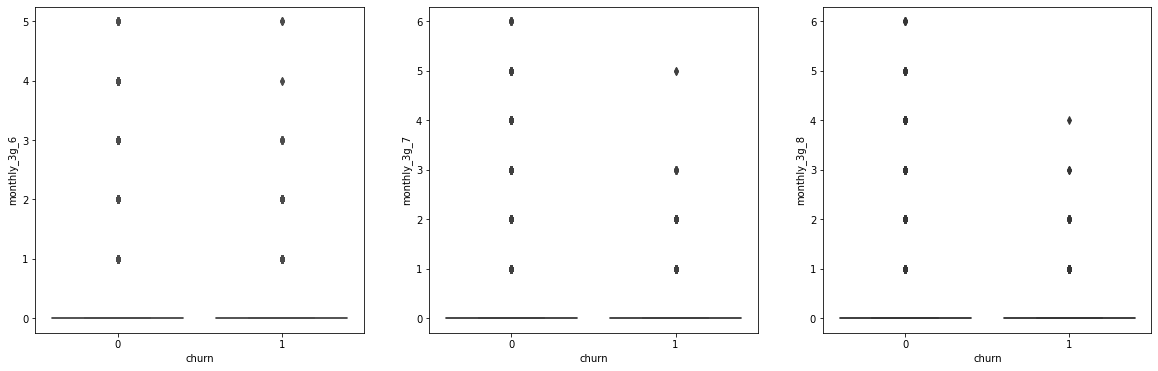

x------------------------------------------------------------------------------------------------------------------------------------------------------x


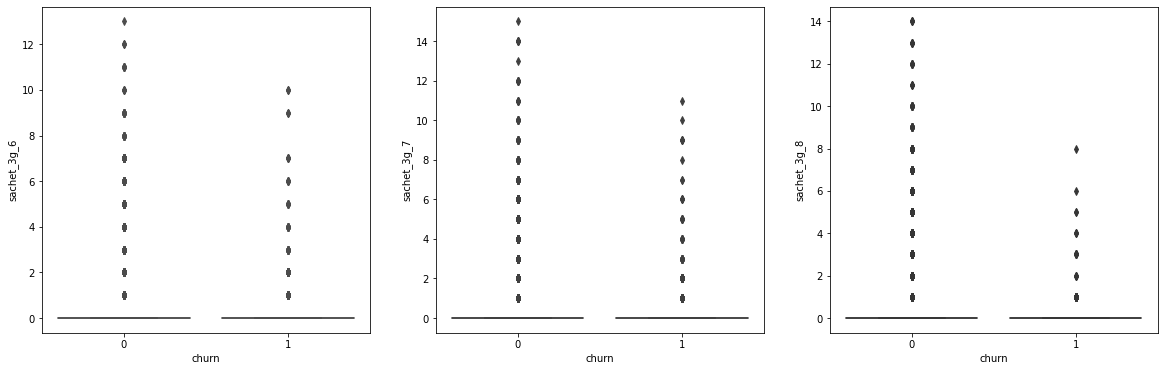

x------------------------------------------------------------------------------------------------------------------------------------------------------x


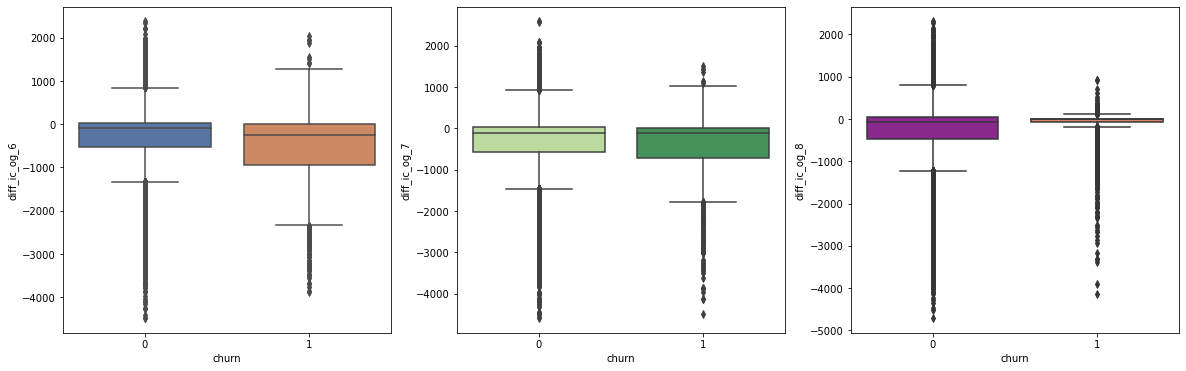

x------------------------------------------------------------------------------------------------------------------------------------------------------x


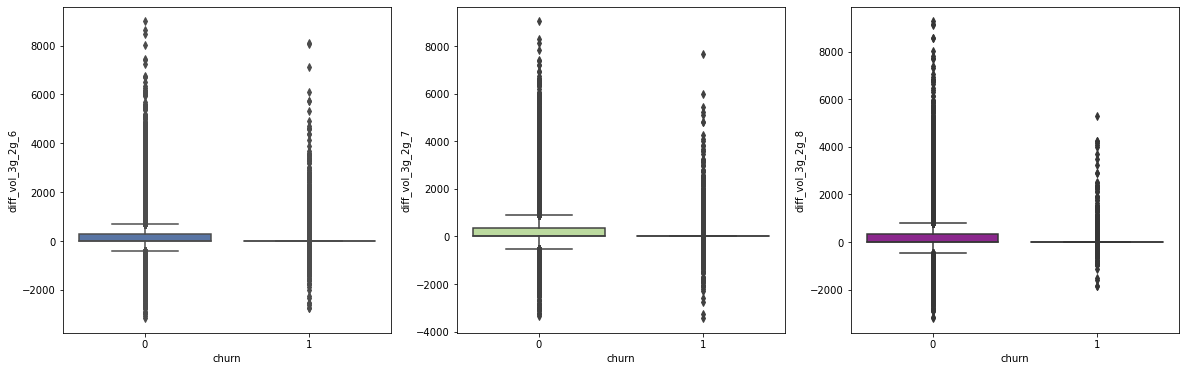

x------------------------------------------------------------------------------------------------------------------------------------------------------x


In [60]:
for i in boxplotColumns:
  boxplots(i)
  print("x" + "-"*150 + "x")

It is hard to make any inferences when looking at these boxplots as most of these are very streched. 

In [61]:
#making boxplots without the fliers

def boxplots_noFliers(y):
  plt.figure(figsize = [20, 6])
  data = telecom_data
  
  plt.subplot(1, 3, 1)
  sns.boxplot(data = telecom_data, x = "churn", y = y+"_6", palette = "deep", showfliers = False)

  plt.subplot(1, 3, 2)
  plt.title("First 3 months' boxplots of " + y)
  sns.boxplot(data = telecom_data, x = "churn", y = y+"_7", palette = "YlGn", showfliers = False)

  plt.subplot(1, 3, 3)
  sns.boxplot(data = telecom_data, x = "churn", y = y+"_8", palette = "plasma", showfliers = False)
  plt.show()

### 3.2 Boxplots without fliers

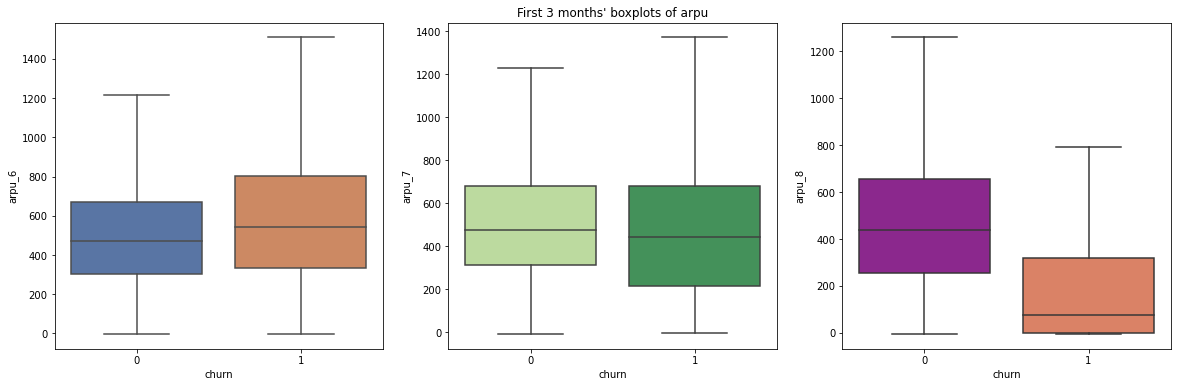

x------------------------------------------------------------------------------------------------------------------------------------------------------x


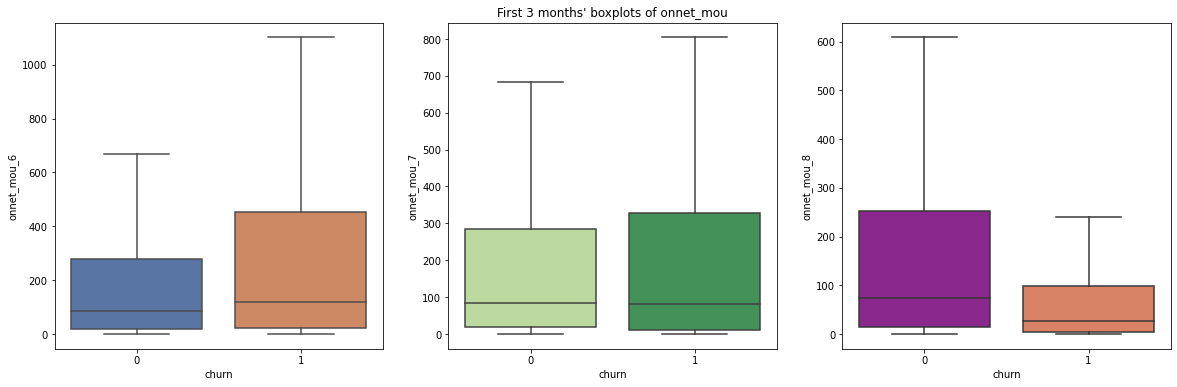

x------------------------------------------------------------------------------------------------------------------------------------------------------x


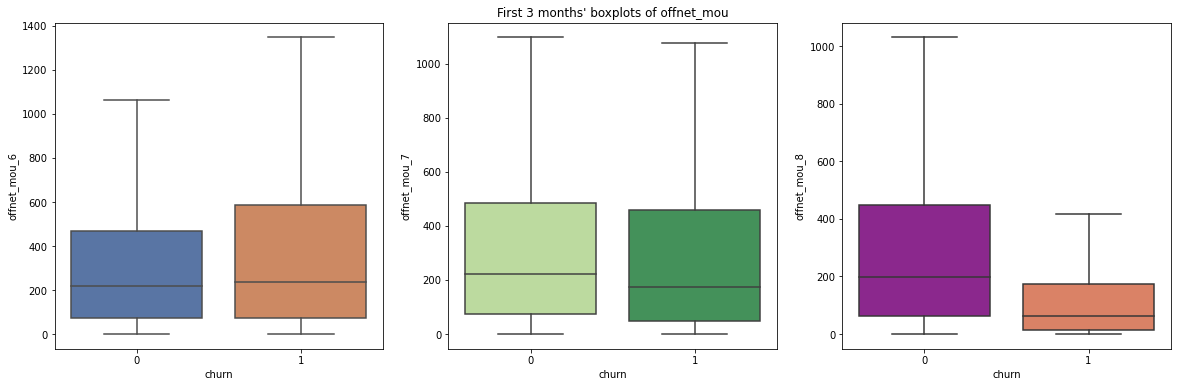

x------------------------------------------------------------------------------------------------------------------------------------------------------x


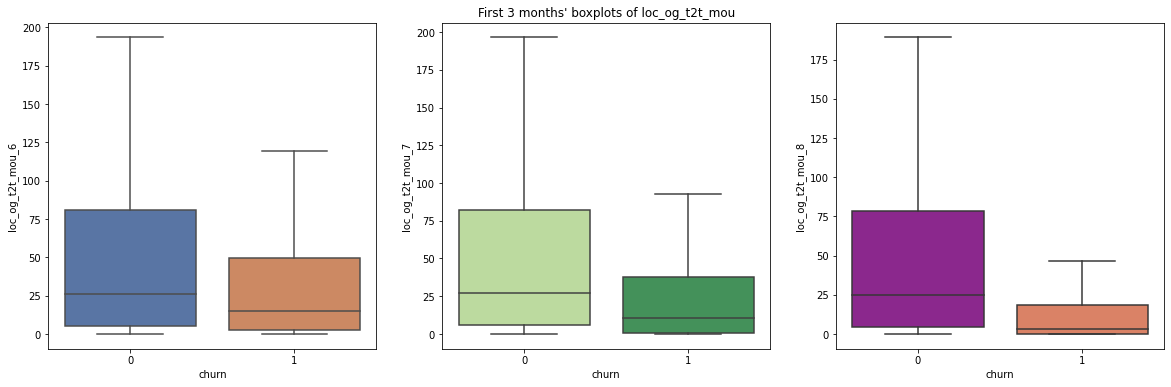

x------------------------------------------------------------------------------------------------------------------------------------------------------x


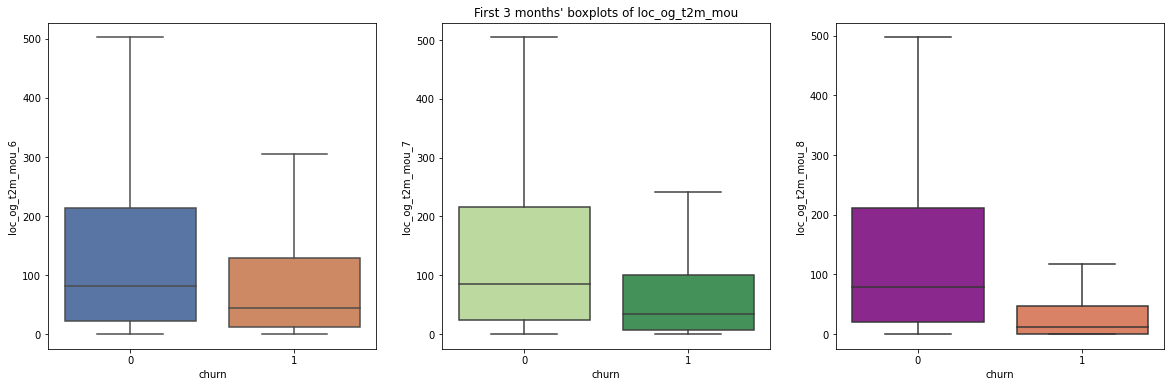

x------------------------------------------------------------------------------------------------------------------------------------------------------x


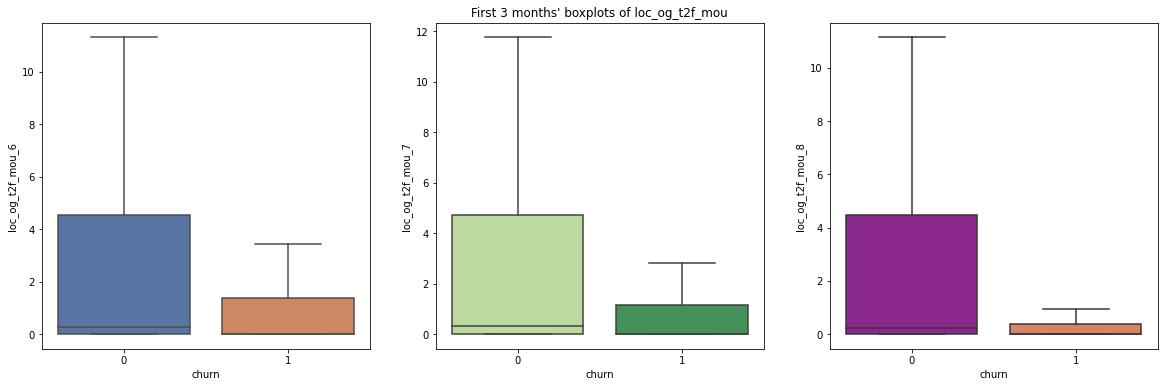

x------------------------------------------------------------------------------------------------------------------------------------------------------x


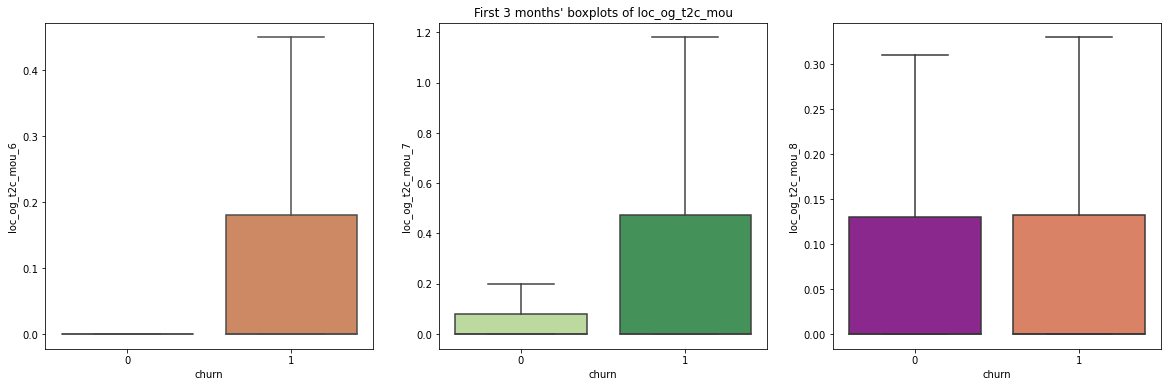

x------------------------------------------------------------------------------------------------------------------------------------------------------x


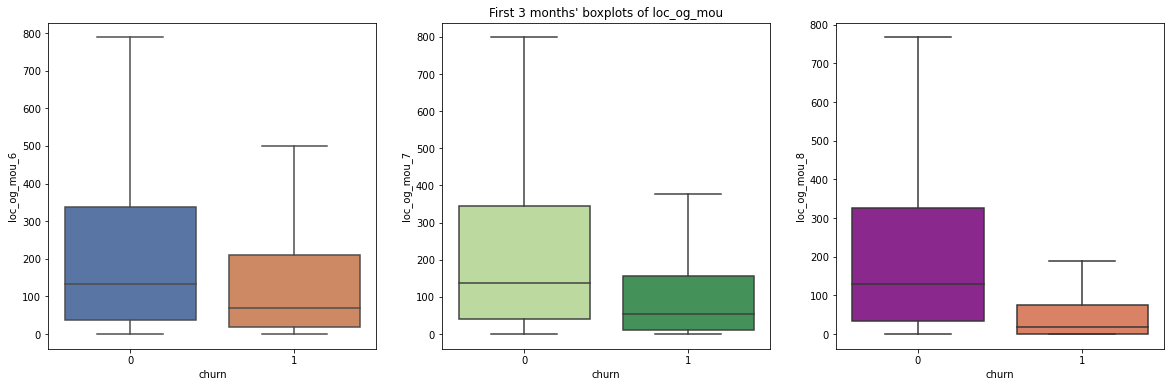

x------------------------------------------------------------------------------------------------------------------------------------------------------x


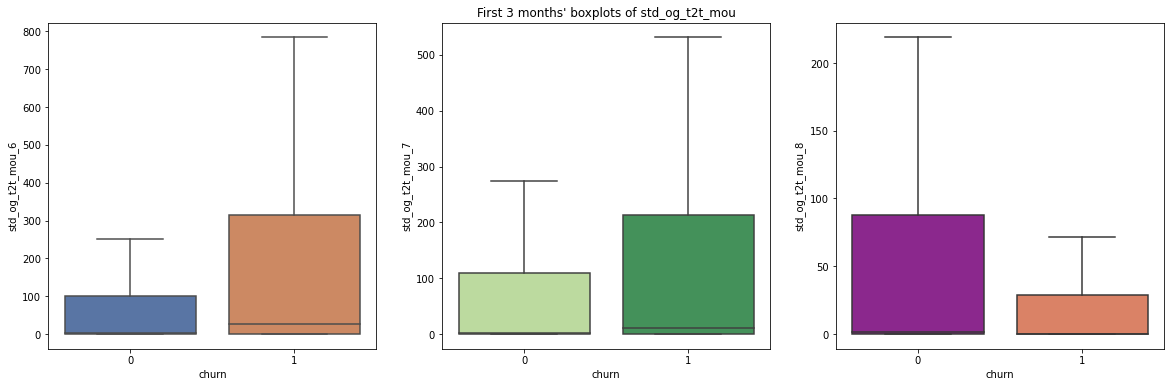

x------------------------------------------------------------------------------------------------------------------------------------------------------x


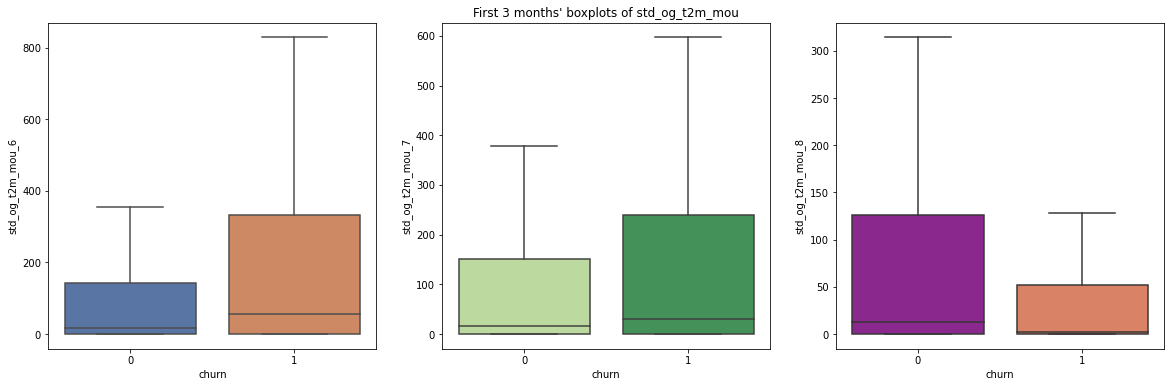

x------------------------------------------------------------------------------------------------------------------------------------------------------x


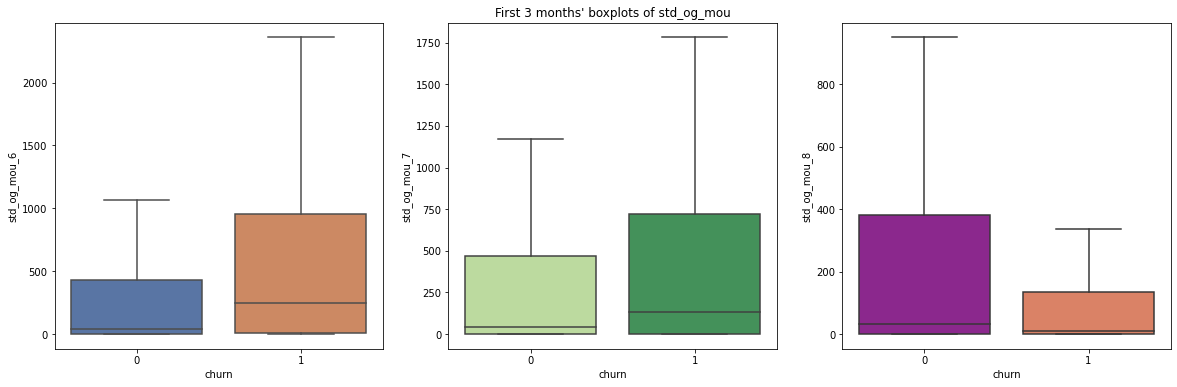

x------------------------------------------------------------------------------------------------------------------------------------------------------x


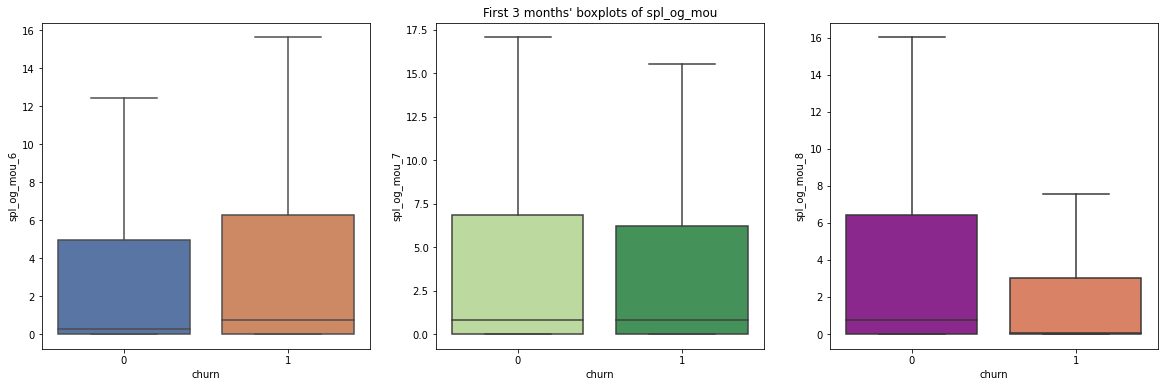

x------------------------------------------------------------------------------------------------------------------------------------------------------x


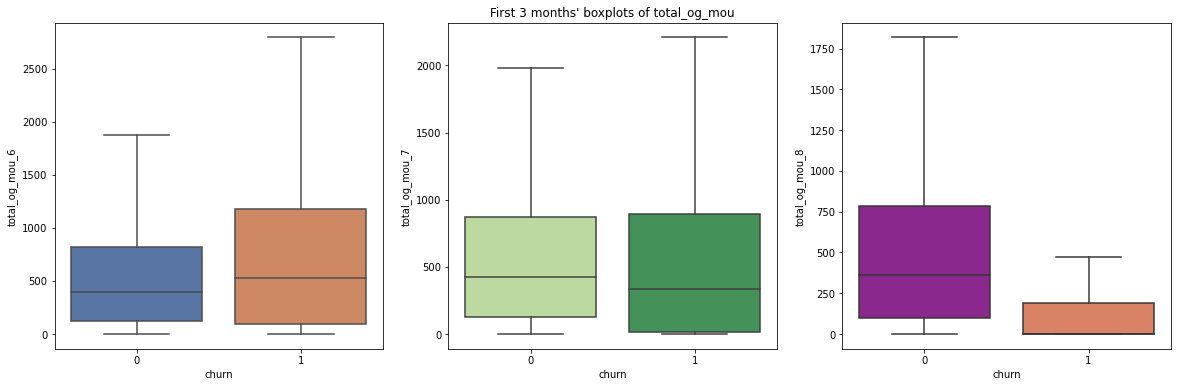

x------------------------------------------------------------------------------------------------------------------------------------------------------x


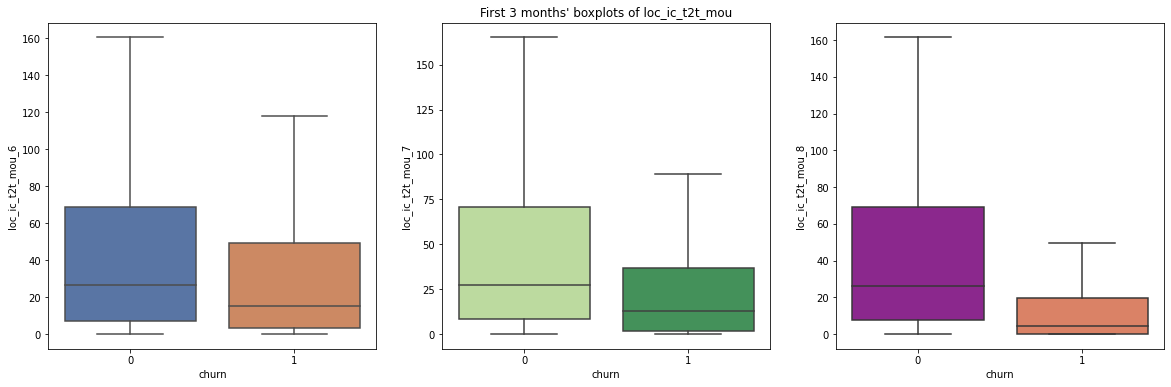

x------------------------------------------------------------------------------------------------------------------------------------------------------x


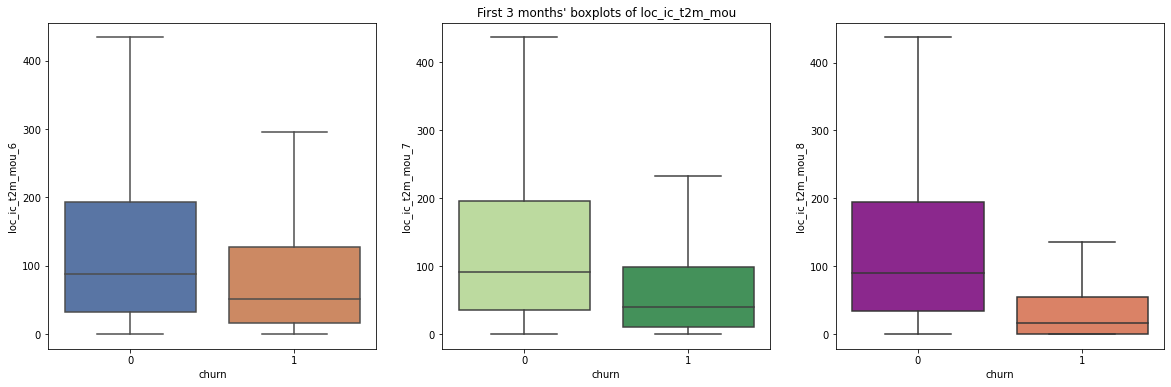

x------------------------------------------------------------------------------------------------------------------------------------------------------x


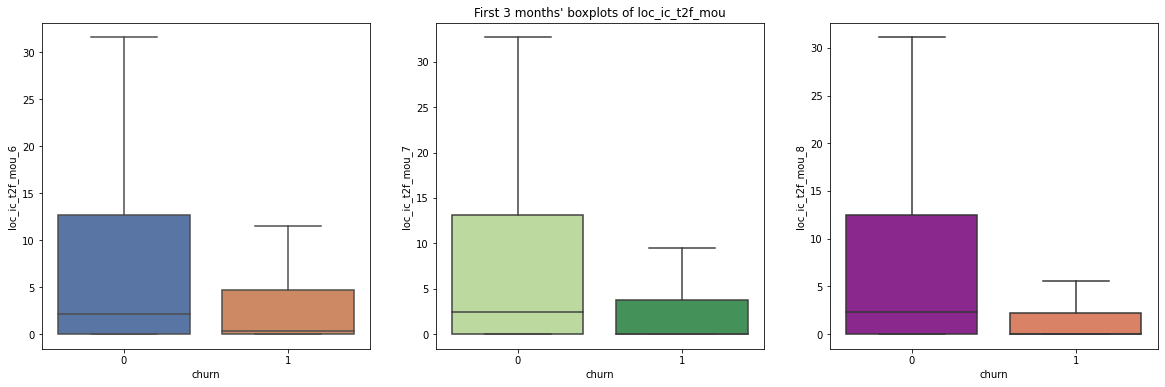

x------------------------------------------------------------------------------------------------------------------------------------------------------x


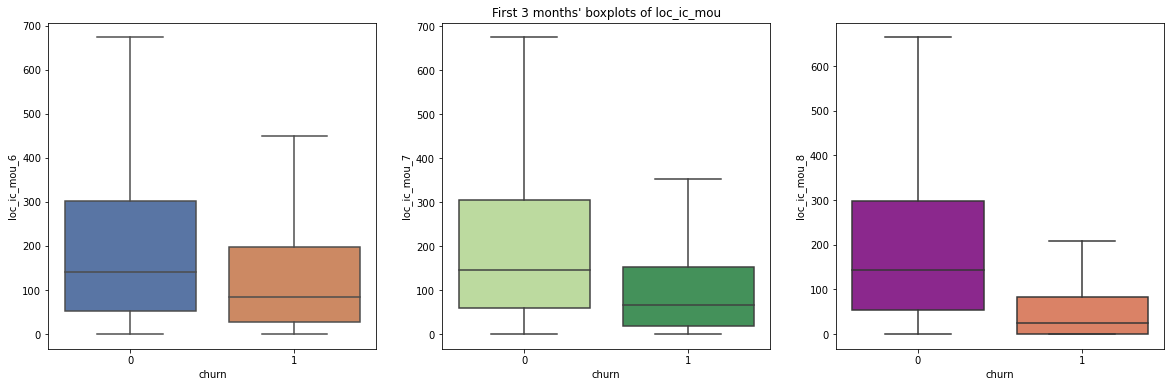

x------------------------------------------------------------------------------------------------------------------------------------------------------x


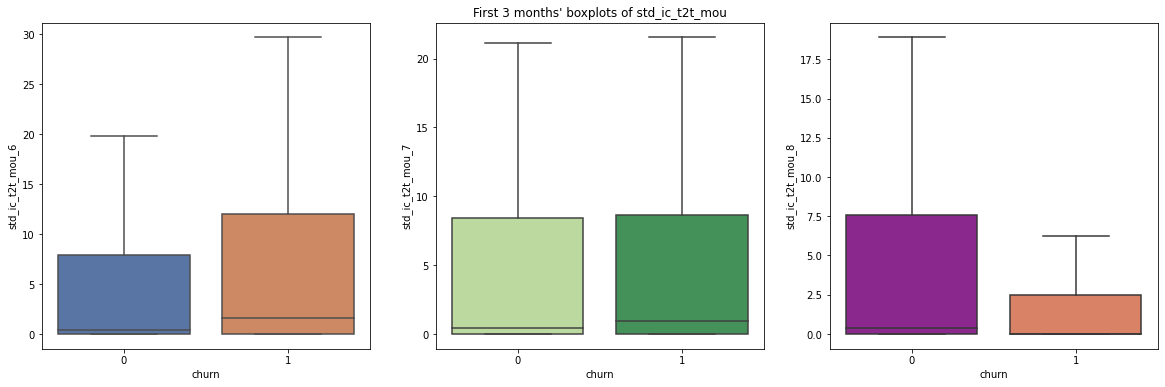

x------------------------------------------------------------------------------------------------------------------------------------------------------x


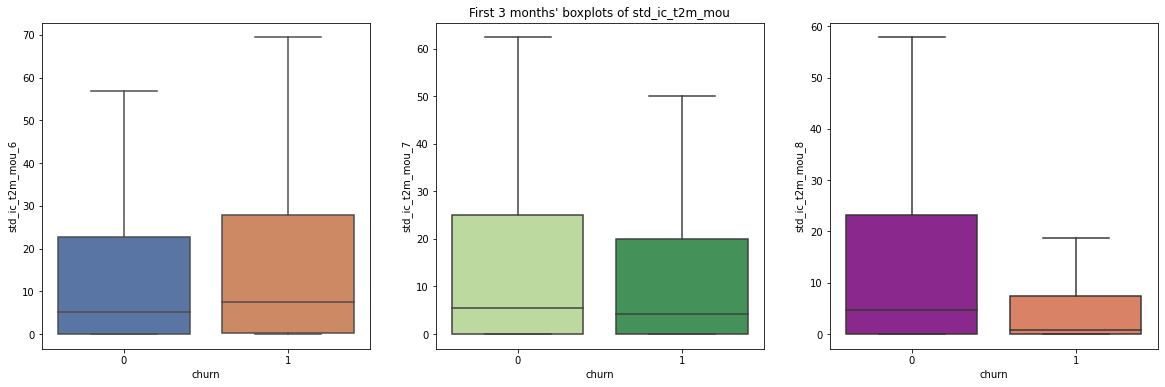

x------------------------------------------------------------------------------------------------------------------------------------------------------x


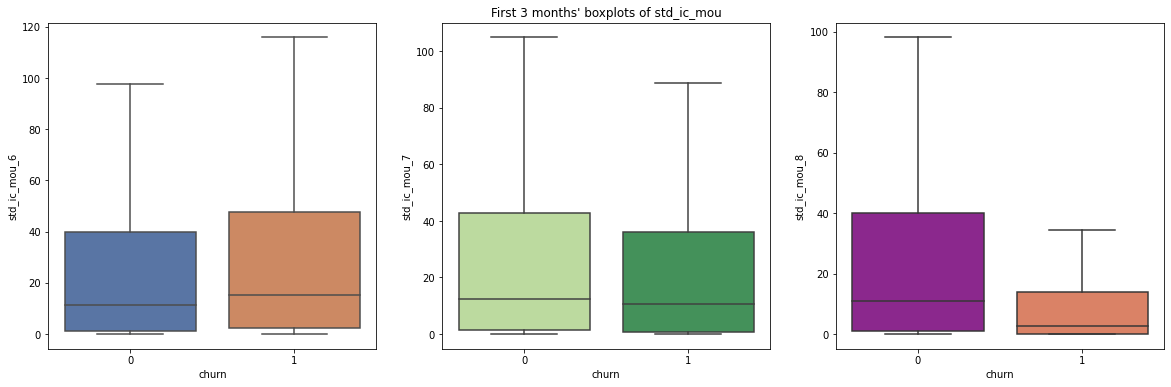

x------------------------------------------------------------------------------------------------------------------------------------------------------x


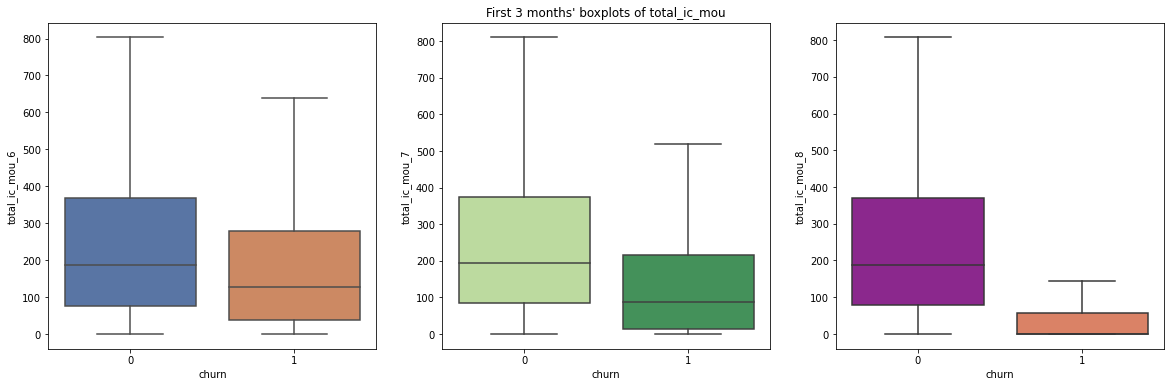

x------------------------------------------------------------------------------------------------------------------------------------------------------x


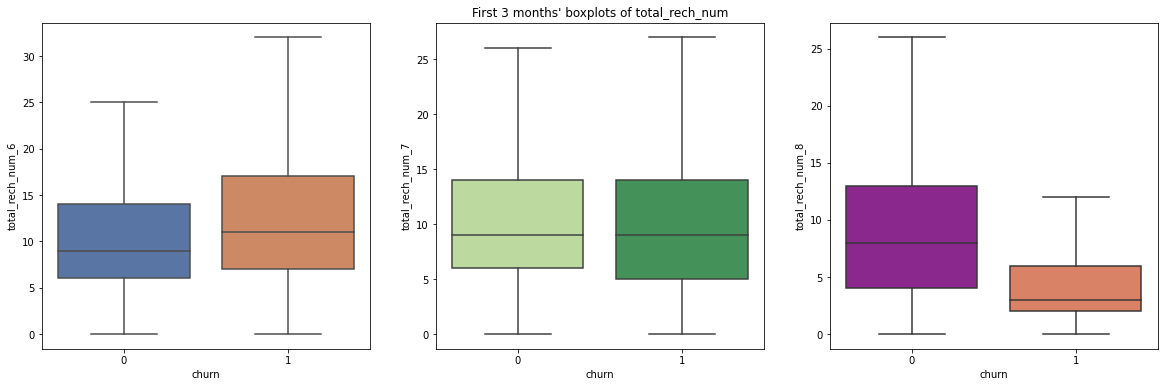

x------------------------------------------------------------------------------------------------------------------------------------------------------x


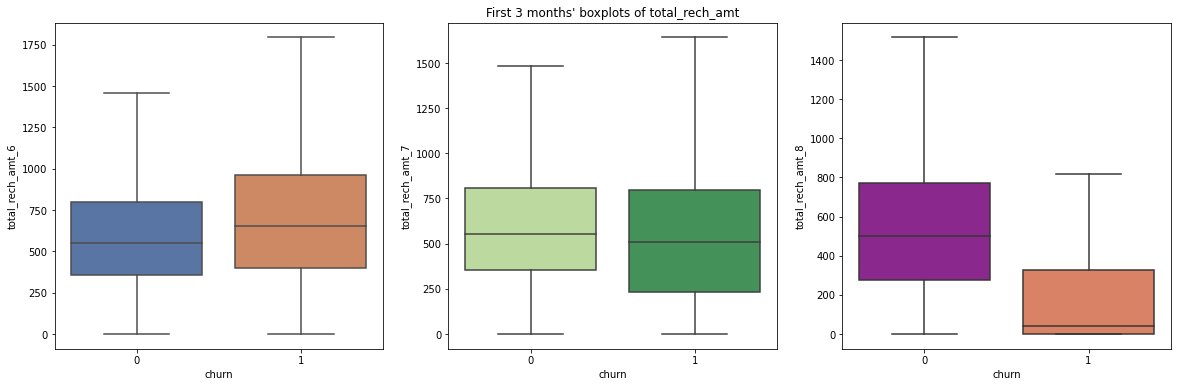

x------------------------------------------------------------------------------------------------------------------------------------------------------x


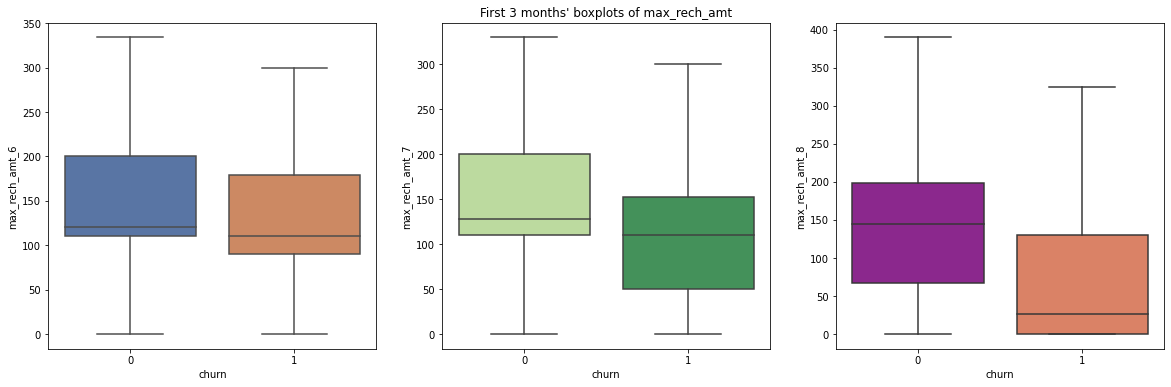

x------------------------------------------------------------------------------------------------------------------------------------------------------x


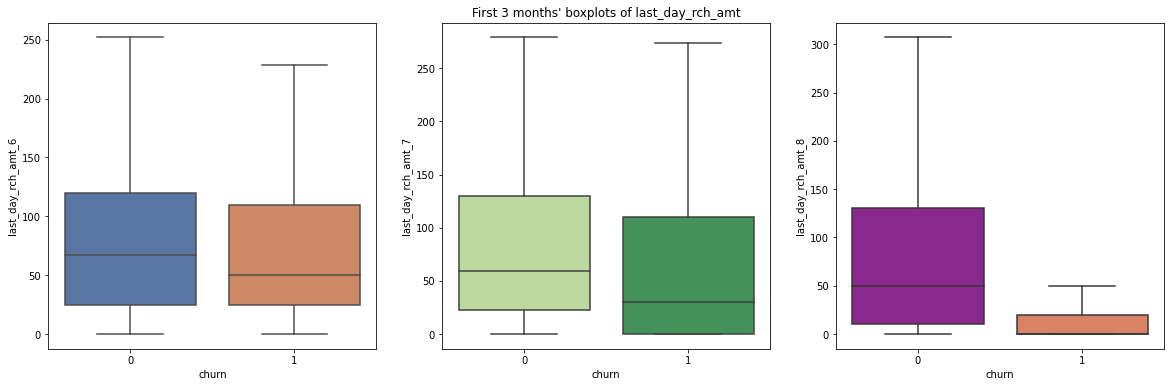

x------------------------------------------------------------------------------------------------------------------------------------------------------x


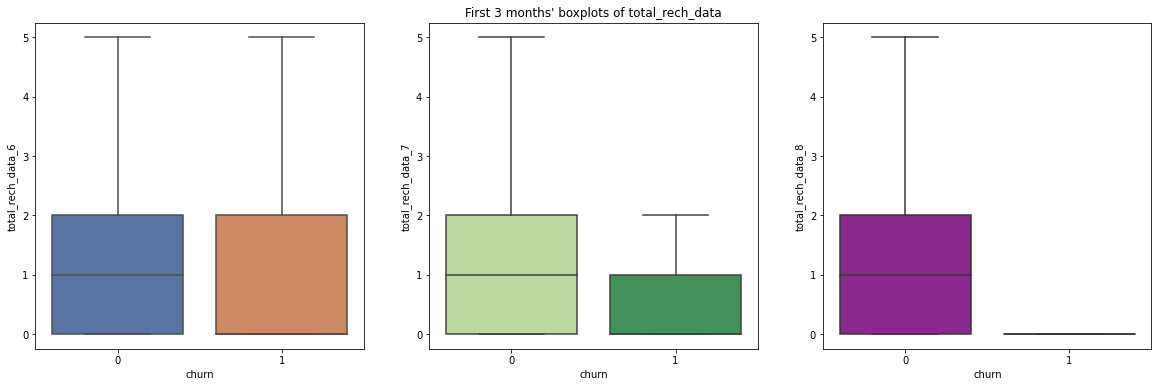

x------------------------------------------------------------------------------------------------------------------------------------------------------x


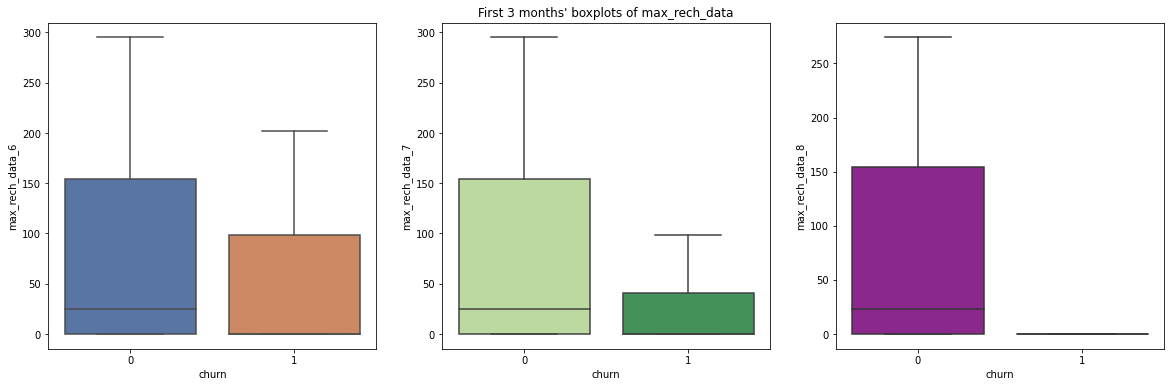

x------------------------------------------------------------------------------------------------------------------------------------------------------x


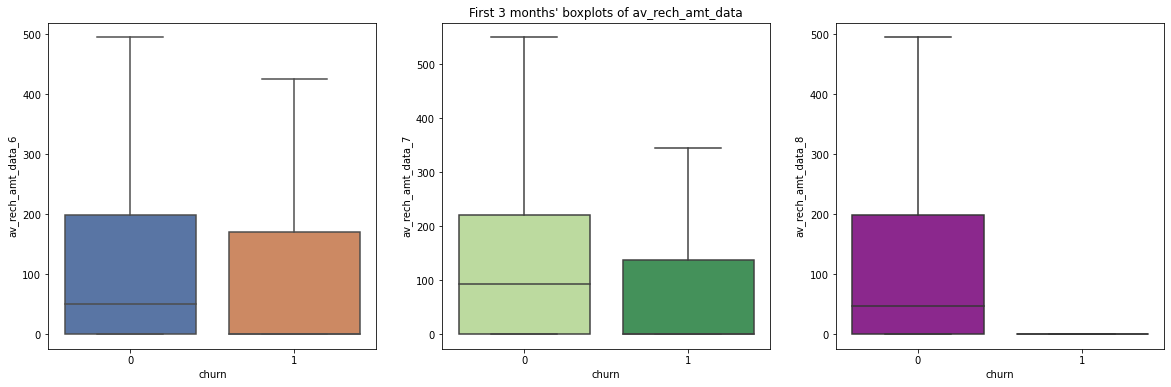

x------------------------------------------------------------------------------------------------------------------------------------------------------x


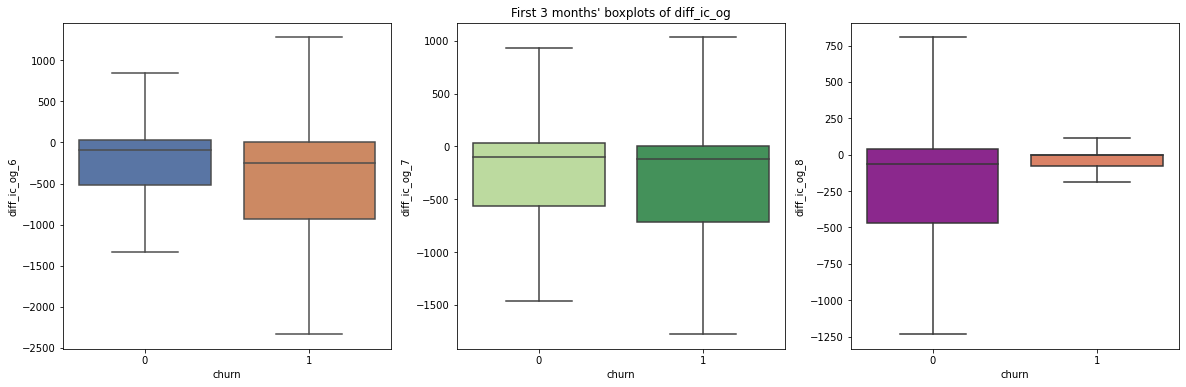

x------------------------------------------------------------------------------------------------------------------------------------------------------x


In [62]:
#updating the boxplotColumns as not all variables display a boxplot without fliers

boxplotColumns = ["arpu", "onnet_mou", 'offnet_mou', 'loc_og_t2t_mou', 'loc_og_t2m_mou', 'loc_og_t2f_mou', 'loc_og_t2c_mou', 'loc_og_mou', 'std_og_t2t_mou', 'std_og_t2m_mou', 'std_og_mou', 'spl_og_mou', 'total_og_mou', 'loc_ic_t2t_mou', 'loc_ic_t2m_mou', 'loc_ic_t2f_mou', 'loc_ic_mou', 'std_ic_t2t_mou', 'std_ic_t2m_mou', 'std_ic_mou', 'total_ic_mou', 'total_rech_num', 'total_rech_amt', 'max_rech_amt', 'last_day_rch_amt', 'total_rech_data', 'max_rech_data', 'av_rech_amt_data', 'diff_ic_og']

for i in boxplotColumns:
  boxplots_noFliers(i)
  print("x" + "-"*150 + "x")

#### Inferences:

**ARPU:    	Average revenue per user**

The revenue looks good during the good phase but reduces by a big margin in the action phase for the churned customers. For the rest of the customers, the revenue is very consistent.

**ONNET:   	All kind of calls within the same operator network**

Clearly, churned customers have a better usage (of calls) during the good phase compared to non-churned customers but, the usage reduces drastically during the action phase.

**OFFNET:    	All kind of calls outside the operator T network**

It is noticeable that both set of customers have a good amount of usage during the first two months. During the third month, the churned customers clearly reduce the amount of usage (calls).

**Location based variables:**

**Loc_og_t2t_mou**: usage gradually keeps decreasing in each month for the churned customers.

**Loc_og_t2m_mou**: very similar trend to the previous feature exhibited here as well.

**Loc_og_t2f_mou**: This variable clearly shows that even during the good phase, the churned customers tend to reduce their usage of calls (operator to fixed lines)

**STD based variables:**

Std_ic_t2t_mou, std_ic_t2t_mou, std_ic_t2m_mou, std_ic_mou: For churned customers, the usage reduces to around half of the original usage during the action phase. In some instances, there is reduction in usage in the second month itself. 

For non-churned customers, the usage remains mostly contant.

**TOTAL_IC_MOU**: There is reduction in the number of incoming calls in the action phase in the case of churned customers, which could indicate the customer had already started using a different number as their daily driver.

**RECHARGE based variables:**

Total_rech_amt, max_rech_amt, last_day_rech_amt, total_rech_data, max_rech_data, av_rech_amt_data:  All these variables (for the churned customers), show a drastic fall in recharge amount by the action phase. It makes sense as the customer would not wish to spend any more money on services.


## 3.3 Barplots

In [63]:
#creating a custom function for plotting barplots

def barplots(y):
  plt.figure(figsize = [20, 6])
  data = telecom_data

  plt.subplot(1, 3, 1)
  sns.barplot(data = telecom_data, x = "churn", y = y+"_6", palette = "husl")

  plt.subplot(1, 3, 2)
  plt.title("First 3 months' boxplots of " + y)
  sns.barplot(data = telecom_data, x = "churn", y = y+"_7", palette = "ch:s=.25,rot=-.25")

  plt.subplot(1, 3, 3)
  sns.barplot(data = telecom_data, x = "churn", y = y+"_8", palette = "flare")
  plt.show()

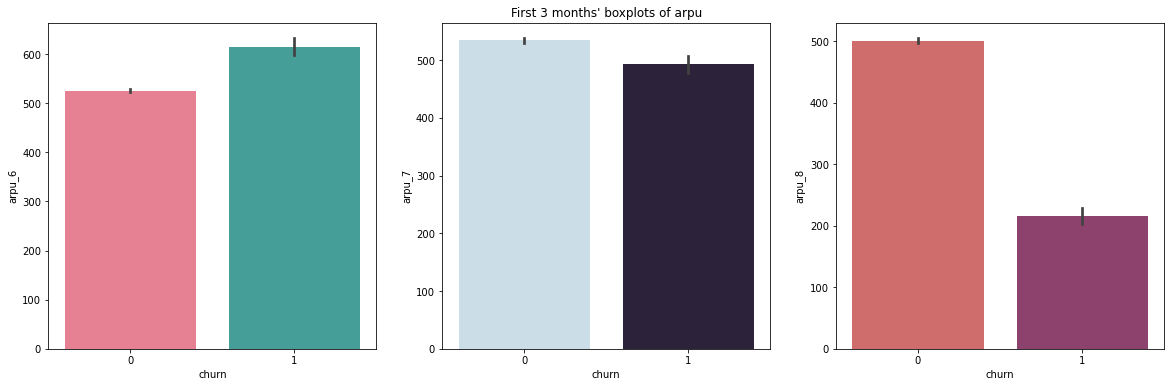

x------------------------------------------------------------------------------------------------------------------------------------------------------x


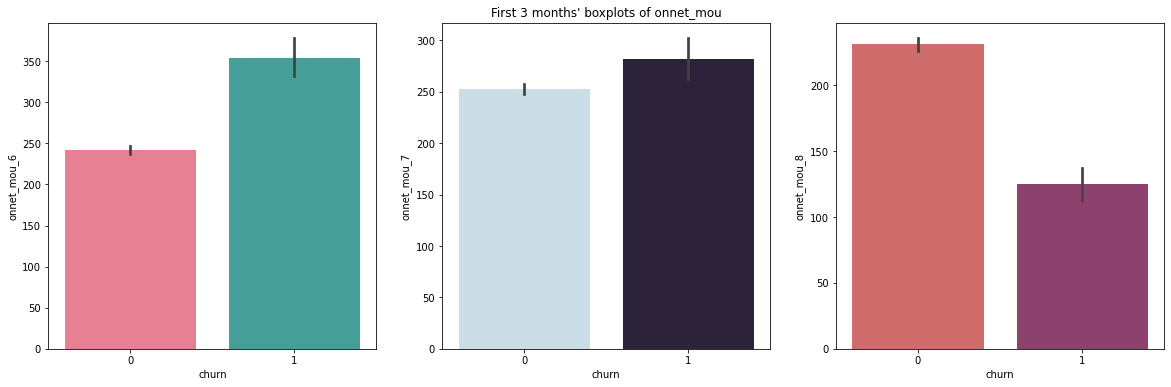

x------------------------------------------------------------------------------------------------------------------------------------------------------x


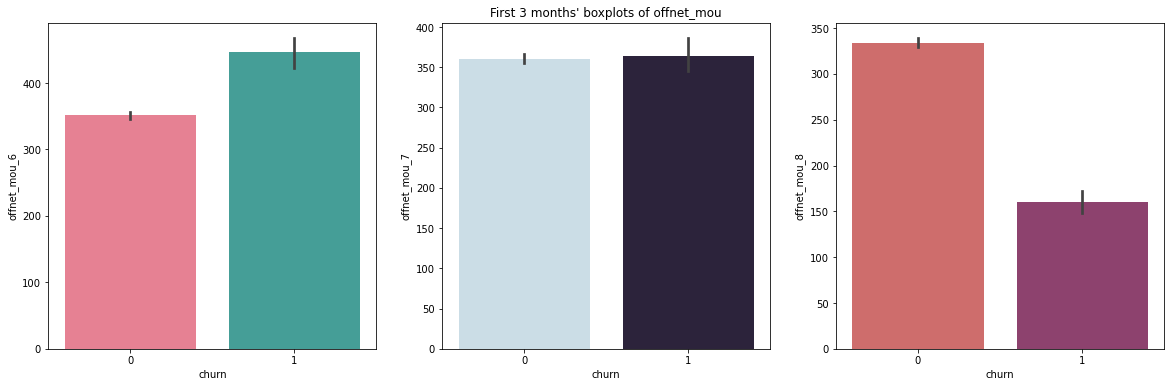

x------------------------------------------------------------------------------------------------------------------------------------------------------x


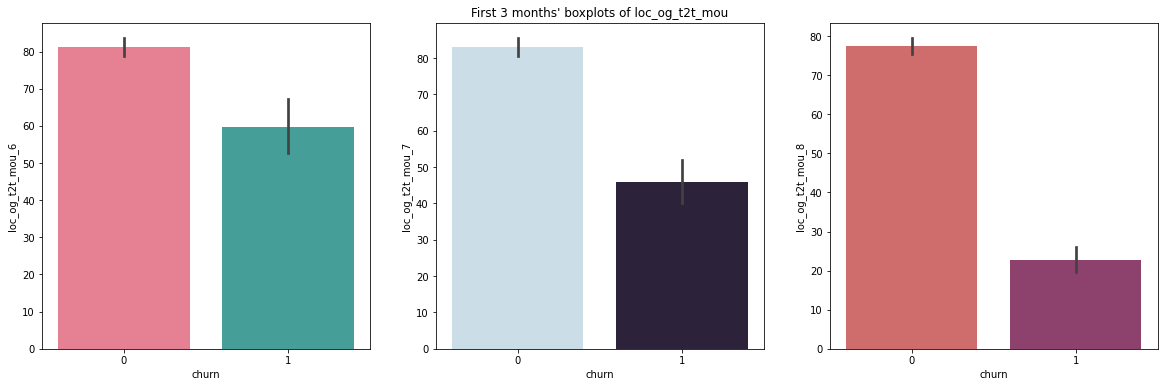

x------------------------------------------------------------------------------------------------------------------------------------------------------x


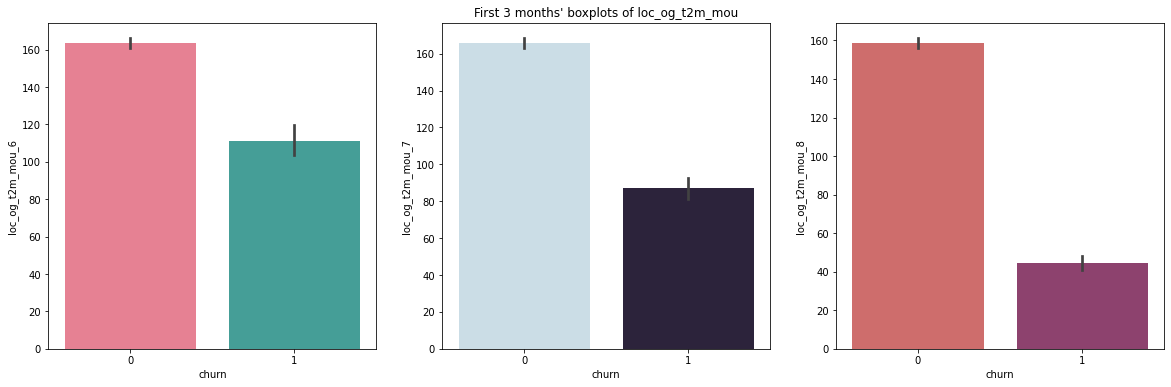

x------------------------------------------------------------------------------------------------------------------------------------------------------x


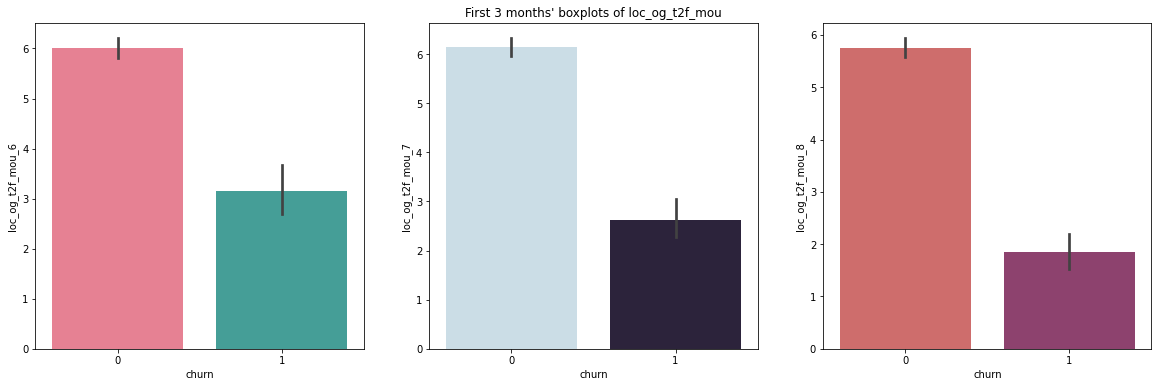

x------------------------------------------------------------------------------------------------------------------------------------------------------x


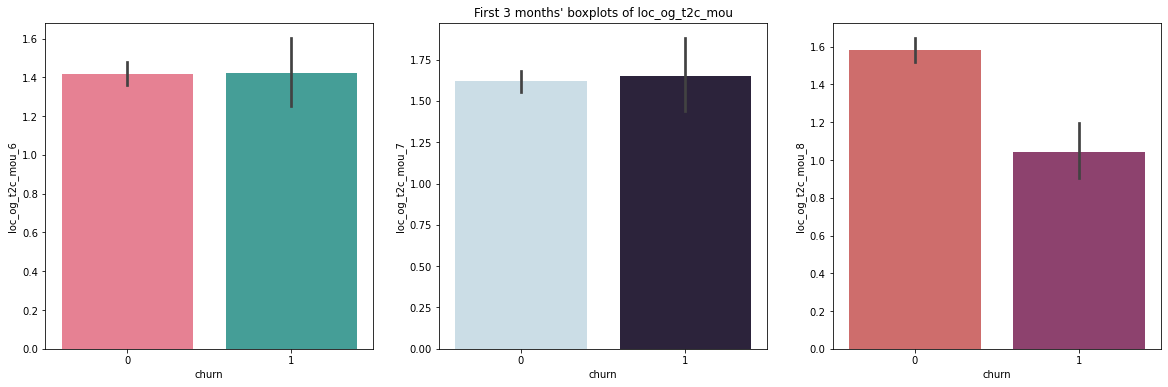

x------------------------------------------------------------------------------------------------------------------------------------------------------x


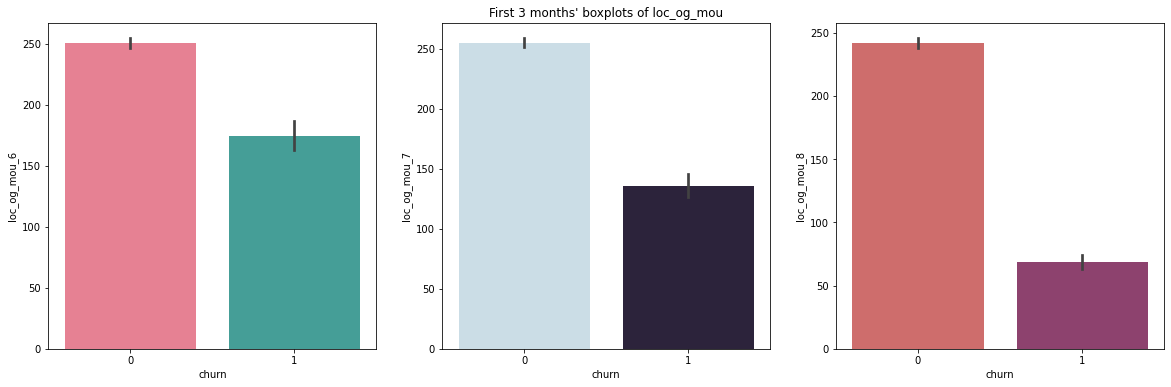

x------------------------------------------------------------------------------------------------------------------------------------------------------x


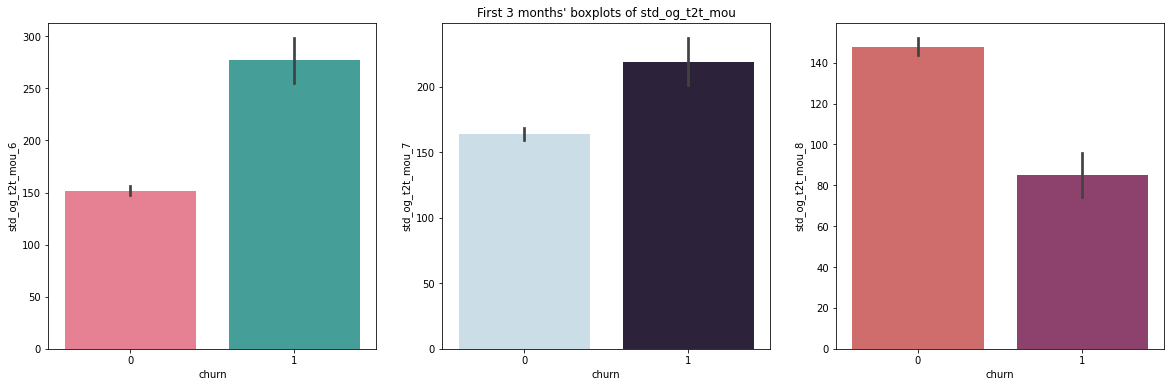

x------------------------------------------------------------------------------------------------------------------------------------------------------x


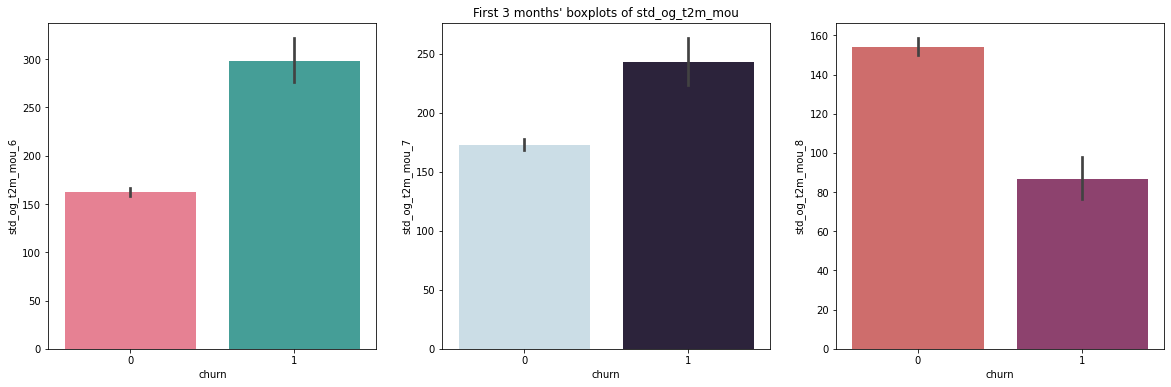

x------------------------------------------------------------------------------------------------------------------------------------------------------x


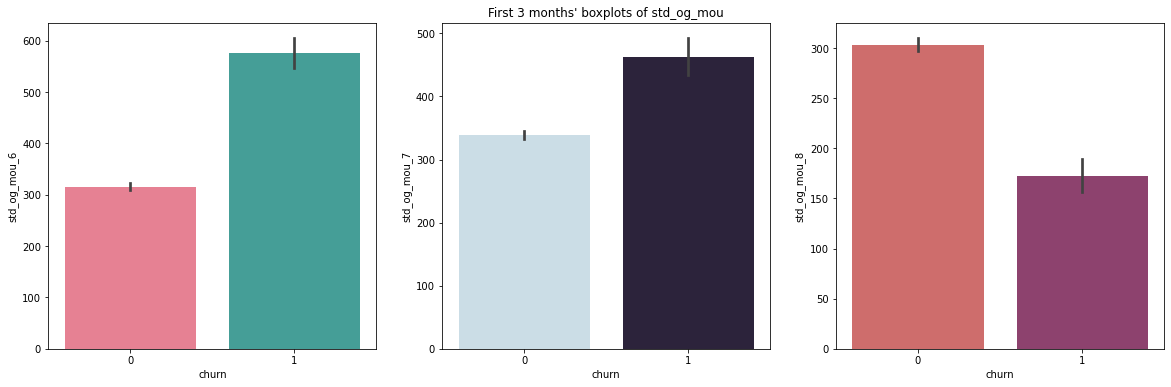

x------------------------------------------------------------------------------------------------------------------------------------------------------x


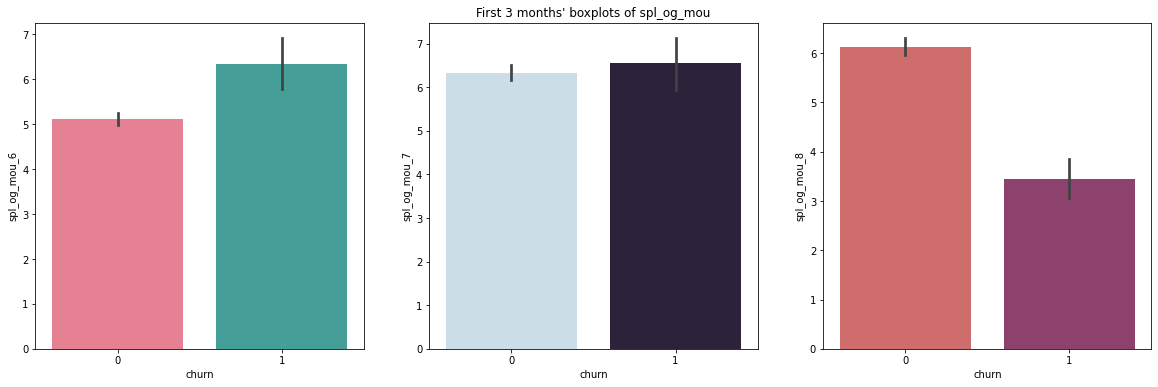

x------------------------------------------------------------------------------------------------------------------------------------------------------x


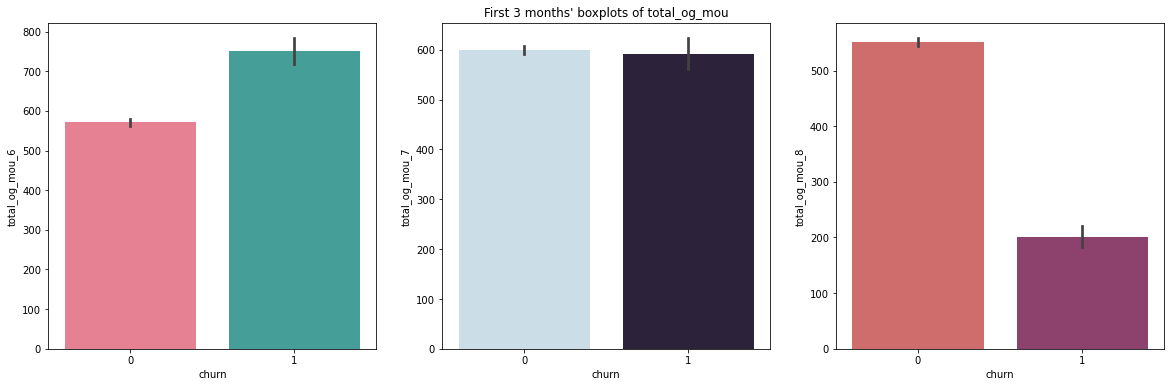

x------------------------------------------------------------------------------------------------------------------------------------------------------x


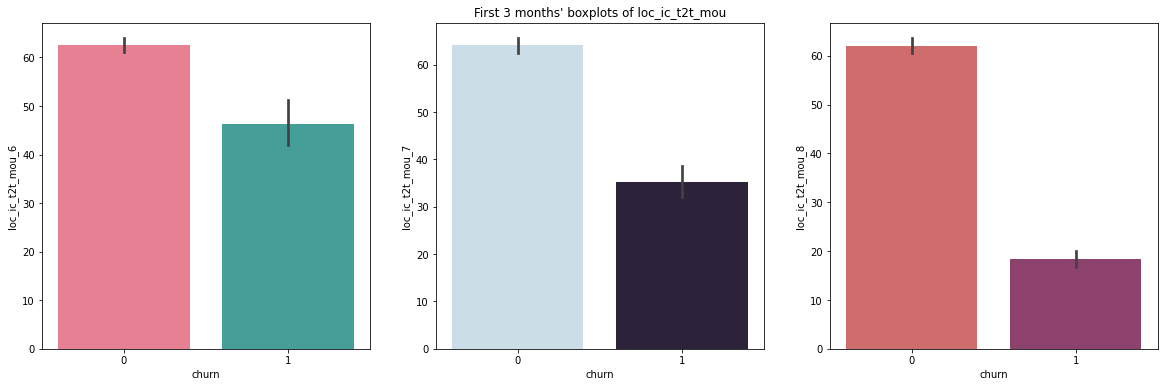

x------------------------------------------------------------------------------------------------------------------------------------------------------x


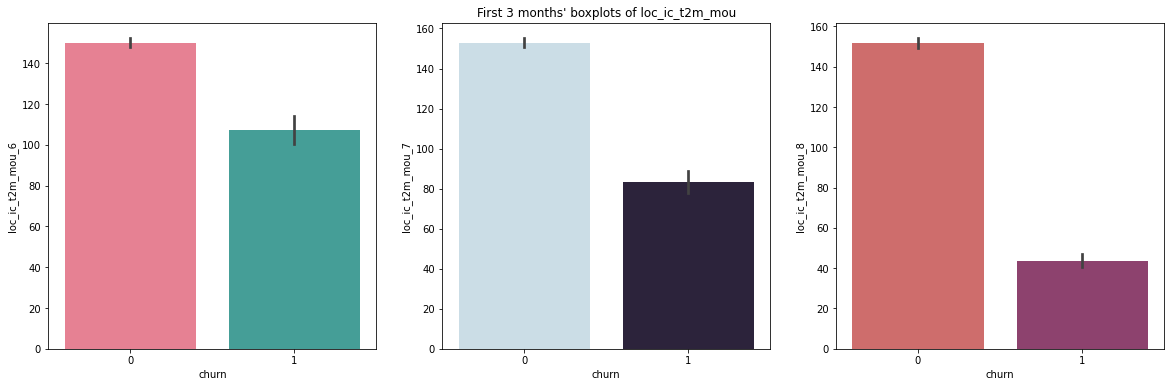

x------------------------------------------------------------------------------------------------------------------------------------------------------x


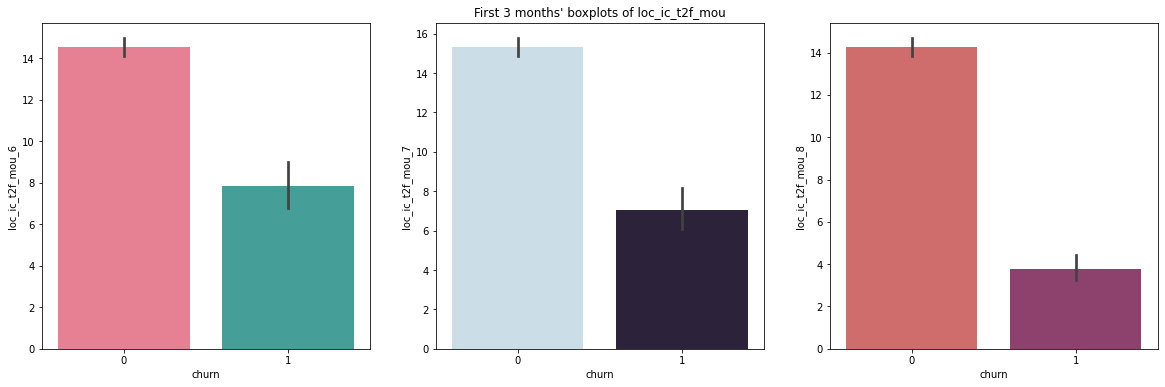

x------------------------------------------------------------------------------------------------------------------------------------------------------x


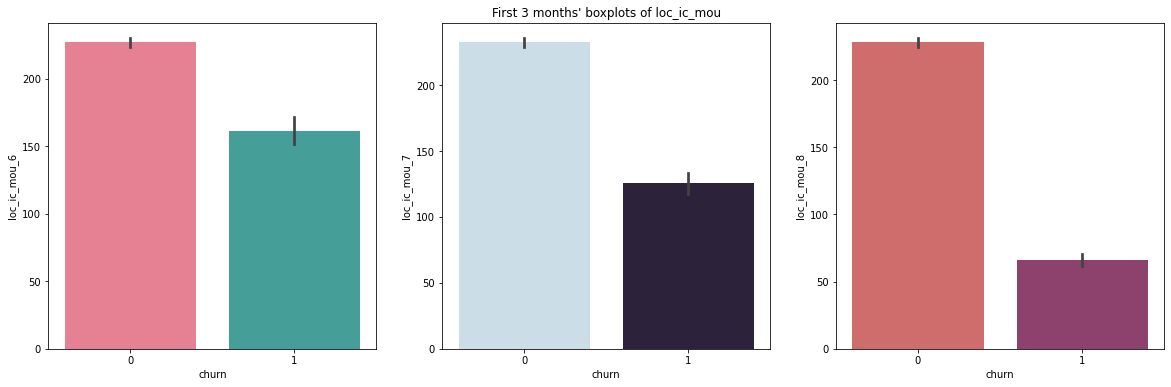

x------------------------------------------------------------------------------------------------------------------------------------------------------x


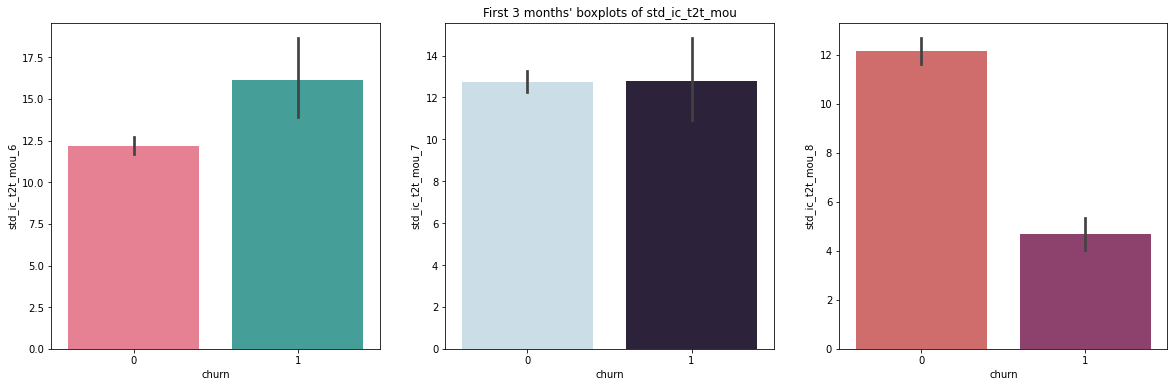

x------------------------------------------------------------------------------------------------------------------------------------------------------x


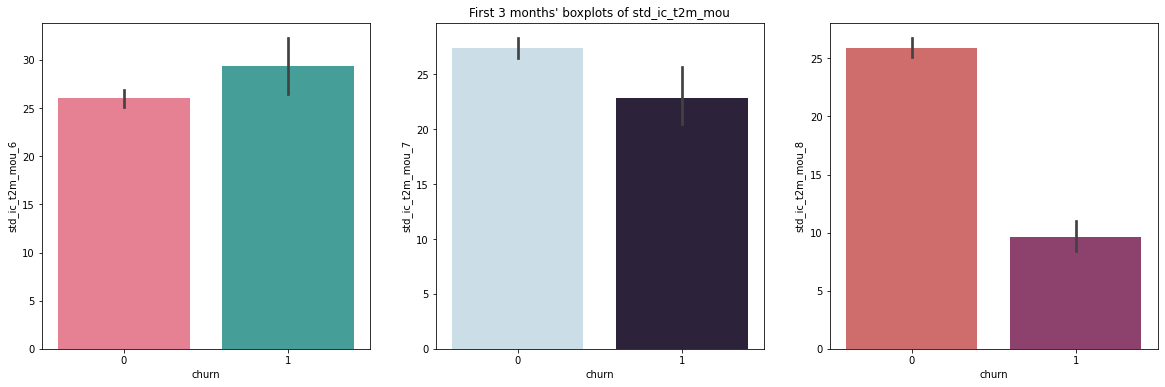

x------------------------------------------------------------------------------------------------------------------------------------------------------x


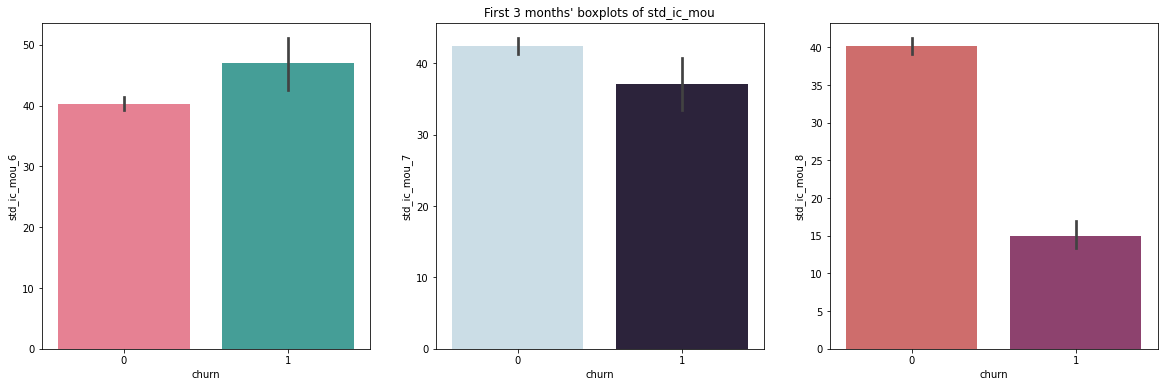

x------------------------------------------------------------------------------------------------------------------------------------------------------x


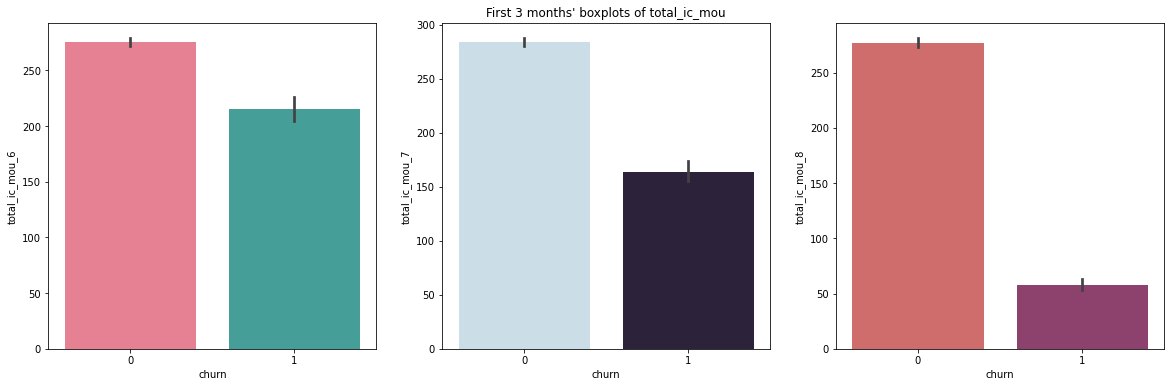

x------------------------------------------------------------------------------------------------------------------------------------------------------x


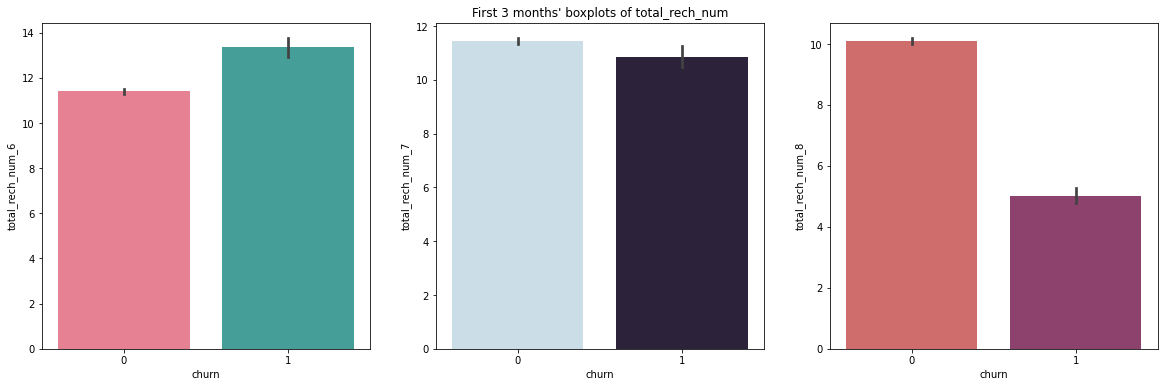

x------------------------------------------------------------------------------------------------------------------------------------------------------x


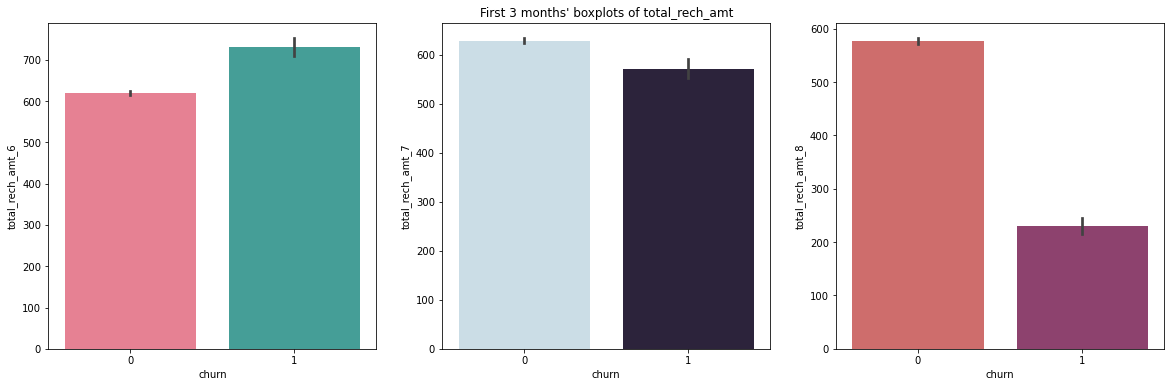

x------------------------------------------------------------------------------------------------------------------------------------------------------x


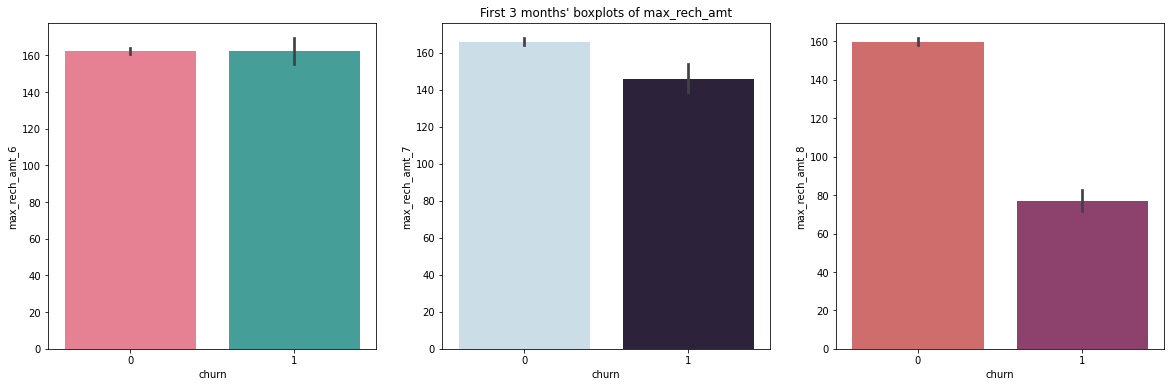

x------------------------------------------------------------------------------------------------------------------------------------------------------x


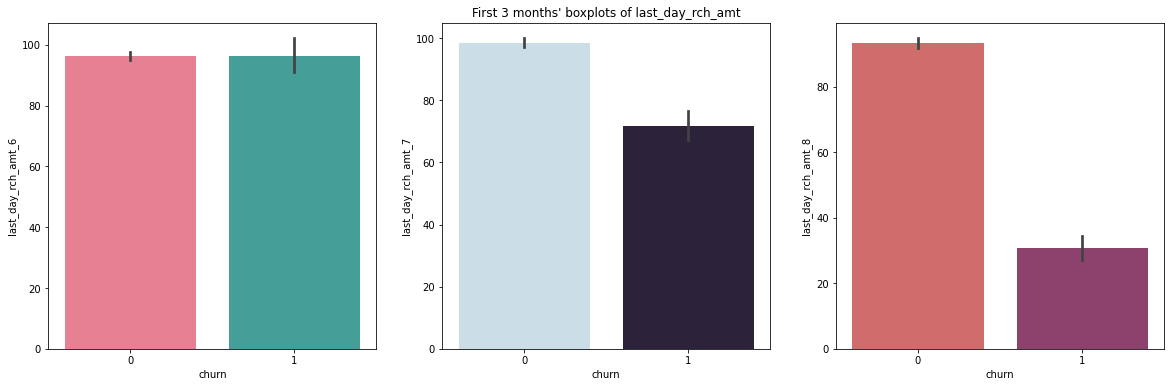

x------------------------------------------------------------------------------------------------------------------------------------------------------x


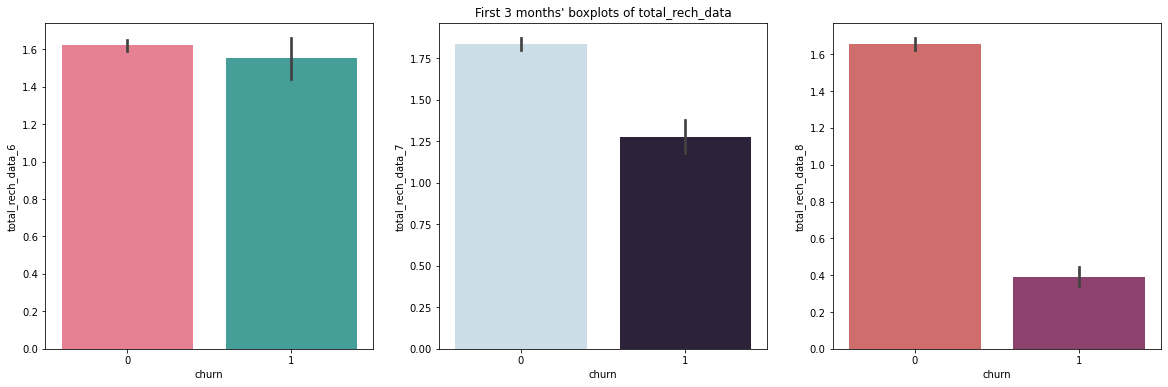

x------------------------------------------------------------------------------------------------------------------------------------------------------x


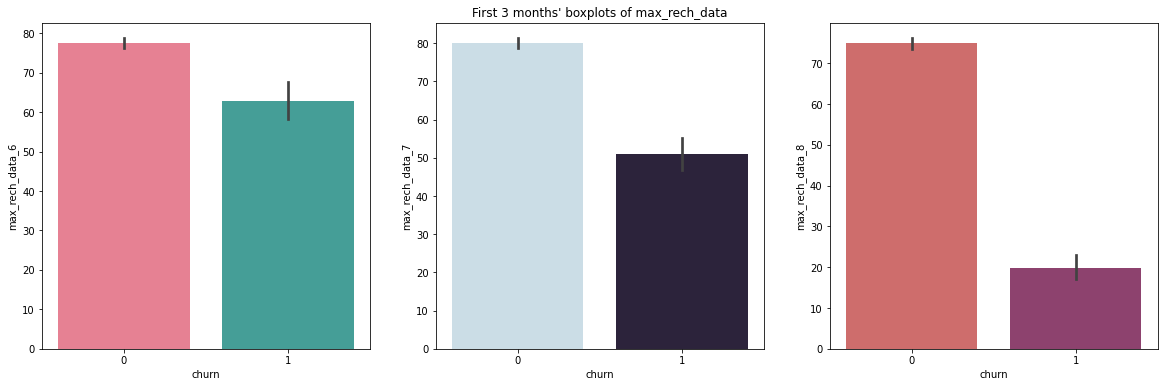

x------------------------------------------------------------------------------------------------------------------------------------------------------x


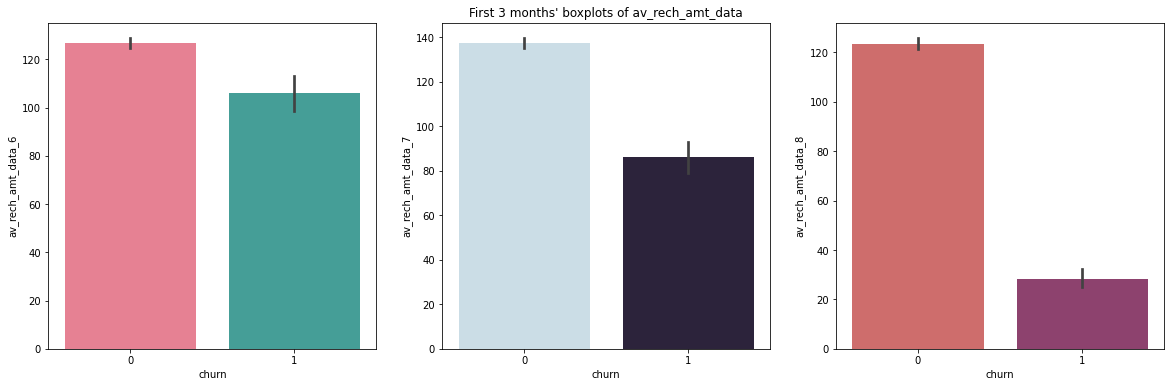

x------------------------------------------------------------------------------------------------------------------------------------------------------x


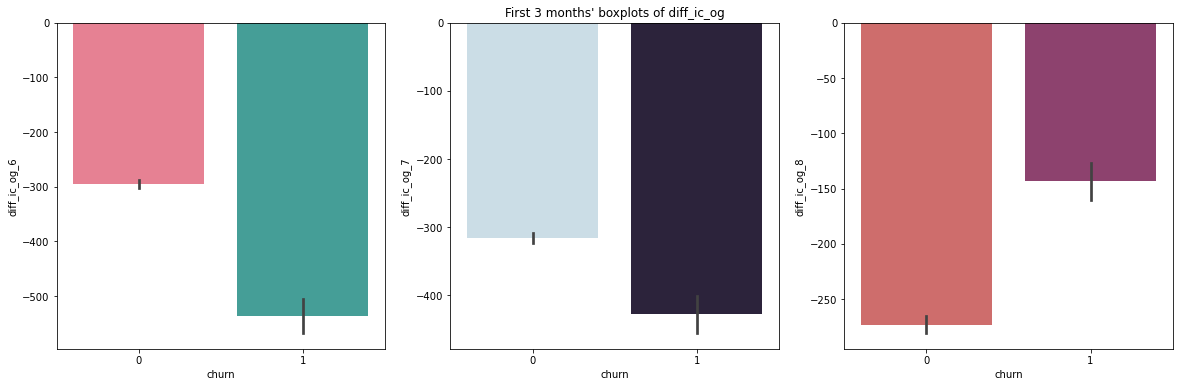

x------------------------------------------------------------------------------------------------------------------------------------------------------x


In [64]:
for i in boxplotColumns:
  barplots(i)
  print("x" + "-"*150 + "x")

#### Inferences:

**Arpu (average revenue per user)**: We can see the revenue drops for the churned customers drastically during the action phase.
Onnet_mou (All kind of calls within the same operator network): The amount of calls to the same network remained constant in the good phase but has been reduced by around half in the action phase. For the non churn customers, the amount of calls has noticeably increased every month.


**OFFNET    	All kind of calls outside the operator T network**

The behaviour here for the churned customers looks similar to the previous feature (onnet_mou). The churned customers’ calls in the good phase is high but reduces to around half during the action phase. As for the non-churned customers, the amount of calls have gradually increased (highest during the action phase).

**ROAM	Indicates that customer is in roaming zone during the call**

For both incoming and outgoing: Interesting patter to observe here. For the churned customers, the amount of calls in roaming does not change in any of the phases. This could indicate they have already decide to churn and attend only the required calls (hence there’s no change even during the action phase). On the other hand, for the non-churned customers, the amount of calls in roaming remains low.

**LOC	Local calls - within same telecom circle**

This is true for every variation of location based variables: As we can notice, the usage reduces gradually for customers who have churned but remains constant for others.

**STD	STD calls - outside the calling circle**

For the non-churned customers, STD based usage either gradually increases or remain constant. For the churned customers, the usage reduces in the action phase. 

**ISD    	ISD calls**

For churned customers, the usage of ISD called remained constant throughout (it was more than non-churned customers until the action phase). Whereas for the non-churned customers, it increased gradually up to the level of the churned customers.

**SPL   	Special calls**

Usage of special calls gradually increased for the non-churn customers, whereas for the churned customers, it reduced to around half of the good phases’ usage in the action phase.
Total_OG_MOU
The total outgoing minutes of usage for churned customers reduced drastically in the action phase. For the non-customers, it gradually increased and overtook their counterparts.

**Location based variables**
The incoming call usage (T2T, T2M, T2F) for the non-churned customers remained the same throughout. But for the churned customers, there is a visible reduction in each phase.

**Total Recharge**
Total_rech_num: Churned customers’ have a reduction in this regard in the action phase. No major change for other customers.

Total_rech_amt: Very similar noticeable trend compared to the previous variable.
Max_rech_amt: Very clearly, we can see a reduction in the amount as the months go by for the churned customers.

Last_day_rch_amt: We can see that very few customers who churned pay any amount on the last day of their usage.

Rest of the variables related to recharge also follow a very similar trend as noted above.

**Internet usage:**
For the non churned customers, the volume of internet usage remained constant. But for the churned customers, there’s a reduction in the 2nd month of usage and a major fall in usage in the action phase.

When looking at the difference of incoming calls vs outgoing calls, we can see that the churned customers stop making outgoing calls in the action phase. But the trend is in reverse for the non-churned customers.

Difference between volume of data usage of 3G and 2G shows a similar story. The usage reduces further and further for the churned customers.


# 4. Model Building

## 4.1 Train and Test Split and Handling Imbalanced Dataset

Text(0.5, 1.0, 'churned vs non-churned')

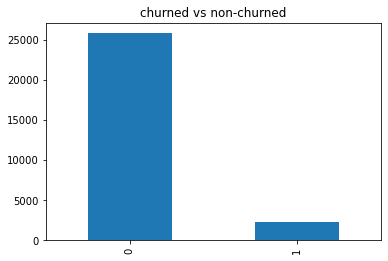

In [65]:
#checking for data imbalance
telecom_data['churn'].value_counts().plot(kind = 'bar').set_title('churned vs non-churned')

The data is heavily imbalanced and this will affect our model building process. We can overcome this using a library called SMOTE.

In [66]:
from imblearn.over_sampling import SMOTE #smote helps in balancing the dataset that is originally imbalanced
from sklearn.model_selection import train_test_split

y = telecom_data.churn #adding the target variable in y
X = telecom_data.drop('churn', axis = 1) #adding all the independent variables in X

X_scaled = scale(X) #scaling all the independent variables

#applying train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, train_size=0.7, test_size=0.3, random_state=100)

sm = SMOTE(random_state = 100, sampling_strategy = 1.0)
#as per the documentation:
#sampling_strategy: Sampling information to resample the data set. Default value is auto
#We have passed a float value, which means it corresponds to the desired ratio of the number of 
#samples in the minority class over the number of samples in the majority class after resampling.

X_train, y_train = sm.fit_resample(X_train, y_train)

Text(0.5, 1.0, 'churned')

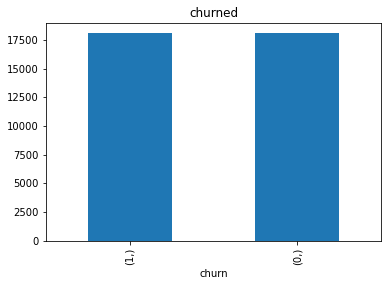

In [67]:
pd.DataFrame(y_train).value_counts().plot(kind='bar').set_title('churned')

As we can see now, the data is balanced after using SMOTE.

## 4.2 Performing Principal Component Analysis (PCA) for feature reduction

In [68]:
#creating a funtion to perform PCA

def perform_PCA(X):
    
    pca = PCA(svd_solver = 'randomized', random_state = 100)
    #as per the documentation:
    #svd_solver (if it's randomized) = run randomized SVD by the method of Halko et al.

    pca.fit(X)
    
    fig = plt.figure(figsize = [16, 6])

    plt.plot(np.cumsum(pca.explained_variance_ratio_)) #plotting the cumulative variance against the number of components using a screeplot
    plt.xlabel("Number of Components")
    plt.ylabel("Cumulative Variance")
    plt.grid(True) #for square grids in the plot
    
    plt.show()

In [69]:
#creating a function perform incremental PCA

def plot_incremental_PCA(X_train, y_train, components):
    
    # Incremental PCA is efficient and saves time when dealing with large datasets (as is the case here)

    pca_final = IncrementalPCA(n_components = components) #number of components to keep

    X_train_pca = pca_final.fit_transform(X_train) 
    X_test_pca = pca_final.transform(X_test)

    X_train_pca = pd.DataFrame(data = X_train_pca)
    X_test_pca = pd.DataFrame(data = X_test_pca)

    print(X_train_pca.shape)
    print(y_train.shape)
    print(X_test_pca.shape)
    print(y_test.shape)
    
    #creating heatmap for the principal components
    corrmat = np.corrcoef(X_train_pca.transpose())

    #plotting the heatmap
    plt.figure(figsize = [25,25])
    sns.heatmap(corrmat, annot = True)
    plt.show()
    
    corrmat_nodiag = corrmat - np.diagflat(corrmat.diagonal())
    print("max corr:", corrmat_nodiag.max(), ", min corr: ", corrmat_nodiag.min())

    return X_train_pca, X_test_pca

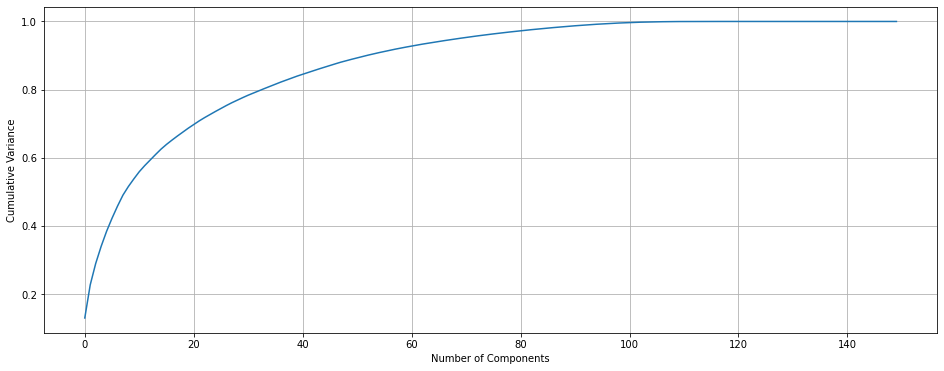

In [70]:
perform_PCA(X_train)

* We can see that around 50 components explain 90% of variance in our dataset

(36112, 50)
(36112,)
(8425, 50)
(8425,)


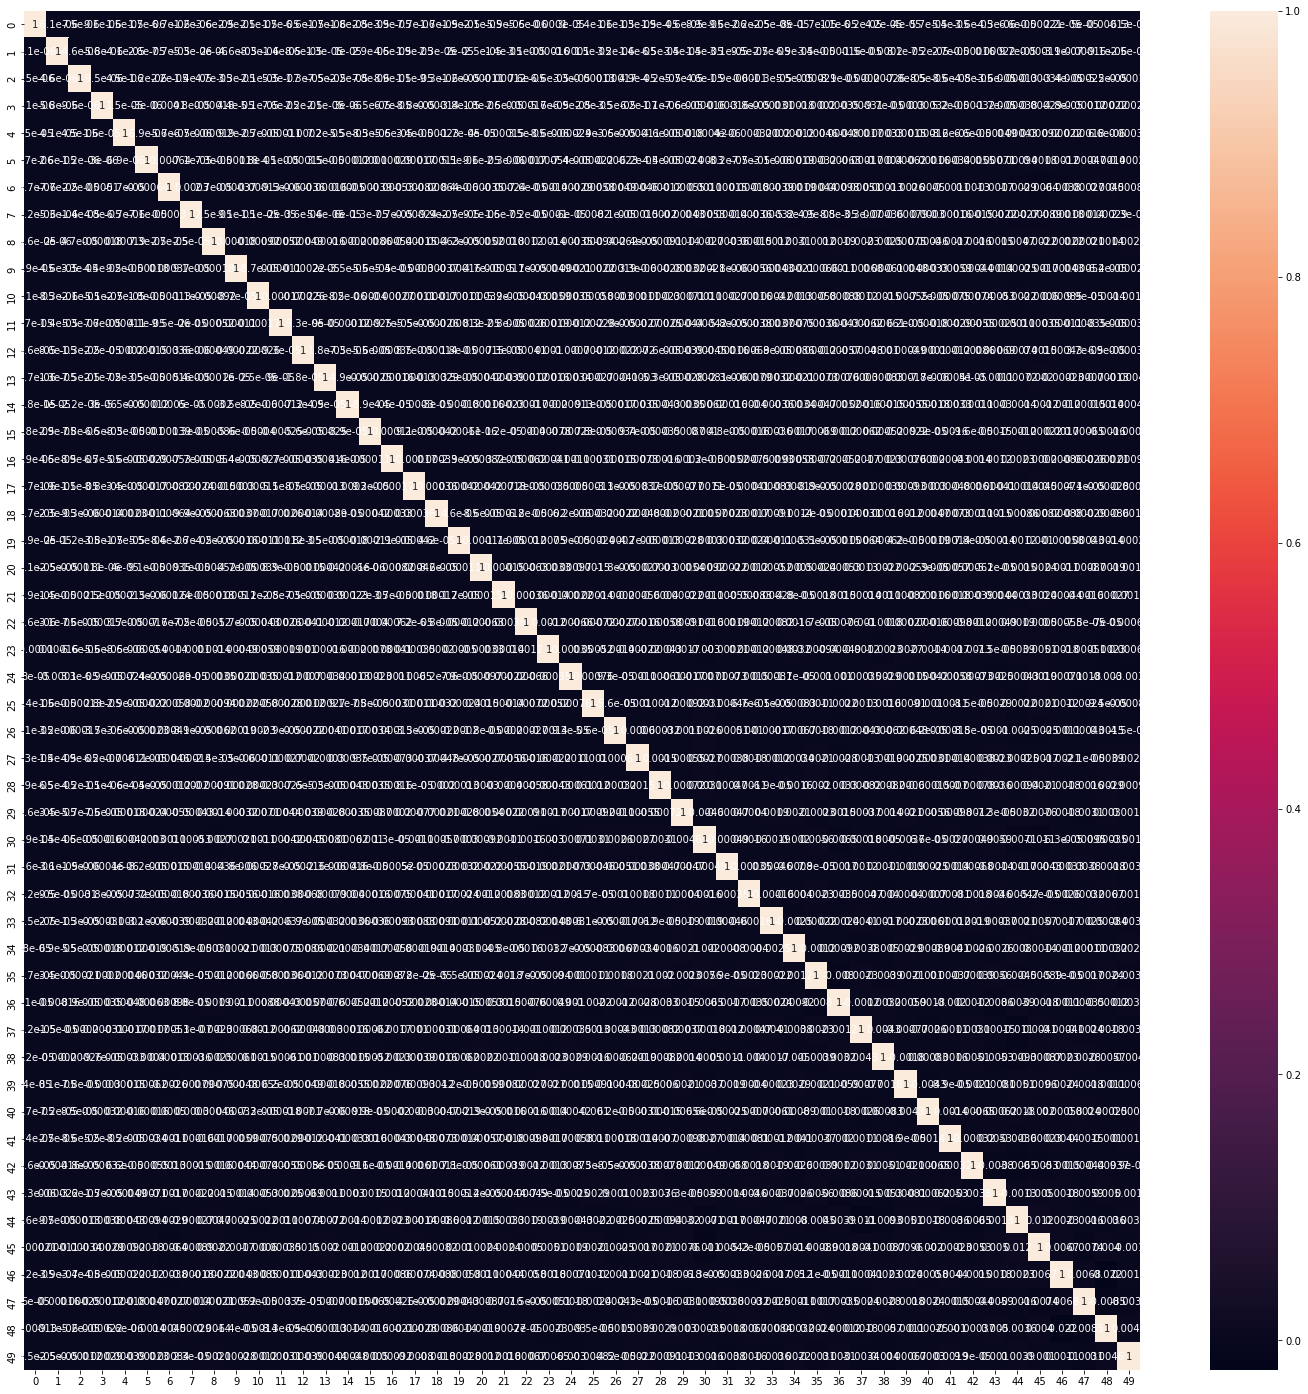

max corr: 0.012046637136405173 , min corr:  -0.022112862680689908


In [71]:
#Plotting a heatmap
X_train_pca, X_test_pca = plot_incremental_PCA(X_train, y_train, 50)

As we can see, after performing incremental PCA, no two variables are correlated (either positively or negatively).

## 4.3 Logistic Regression With PCA

### 4.3.1 Building a Logistic Regression model with default parameters

In [72]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

#creating a logistic regression model
logreg_pca = LogisticRegression()
model_pca = logreg_pca.fit(X_train_pca, y_train) #using variables that underwent PCA

In [73]:
print(X_train_pca.shape)
print(y_train.shape)

(36112, 50)
(36112,)


In [74]:
y_train_pred = model_pca.predict_proba(X_train_pca)[:,1]
y_train_pred

array([0.18628825, 0.25975603, 0.90316666, ..., 0.80088605, 0.92220021,
       0.99572224])

In [75]:
y_train_pred_final = pd.DataFrame({'Churn': y_train, 'Churn_Prob': y_train_pred})
y_train_pred_final.head()

Churn  Churn_Prob
0  0      0.186288  
1  0      0.259756  
2  1      0.903167  
3  0      0.006782  
4  0      0.112377

In [76]:
#Creating columns with different probability cutoffs

numbers = [float(x)/10 for x in range(10)]

for i in numbers:
    y_train_pred_final[i]= y_train_pred_final.Churn_Prob.map(lambda x: 1 if x > i else 0)
    
y_train_pred_final.head()

Churn  Churn_Prob  0.0  0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9
0  0      0.186288    1    1    0    0    0    0    0    0    0    0  
1  0      0.259756    1    1    1    0    0    0    0    0    0    0  
2  1      0.903167    1    1    1    1    1    1    1    1    1    1  
3  0      0.006782    1    0    0    0    0    0    0    0    0    0  
4  0      0.112377    1    1    0    0    0    0    0    0    0    0

In [77]:
# Calculating accuracy sensitivity and specificity for various probability cutoffs

from sklearn.metrics import confusion_matrix

cutoff_df = pd.DataFrame(columns = ['probability','accuracy','sensitivity','specificity'])

num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for i in num:
    
    cm1 = metrics.confusion_matrix(y_train_pred_final.Churn, y_train_pred_final[i])
    total1 = sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    
    speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] = [i, accuracy, sensi, speci]
    
print(cutoff_df)

     probability  accuracy  sensitivity  specificity
0.0  0.0          0.500000  1.000000     0.000000   
0.1  0.1          0.708989  0.974302     0.443675   
0.2  0.2          0.766670  0.952592     0.580749   
0.3  0.3          0.802919  0.926839     0.678999   
0.4  0.4          0.824657  0.897098     0.752215   
0.5  0.5          0.837146  0.860600     0.813691   
0.6  0.6          0.839804  0.809482     0.870126   
0.7  0.7          0.828312  0.742745     0.913879   
0.8  0.8          0.786387  0.624834     0.947940   
0.9  0.9          0.634083  0.288491     0.979674   


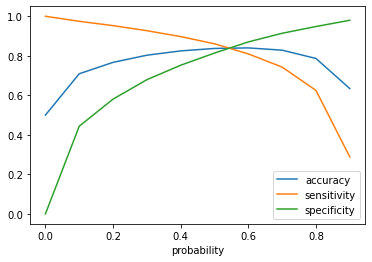

In [78]:
# Plotting accuracy sensitivity and specificity to find optimal cutoff

cutoff_df.plot.line(x='probability', y = ['accuracy','sensitivity','specificity'])
plt.show()

From the curve above, 0.55 seems to be the optimal point. We will choose this value as our cutoff probability

In [79]:
#using our optimal cutoff point

y_train_pred_final['final_predicted'] = y_train_pred_final.Churn_Prob.map(lambda x: 1 if x > 0.55 else 0)

y_train_pred_final.head()

Churn  Churn_Prob  0.0  0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  \
0  0      0.186288    1    1    0    0    0    0    0    0    0    0     
1  0      0.259756    1    1    1    0    0    0    0    0    0    0     
2  1      0.903167    1    1    1    1    1    1    1    1    1    1     
3  0      0.006782    1    0    0    0    0    0    0    0    0    0     
4  0      0.112377    1    1    0    0    0    0    0    0    0    0     

   final_predicted  
0  0                
1  0                
2  1                
3  0                
4  0

In [80]:
confusion = metrics.confusion_matrix(y_train_pred_final.Churn, y_train_pred_final.final_predicted)

confusion

array([[15179,  2877],
       [ 2973, 15083]], dtype=int64)

In [81]:
#Finding the optimal accuracy

metrics.accuracy_score(y_train_pred_final.Churn, y_train_pred_final.final_predicted)

0.8380039875941515

In [82]:
print("Accuracy: ", metrics.accuracy_score(y_train_pred_final.Churn, y_train_pred_final.final_predicted))
print("Precision: ", metrics.precision_score(y_train_pred_final.Churn, y_train_pred_final.final_predicted))
print("Recall: ", metrics.recall_score(y_train_pred_final.Churn, y_train_pred_final.final_predicted))
print("roc_auc_score: ", metrics.roc_auc_score(y_train_pred_final.Churn, y_train_pred_final.final_predicted))

Accuracy:  0.8380039875941515
Precision:  0.8398106904231626
Recall:  0.8353455914931325
roc_auc_score:  0.8380039875941515


In [83]:
pred_probs_test = model_pca.predict_proba(X_test_pca)[:, 1]
y_test_df = pd.DataFrame(y_test)
y_pred_df = pd.DataFrame(pred_probs_test)

y_test_df.reset_index(drop = True, inplace = True)
y_pred_df.reset_index(drop = True, inplace = True)
y_test_pred_final = pd.concat([y_test_df, y_pred_df],axis = 1)

In [84]:
# Renaming the column 
y_test_pred_final= y_test_pred_final.rename(columns = {0 : 'Churn_prob'})

In [85]:
y_test_pred_final['final_predicted'] = y_test_pred_final.Churn_prob.map(lambda x: 1 if x > 0.55 else 0)

In [86]:
confusion_lr_pca = metrics.confusion_matrix(y_test_pred_final.churn, y_test_pred_final.final_predicted )

In [87]:
confusion_lr_pca

array([[6522, 1243],
       [ 134,  526]], dtype=int64)

In [88]:
TP = confusion_lr_pca[1,1] # true positive 
TN = confusion_lr_pca[0,0] # true negatives
FP = confusion_lr_pca[0,1] # false positives
FN = confusion_lr_pca[1,0] # false negatives

In [89]:
#Plotting the ROC curve

def draw_roc(actual, predicted):
    fpr, tpr, thresholds = metrics.roc_curve(actual, predicted, drop_intermediate = False )
    auc_score = metrics.roc_auc_score(actual, predicted)
    plt.figure(figsize = [7, 7])
    plt.plot(fpr, tpr, label = 'ROC curve (area = %0.2f)' % auc_score)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc = "best")
    plt.show()

    print("roc_auc_score: ", auc_score)
    return None

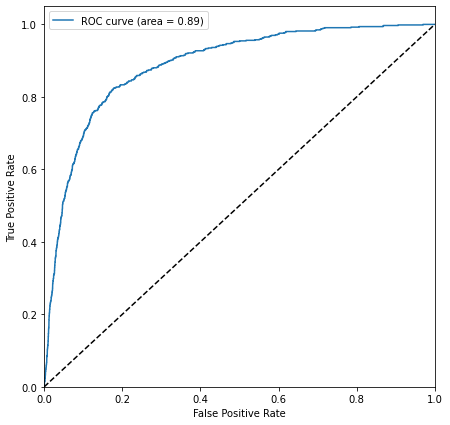

roc_auc_score:  0.8872934106031339


In [90]:
draw_roc(y_test, pred_probs_test)

In [91]:
print("Accuracy", metrics.accuracy_score(y_test_pred_final.churn, y_test_pred_final.final_predicted))
print("Precision", metrics.precision_score(y_test_pred_final.churn, y_test_pred_final.final_predicted))
print("Sensitivity/Recall", metrics.recall_score(y_test_pred_final.churn, y_test_pred_final.final_predicted))
print("roc_auc_score", metrics.roc_auc_score(y_test_pred_final.churn, y_test_pred_final.final_predicted))

Accuracy 0.8365578635014836
Precision 0.2973431317128321
Sensitivity/Recall 0.796969696969697
roc_auc_score 0.8184462135846552


In [92]:
compare_dataframe = pd.DataFrame({"Accuracy": metrics.accuracy_score(y_test_pred_final.churn, y_test_pred_final.final_predicted),
                                  "Precision": metrics.precision_score(y_test_pred_final.churn, y_test_pred_final.final_predicted),
                                  "Recall": metrics.recall_score(y_test_pred_final.churn, y_test_pred_final.final_predicted),
                                  "Sensitivity": TP/float(TP+FN),
                                  "Specificity": TN/float(TN+FP),
                                  "roc_auc_score": metrics.roc_auc_score(y_test_pred_final.churn, y_test_pred_final.final_predicted)}, index = ["Log. Reg. (with PCA)"])

compare_dataframe

Accuracy  Precision   Recall  Sensitivity  Specificity  \
Log. Reg. (with PCA)  0.836558  0.297343   0.79697  0.79697      0.839923      

                      roc_auc_score  
Log. Reg. (with PCA)  0.818446

### 4.3.2 Running a Logistic Regression Model with  Hyperparameter Tuning

In [93]:
# creating a KFold object with 5 splits 

folds = KFold(n_splits = 5, shuffle = True, random_state = 4)

# specifying the range of hyperparameters
hyper_params ={ 'C': [1, 10, 100, 1000]} #to find the best value of C: smaller values specify stronger regularization.

# specify model
model = LogisticRegression()

# using gridsearch:
model_cv = GridSearchCV(estimator = model, 
                        param_grid = hyper_params, 
                        scoring= 'roc_auc', 
                        cv = folds,
                        n_jobs = -1,
                        verbose = 1,
                        return_train_score=True)      

# fiting the model
model_cv.fit(X_train_pca, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=4, shuffle=True),
             estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [1, 10, 100, 1000]}, return_train_score=True,
             scoring='roc_auc', verbose=1)

In [94]:
# creating a dataframe to check the model results

cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results

mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C  \
0  0.561649       0.022859      0.022090         0.007488        1        
1  0.560738       0.041464      0.018744         0.006247        10       
2  0.557060       0.018472      0.019943         0.009905        100      
3  0.390236       0.079247      0.013232         0.004505        1000     

        params  split0_test_score  split1_test_score  split2_test_score  \
0  {'C': 1}     0.906263           0.901612           0.910924            
1  {'C': 10}    0.906263           0.901613           0.910927            
2  {'C': 100}   0.906263           0.901613           0.910927            
3  {'C': 1000}  0.906263           0.901613           0.910927            

   split3_test_score  split4_test_score  mean_test_score  std_test_score  \
0  0.909245           0.908679           0.907345         0.003232         
1  0.909246           0.908679           0.907346         0.003232         
2  0.909247           0.908679           0.907346         0.003233         
3  0.909247           0.908679           0.907346         0.003233         

   rank_test_score  split0_train_score  split1_train_score  \
0  4                0.908487            0.909684             
1  2                0.908487            0.909684             
2  1                0.908487            0.909684             
3  3                0.908487            0.909684             

   split2_train_score  split3_train_score  split4_train_score  \
0  0.907472            0.907811            0.908034             
1  0.907472            0.907811            0.908035             
2  0.907472            0.907811            0.908035             
3  0.907472            0.907811            0.908035             

   mean_train_score  std_train_score  
0  0.908297          0.000768         
1  0.908298          0.000767         
2  0.908298          0.000767         
3  0.908298          0.000767

In [95]:
#model = LogisticRegression()

model.fit(X_train_pca, y_train)
y_pred_train_lr = model.predict(X_train_pca)

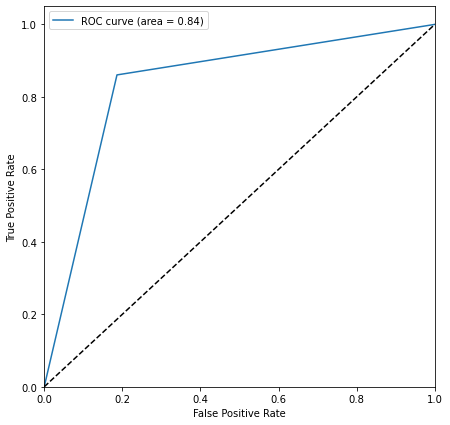

roc_auc_score:  0.8371455471865309


In [96]:
#plotting an roc curve using the train data
draw_roc(y_train, y_pred_train_lr)

In [97]:
# printing the optimal roc score and hyperparameters

print("The best test score is: {0} \nThe best hyperparameters are: {1}".format(model_cv.best_score_, model_cv.best_params_))

The best test score is: 0.9073457936138765 
The best hyperparameters are: {'C': 100}


In [98]:
model_cv.best_params_['C']

100

In [99]:
# using the optimal hyperparameters 

model = LogisticRegression(C = model_cv.best_params_['C'])

model.fit(X_train_pca, y_train)
y_pred_lr = model.predict(X_test_pca)

# printing all the metrics
print(metrics.confusion_matrix(y_test, y_pred_lr))
print()
print("Accuracy", metrics.accuracy_score(y_test, y_pred_lr))
print("Precision", metrics.precision_score(y_test, y_pred_lr))
print("Recall", metrics.recall_score(y_test, y_pred_lr))
print("roc_auc_score", metrics.roc_auc_score(y_test, y_pred_lr))

[[6314 1451]
 [ 114  546]]

Accuracy 0.8142433234421365
Precision 0.27341011517275915
Recall 0.8272727272727273
roc_auc_score 0.8202042966692034


In [100]:
TP = metrics.confusion_matrix(y_test, y_pred_lr)[1,1] # true positive 
TN = metrics.confusion_matrix(y_test, y_pred_lr)[0,0] # true negatives
FP = metrics.confusion_matrix(y_test, y_pred_lr)[0,1] # false positives
FN = metrics.confusion_matrix(y_test, y_pred_lr)[1,0] # false negatives

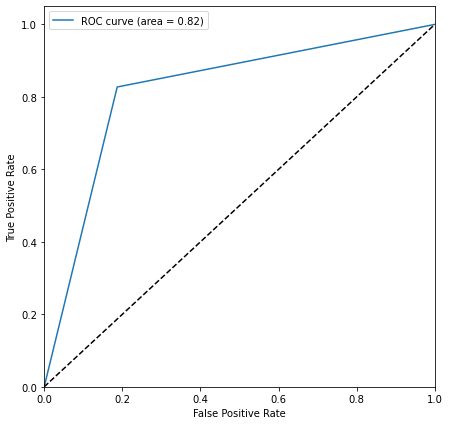

roc_auc_score:  0.8202042966692034


In [101]:
#plotting an roc curve using the test data
draw_roc(y_test, y_pred_lr)

In [102]:
compare_dataframe2 = pd.DataFrame({"Accuracy": metrics.accuracy_score(y_test, y_pred_lr),
                                   "Precision": metrics.precision_score(y_test, y_pred_lr),
                                   "Recall": metrics.recall_score(y_test, y_pred_lr),
                                   "Sensitivity": TP/float(TP+FN),
                                   "Specificity": TN/float(TN+FP),
                                   "roc_auc_score": metrics.roc_auc_score(y_test, y_pred_lr)}, index = ["Log. Reg. with hyperparameter Tuning (with PCA)"])

compare_dataframe = pd.concat([compare_dataframe, compare_dataframe2])
compare_dataframe = compare_dataframe[["Accuracy", "Precision", "Recall", "Sensitivity", "Specificity", "roc_auc_score"]]

compare_dataframe

Accuracy  Precision  \
Log. Reg. (with PCA)                             0.836558  0.297343    
Log. Reg. with hyperparameter Tuning (with PCA)  0.814243  0.273410    

                                                   Recall  Sensitivity  \
Log. Reg. (with PCA)                             0.796970  0.796970      
Log. Reg. with hyperparameter Tuning (with PCA)  0.827273  0.827273      

                                                 Specificity  roc_auc_score  
Log. Reg. (with PCA)                             0.839923     0.818446       
Log. Reg. with hyperparameter Tuning (with PCA)  0.813136     0.820204

## 4.4 Logistic Regression Without PCA (Using RFE, P-Values and VIF)

In [103]:
y = telecom_data.churn
X = telecom_data.drop('churn', axis = 1)

# scaling the features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns = X.columns)

# setting up testing and training sets
X_train_lr, X_test_lr, y_train_lr, y_test_lr = train_test_split(X_scaled_df, y, train_size=0.7, test_size=0.3, random_state=100)
y_train_lr = y_train_lr.values.reshape(-1,1) 

In [104]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
from sklearn.feature_selection import RFE
rfe = RFE(logreg, n_features_to_select = 20)# running RFE with 20 variables as output
rfe = rfe.fit(X_train_lr, y_train_lr)

In [105]:
list(zip(X_train_lr.columns, rfe.support_, rfe.ranking_))

[('mobile_number', False, 122),
 ('arpu_6', False, 65),
 ('arpu_7', False, 101),
 ('arpu_8', False, 12),
 ('onnet_mou_6', False, 67),
 ('onnet_mou_7', True, 1),
 ('onnet_mou_8', True, 1),
 ('offnet_mou_6', False, 5),
 ('offnet_mou_7', True, 1),
 ('offnet_mou_8', False, 74),
 ('roam_ic_mou_6', False, 94),
 ('roam_ic_mou_7', False, 55),
 ('roam_ic_mou_8', False, 115),
 ('roam_og_mou_6', False, 93),
 ('roam_og_mou_7', False, 111),
 ('roam_og_mou_8', False, 76),
 ('loc_og_t2t_mou_6', False, 7),
 ('loc_og_t2t_mou_7', False, 17),
 ('loc_og_t2t_mou_8', False, 15),
 ('loc_og_t2m_mou_6', False, 48),
 ('loc_og_t2m_mou_7', False, 91),
 ('loc_og_t2m_mou_8', False, 26),
 ('loc_og_t2f_mou_6', False, 128),
 ('loc_og_t2f_mou_7', False, 43),
 ('loc_og_t2f_mou_8', False, 42),
 ('loc_og_t2c_mou_6', False, 73),
 ('loc_og_t2c_mou_7', False, 72),
 ('loc_og_t2c_mou_8', False, 129),
 ('loc_og_mou_6', False, 77),
 ('loc_og_mou_7', False, 71),
 ('loc_og_mou_8', False, 64),
 ('std_og_t2t_mou_6', False, 6),
 ('st

In [106]:
col = X_train_lr.columns[rfe.support_]

print(col)

Index(['onnet_mou_7', 'onnet_mou_8', 'offnet_mou_7', 'std_og_t2m_mou_8',
       'total_og_mou_7', 'total_og_mou_8', 'loc_ic_t2t_mou_8',
       'loc_ic_t2m_mou_8', 'loc_ic_mou_8', 'std_ic_mou_8', 'total_ic_mou_6',
       'total_ic_mou_7', 'total_ic_mou_8', 'spl_ic_mou_8', 'isd_ic_mou_8',
       'total_rech_num_8', 'last_day_rch_amt_8', 'total_rech_data_8',
       'max_rech_data_8', 'diff_ic_good_active_phase'],
      dtype='object')


### 4.4.1 Creating Iterative models using p-value and VIF

In [107]:
#attempting our first model

import statsmodels.api as sm

X_train_sm = sm.add_constant(X_train_lr[col])
logm1 = sm.GLM(y_train_lr, X_train_sm, family = sm.families.Binomial())
res = logm1.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                19658
Model:                            GLM   Df Residuals:                    19638
Model Family:                Binomial   Df Model:                           19
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3521.2
Date:                Thu, 28 Apr 2022   Deviance:                       7042.5
Time:                        12:55:25   Pearson chi2:                 2.34e+05
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                        -4.0753      0.075    -54.556      0.000      -4.222      -3.929
onnet_mou_7                   0.8904      0.125      7.120      0.000       0.645       1.136
onnet_mou_8                   0.6138      0.140      4.386      0.000       0.340       0.888
offnet_mou_7                  1.0525      0.122      8.617      0.000       0.813       1.292
std_og_t2m_mou_8              0.5246      0.125      4.211      0.000       0.280       0.769
total_og_mou_7               -1.0517      0.177     -5.949      0.000      -1.398      -0.705
total_og_mou_8               -1.4267      0.202     -7.066      0.000      -1.822      -1.031
loc_ic_t2t_mou_8              0.0798      0.358      0.223      0.824      -0.621       0.781
loc_ic_t2m_mou_8             -0.1141      0.558     -0.205      0.838      -1.207       0.979
loc_ic_mou_8                  4.1616      0.791      5.261      0.000       2.611       5.712
std_ic_mou_8                  1.5836      0.142     11.175      0.000       1.306       1.861
total_ic_mou_6               -1.2449      0.109    -11.422      0.000      -1.459      -1.031
total_ic_mou_7               -1.4849      0.106    -13.989      0.000      -1.693      -1.277
total_ic_mou_8               -5.2392      0.310    -16.919      0.000      -5.846      -4.632
spl_ic_mou_8                 -0.4683      0.073     -6.396      0.000      -0.612      -0.325
isd_ic_mou_8                  1.0655      0.072     14.715      0.000       0.924       1.207
total_rech_num_8             -0.3453      0.057     -6.085      0.000      -0.457      -0.234
last_day_rch_amt_8           -0.5180      0.058     -8.884      0.000      -0.632      -0.404
total_rech_data_8            -0.6428      0.073     -8.773      0.000      -0.786      -0.499
max_rech_data_8              -0.5531      0.055    -10.083      0.000      -0.661      -0.446
diff_ic_good_active_phase     1.9835      0.113     17.563      0.000       1.762       2.205
=============================================================================================
"""

In [108]:
# Check for the VIF values of the feature variables
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
vif['Features'] = X_train_lr[col].columns
vif['VIF'] = [variance_inflation_factor(X_train_lr[col].values, i) for i in range(X_train_lr[col].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

Features     VIF
10  total_ic_mou_6             inf   
11  total_ic_mou_7             inf   
12  total_ic_mou_8             inf   
19  diff_ic_good_active_phase  inf   
8   loc_ic_mou_8               206.67
4   total_og_mou_7             65.93 
7   loc_ic_t2m_mou_8           39.32 
0   onnet_mou_7                32.55 
2   offnet_mou_7               31.04 
9   std_ic_mou_8               16.87 
6   loc_ic_t2t_mou_8           14.75 
5   total_og_mou_8             14.41 
1   onnet_mou_8                9.59  
14  isd_ic_mou_8               5.56  
3   std_og_t2m_mou_8           4.87  
15  total_rech_num_8           1.58  
17  total_rech_data_8          1.30  
16  last_day_rch_amt_8         1.24  
18  max_rech_data_8            1.19  
13  spl_ic_mou_8               1.03

In [109]:
#dropping the variable loc_ic_t2m_mou_8 as it has the highest p-value and a really high VIF value

col = col.drop('loc_ic_t2m_mou_8', 1) 
col

Index(['onnet_mou_7', 'onnet_mou_8', 'offnet_mou_7', 'std_og_t2m_mou_8',
       'total_og_mou_7', 'total_og_mou_8', 'loc_ic_t2t_mou_8', 'loc_ic_mou_8',
       'std_ic_mou_8', 'total_ic_mou_6', 'total_ic_mou_7', 'total_ic_mou_8',
       'spl_ic_mou_8', 'isd_ic_mou_8', 'total_rech_num_8',
       'last_day_rch_amt_8', 'total_rech_data_8', 'max_rech_data_8',
       'diff_ic_good_active_phase'],
      dtype='object')

In [110]:
#attempting our 2nd model

X_train_sm = sm.add_constant(X_train_lr[col])
logm2 = sm.GLM(y_train_lr, X_train_sm, family = sm.families.Binomial())
res = logm2.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                19658
Model:                            GLM   Df Residuals:                    19639
Model Family:                Binomial   Df Model:                           18
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3521.3
Date:                Thu, 28 Apr 2022   Deviance:                       7042.5
Time:                        12:55:26   Pearson chi2:                 2.31e+05
No. Iterations:                    10                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                        -4.0750      0.075    -54.569      0.000      -4.221      -3.929
onnet_mou_7                   0.8902      0.125      7.119      0.000       0.645       1.135
onnet_mou_8                   0.6152      0.140      4.399      0.000       0.341       0.889
offnet_mou_7                  1.0522      0.122      8.616      0.000       0.813       1.292
std_og_t2m_mou_8              0.5256      0.124      4.223      0.000       0.282       0.770
total_og_mou_7               -1.0515      0.177     -5.948      0.000      -1.398      -0.705
total_og_mou_8               -1.4287      0.202     -7.083      0.000      -1.824      -1.033
loc_ic_t2t_mou_8              0.1442      0.171      0.842      0.400      -0.191       0.480
loc_ic_mou_8                  4.0169      0.356     11.290      0.000       3.320       4.714
std_ic_mou_8                  1.5833      0.142     11.174      0.000       1.306       1.861
total_ic_mou_6               -1.2446      0.109    -11.423      0.000      -1.458      -1.031
total_ic_mou_7               -1.4843      0.106    -13.992      0.000      -1.692      -1.276
total_ic_mou_8               -5.2375      0.309    -16.923      0.000      -5.844      -4.631
spl_ic_mou_8                 -0.4684      0.073     -6.396      0.000      -0.612      -0.325
isd_ic_mou_8                  1.0652      0.072     14.717      0.000       0.923       1.207
total_rech_num_8             -0.3459      0.057     -6.105      0.000      -0.457      -0.235
last_day_rch_amt_8           -0.5179      0.058     -8.881      0.000      -0.632      -0.404
total_rech_data_8            -0.6428      0.073     -8.774      0.000      -0.786      -0.499
max_rech_data_8              -0.5528      0.055    -10.082      0.000      -0.660      -0.445
diff_ic_good_active_phase     1.9828      0.113     17.568      0.000       1.762       2.204
=============================================================================================
"""

In [111]:
# Check for the VIF values of the feature variables

vif = pd.DataFrame()
vif['Features'] = X_train_lr[col].columns
vif['VIF'] = [variance_inflation_factor(X_train_lr[col].values, i) for i in range(X_train_lr[col].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

Features     VIF
9   total_ic_mou_6             inf   
10  total_ic_mou_7             inf   
11  total_ic_mou_8             inf   
18  diff_ic_good_active_phase  inf   
7   loc_ic_mou_8               138.31
4   total_og_mou_7             65.92 
0   onnet_mou_7                32.53 
2   offnet_mou_7               31.03 
8   std_ic_mou_8               16.87 
5   total_og_mou_8             14.41 
1   onnet_mou_8                9.59  
13  isd_ic_mou_8               5.56  
3   std_og_t2m_mou_8           4.87  
6   loc_ic_t2t_mou_8           2.00  
14  total_rech_num_8           1.58  
16  total_rech_data_8          1.30  
15  last_day_rch_amt_8         1.24  
17  max_rech_data_8            1.19  
12  spl_ic_mou_8               1.03

In [112]:
#due to high p-value we have to drop loc_ic_t2t_mou_8

col = col.drop('loc_ic_t2t_mou_8', 1)
col

Index(['onnet_mou_7', 'onnet_mou_8', 'offnet_mou_7', 'std_og_t2m_mou_8',
       'total_og_mou_7', 'total_og_mou_8', 'loc_ic_mou_8', 'std_ic_mou_8',
       'total_ic_mou_6', 'total_ic_mou_7', 'total_ic_mou_8', 'spl_ic_mou_8',
       'isd_ic_mou_8', 'total_rech_num_8', 'last_day_rch_amt_8',
       'total_rech_data_8', 'max_rech_data_8', 'diff_ic_good_active_phase'],
      dtype='object')

In [113]:
#attempting our 3rd model

X_train_sm = sm.add_constant(X_train_lr[col])
logm3 = sm.GLM(y_train_lr, X_train_sm, family = sm.families.Binomial())
res = logm3.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                19658
Model:                            GLM   Df Residuals:                    19640
Model Family:                Binomial   Df Model:                           17
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3521.6
Date:                Thu, 28 Apr 2022   Deviance:                       7043.2
Time:                        12:55:28   Pearson chi2:                 2.07e+05
No. Iterations:                    21                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                        -4.0738      0.075    -54.586      0.000      -4.220      -3.927
onnet_mou_7                   0.8898      0.125      7.110      0.000       0.645       1.135
onnet_mou_8                   0.6316      0.139      4.558      0.000       0.360       0.903
offnet_mou_7                  1.0498      0.122      8.592      0.000       0.810       1.289
std_og_t2m_mou_8              0.5393      0.124      4.366      0.000       0.297       0.781
total_og_mou_7               -1.0500      0.177     -5.935      0.000      -1.397      -0.703
total_og_mou_8               -1.4493      0.200     -7.232      0.000      -1.842      -1.057
loc_ic_mou_8                  4.0962      0.343     11.949      0.000       3.424       4.768
std_ic_mou_8                  1.5769      0.142     11.144      0.000       1.300       1.854
total_ic_mou_6               -1.2394      0.109    -11.394      0.000      -1.453      -1.026
total_ic_mou_7               -1.4809      0.106    -13.971      0.000      -1.689      -1.273
total_ic_mou_8               -5.2229      0.309    -16.906      0.000      -5.828      -4.617
spl_ic_mou_8                 -0.4683      0.073     -6.397      0.000      -0.612      -0.325
isd_ic_mou_8                  1.0623      0.072     14.696      0.000       0.921       1.204
total_rech_num_8             -0.3474      0.057     -6.133      0.000      -0.458      -0.236
last_day_rch_amt_8           -0.5174      0.058     -8.876      0.000      -0.632      -0.403
total_rech_data_8            -0.6430      0.073     -8.776      0.000      -0.787      -0.499
max_rech_data_8              -0.5532      0.055    -10.093      0.000      -0.661      -0.446
diff_ic_good_active_phase     1.9781      0.113     17.552      0.000       1.757       2.199
=============================================================================================
"""

In [114]:
# Check for the VIF values of the feature variables

vif = pd.DataFrame()
vif['Features'] = X_train_lr[col].columns
vif['VIF'] = [variance_inflation_factor(X_train_lr[col].values, i) for i in range(X_train_lr[col].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

Features     VIF
9   total_ic_mou_7             inf   
8   total_ic_mou_6             inf   
10  total_ic_mou_8             inf   
17  diff_ic_good_active_phase  inf   
6   loc_ic_mou_8               137.69
4   total_og_mou_7             65.92 
0   onnet_mou_7                32.53 
2   offnet_mou_7               31.02 
7   std_ic_mou_8               16.85 
5   total_og_mou_8             13.84 
1   onnet_mou_8                9.22  
12  isd_ic_mou_8               5.55  
3   std_og_t2m_mou_8           4.65  
13  total_rech_num_8           1.58  
15  total_rech_data_8          1.30  
14  last_day_rch_amt_8         1.24  
16  max_rech_data_8            1.19  
11  spl_ic_mou_8               1.03

In [115]:
#dropping total_ic_mou_7 due to high VIF value

col = col.drop('total_ic_mou_7', 1)
col

Index(['onnet_mou_7', 'onnet_mou_8', 'offnet_mou_7', 'std_og_t2m_mou_8',
       'total_og_mou_7', 'total_og_mou_8', 'loc_ic_mou_8', 'std_ic_mou_8',
       'total_ic_mou_6', 'total_ic_mou_8', 'spl_ic_mou_8', 'isd_ic_mou_8',
       'total_rech_num_8', 'last_day_rch_amt_8', 'total_rech_data_8',
       'max_rech_data_8', 'diff_ic_good_active_phase'],
      dtype='object')

In [116]:
#attempting our 4th model

X_train_sm = sm.add_constant(X_train_lr[col])
logm4 = sm.GLM(y_train_lr ,X_train_sm, family = sm.families.Binomial())
res = logm4.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                19658
Model:                            GLM   Df Residuals:                    19640
Model Family:                Binomial   Df Model:                           17
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3521.6
Date:                Thu, 28 Apr 2022   Deviance:                       7043.2
Time:                        12:55:30   Pearson chi2:                 2.07e+05
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                        -4.0738      0.075    -54.586      0.000      -4.220      -3.927
onnet_mou_7                   0.8898      0.125      7.110      0.000       0.645       1.135
onnet_mou_8                   0.6316      0.139      4.558      0.000       0.360       0.903
offnet_mou_7                  1.0498      0.122      8.592      0.000       0.810       1.289
std_og_t2m_mou_8              0.5393      0.124      4.366      0.000       0.297       0.781
total_og_mou_7               -1.0500      0.177     -5.935      0.000      -1.397      -0.703
total_og_mou_8               -1.4493      0.200     -7.232      0.000      -1.842      -1.057
loc_ic_mou_8                  4.0962      0.343     11.949      0.000       3.424       4.768
std_ic_mou_8                  1.5769      0.142     11.144      0.000       1.300       1.854
total_ic_mou_6                0.2459      0.129      1.901      0.057      -0.008       0.499
total_ic_mou_8               -6.6886      0.394    -16.997      0.000      -7.460      -5.917
spl_ic_mou_8                 -0.4683      0.073     -6.397      0.000      -0.612      -0.325
isd_ic_mou_8                  1.0623      0.072     14.696      0.000       0.921       1.204
total_rech_num_8             -0.3474      0.057     -6.133      0.000      -0.458      -0.236
last_day_rch_amt_8           -0.5174      0.058     -8.876      0.000      -0.632      -0.403
total_rech_data_8            -0.6430      0.073     -8.776      0.000      -0.787      -0.499
max_rech_data_8              -0.5532      0.055    -10.093      0.000      -0.661      -0.446
diff_ic_good_active_phase     0.1474      0.102      1.449      0.147      -0.052       0.347
=============================================================================================
"""

In [117]:
# Check for the VIF values of the feature variables

vif = pd.DataFrame()
vif['Features'] = X_train_lr[col].columns
vif['VIF'] = [variance_inflation_factor(X_train_lr[col].values, i) for i in range(X_train_lr[col].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

Features     VIF
9   total_ic_mou_8             174.72
6   loc_ic_mou_8               137.69
4   total_og_mou_7             65.92 
0   onnet_mou_7                32.53 
2   offnet_mou_7               31.02 
7   std_ic_mou_8               16.85 
5   total_og_mou_8             13.84 
8   total_ic_mou_6             12.10 
1   onnet_mou_8                9.22  
16  diff_ic_good_active_phase  7.55  
11  isd_ic_mou_8               5.55  
3   std_og_t2m_mou_8           4.65  
12  total_rech_num_8           1.58  
14  total_rech_data_8          1.30  
13  last_day_rch_amt_8         1.24  
15  max_rech_data_8            1.19  
10  spl_ic_mou_8               1.03

In [118]:
#diff_ic_good_active_phase has a high p-value and VIF value

col = col.drop('diff_ic_good_active_phase', 1)
col

Index(['onnet_mou_7', 'onnet_mou_8', 'offnet_mou_7', 'std_og_t2m_mou_8',
       'total_og_mou_7', 'total_og_mou_8', 'loc_ic_mou_8', 'std_ic_mou_8',
       'total_ic_mou_6', 'total_ic_mou_8', 'spl_ic_mou_8', 'isd_ic_mou_8',
       'total_rech_num_8', 'last_day_rch_amt_8', 'total_rech_data_8',
       'max_rech_data_8'],
      dtype='object')

In [119]:
#attempting our 5th model

X_train_sm = sm.add_constant(X_train_lr[col])
logm5 = sm.GLM(y_train_lr, X_train_sm, family = sm.families.Binomial())
res = logm5.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                19658
Model:                            GLM   Df Residuals:                    19641
Model Family:                Binomial   Df Model:                           16
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3522.6
Date:                Thu, 28 Apr 2022   Deviance:                       7045.3
Time:                        12:55:31   Pearson chi2:                 2.01e+05
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -4.0692      0.074    -54.707      0.000      -4.215      -3.923
onnet_mou_7            0.8727      0.124      7.011      0.000       0.629       1.117
onnet_mou_8            0.6424      0.139      4.633      0.000       0.371       0.914
offnet_mou_7           1.0390      0.122      8.528      0.000       0.800       1.278
std_og_t2m_mou_8       0.5424      0.124      4.382      0.000       0.300       0.785
total_og_mou_7        -1.0125      0.175     -5.792      0.000      -1.355      -0.670
total_og_mou_8        -1.4778      0.200     -7.393      0.000      -1.870      -1.086
loc_ic_mou_8           4.0864      0.342     11.937      0.000       3.415       4.757
std_ic_mou_8           1.5757      0.141     11.162      0.000       1.299       1.852
total_ic_mou_6         0.4187      0.050      8.447      0.000       0.322       0.516
total_ic_mou_8        -6.7219      0.393    -17.116      0.000      -7.492      -5.952
spl_ic_mou_8          -0.4709      0.073     -6.423      0.000      -0.615      -0.327
isd_ic_mou_8           1.0599      0.072     14.702      0.000       0.919       1.201
total_rech_num_8      -0.3481      0.057     -6.146      0.000      -0.459      -0.237
last_day_rch_amt_8    -0.5169      0.058     -8.864      0.000      -0.631      -0.403
total_rech_data_8     -0.6434      0.073     -8.779      0.000      -0.787      -0.500
max_rech_data_8       -0.5531      0.055    -10.084      0.000      -0.661      -0.446
======================================================================================
"""

In [120]:
# Check for the VIF values of the feature variables

vif = pd.DataFrame()
vif['Features'] = X_train_lr[col].columns
vif['VIF'] = [variance_inflation_factor(X_train_lr[col].values, i) for i in range(X_train_lr[col].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

Features     VIF
9   total_ic_mou_8      173.18
6   loc_ic_mou_8        137.64
4   total_og_mou_7      64.64 
0   onnet_mou_7         32.21 
2   offnet_mou_7        30.86 
7   std_ic_mou_8        16.84 
5   total_og_mou_8      13.63 
1   onnet_mou_8         9.20  
11  isd_ic_mou_8        5.55  
3   std_og_t2m_mou_8    4.65  
8   total_ic_mou_6      2.25  
12  total_rech_num_8    1.58  
14  total_rech_data_8   1.30  
13  last_day_rch_amt_8  1.24  
15  max_rech_data_8     1.19  
10  spl_ic_mou_8        1.03

In [121]:
#dropping total_ic_mou_8 due to high VIF value

col = col.drop('total_ic_mou_8', 1)
col

Index(['onnet_mou_7', 'onnet_mou_8', 'offnet_mou_7', 'std_og_t2m_mou_8',
       'total_og_mou_7', 'total_og_mou_8', 'loc_ic_mou_8', 'std_ic_mou_8',
       'total_ic_mou_6', 'spl_ic_mou_8', 'isd_ic_mou_8', 'total_rech_num_8',
       'last_day_rch_amt_8', 'total_rech_data_8', 'max_rech_data_8'],
      dtype='object')

In [122]:
#attempting our 6th model

X_train_sm = sm.add_constant(X_train_lr[col])
logm6 = sm.GLM(y_train_lr, X_train_sm, family = sm.families.Binomial())
res = logm6.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                19658
Model:                            GLM   Df Residuals:                    19642
Model Family:                Binomial   Df Model:                           15
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3731.3
Date:                Thu, 28 Apr 2022   Deviance:                       7462.6
Time:                        12:55:33   Pearson chi2:                 2.01e+06
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -4.0134      0.068    -58.941      0.000      -4.147      -3.880
onnet_mou_7            0.7414      0.124      5.959      0.000       0.498       0.985
onnet_mou_8            1.6616      0.140     11.891      0.000       1.388       1.935
offnet_mou_7           0.9410      0.122      7.706      0.000       0.702       1.180
std_og_t2m_mou_8       1.4705      0.126     11.626      0.000       1.223       1.718
total_og_mou_7        -0.9239      0.174     -5.295      0.000      -1.266      -0.582
total_og_mou_8        -3.0298      0.202    -14.975      0.000      -3.426      -2.633
loc_ic_mou_8          -1.1275      0.103    -10.963      0.000      -1.329      -0.926
std_ic_mou_8          -0.4233      0.075     -5.654      0.000      -0.570      -0.277
total_ic_mou_6         0.3750      0.045      8.386      0.000       0.287       0.463
spl_ic_mou_8          -0.3934      0.063     -6.285      0.000      -0.516      -0.271
isd_ic_mou_8           0.0209      0.037      0.567      0.571      -0.051       0.093
total_rech_num_8      -0.5622      0.060     -9.336      0.000      -0.680      -0.444
last_day_rch_amt_8    -0.6440      0.062    -10.450      0.000      -0.765      -0.523
total_rech_data_8     -0.7250      0.077     -9.379      0.000      -0.877      -0.573
max_rech_data_8       -0.5593      0.056     -9.913      0.000      -0.670      -0.449
======================================================================================
"""

In [123]:
# Check for the VIF values of the feature variables

vif = pd.DataFrame()
vif['Features'] = X_train_lr[col].columns
vif['VIF'] = [variance_inflation_factor(X_train_lr[col].values, i) for i in range(X_train_lr[col].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

Features    VIF
4   total_og_mou_7      64.44
0   onnet_mou_7         32.15
2   offnet_mou_7        30.73
5   total_og_mou_8      13.34
1   onnet_mou_8         9.06 
3   std_og_t2m_mou_8    4.58 
6   loc_ic_mou_8        2.50 
8   total_ic_mou_6      2.24 
11  total_rech_num_8    1.57 
13  total_rech_data_8   1.30 
12  last_day_rch_amt_8  1.24 
14  max_rech_data_8     1.19 
7   std_ic_mou_8        1.14 
10  isd_ic_mou_8        1.04 
9   spl_ic_mou_8        1.03

In [124]:
#dropping isd_ic_mou_8 as it has a high p-value 

col = col.drop('isd_ic_mou_8', 1)
col

Index(['onnet_mou_7', 'onnet_mou_8', 'offnet_mou_7', 'std_og_t2m_mou_8',
       'total_og_mou_7', 'total_og_mou_8', 'loc_ic_mou_8', 'std_ic_mou_8',
       'total_ic_mou_6', 'spl_ic_mou_8', 'total_rech_num_8',
       'last_day_rch_amt_8', 'total_rech_data_8', 'max_rech_data_8'],
      dtype='object')

In [125]:
#attempting our 7th model

X_train_sm = sm.add_constant(X_train_lr[col])
logm7 = sm.GLM(y_train_lr, X_train_sm, family = sm.families.Binomial())
res = logm7.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                19658
Model:                            GLM   Df Residuals:                    19643
Model Family:                Binomial   Df Model:                           14
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3731.5
Date:                Thu, 28 Apr 2022   Deviance:                       7462.9
Time:                        12:55:36   Pearson chi2:                 1.99e+06
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -4.0122      0.068    -58.980      0.000      -4.145      -3.879
onnet_mou_7            0.7400      0.124      5.949      0.000       0.496       0.984
onnet_mou_8            1.6591      0.140     11.883      0.000       1.385       1.933
offnet_mou_7           0.9395      0.122      7.696      0.000       0.700       1.179
std_og_t2m_mou_8       1.4682      0.126     11.617      0.000       1.221       1.716
total_og_mou_7        -0.9225      0.174     -5.289      0.000      -1.264      -0.581
total_og_mou_8        -3.0256      0.202    -14.971      0.000      -3.422      -2.629
loc_ic_mou_8          -1.1284      0.103    -10.971      0.000      -1.330      -0.927
std_ic_mou_8          -0.4201      0.075     -5.638      0.000      -0.566      -0.274
total_ic_mou_6         0.3777      0.044      8.495      0.000       0.291       0.465
spl_ic_mou_8          -0.3923      0.062     -6.279      0.000      -0.515      -0.270
total_rech_num_8      -0.5617      0.060     -9.330      0.000      -0.680      -0.444
last_day_rch_amt_8    -0.6429      0.062    -10.437      0.000      -0.764      -0.522
total_rech_data_8     -0.7256      0.077     -9.387      0.000      -0.877      -0.574
max_rech_data_8       -0.5592      0.056     -9.910      0.000      -0.670      -0.449
======================================================================================
"""

In [126]:
# Check for the VIF values of the feature variables

vif = pd.DataFrame()
vif['Features'] = X_train_lr[col].columns
vif['VIF'] = [variance_inflation_factor(X_train_lr[col].values, i) for i in range(X_train_lr[col].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

Features    VIF
4   total_og_mou_7      64.44
0   onnet_mou_7         32.15
2   offnet_mou_7        30.73
5   total_og_mou_8      13.33
1   onnet_mou_8         9.06 
3   std_og_t2m_mou_8    4.58 
6   loc_ic_mou_8        2.48 
8   total_ic_mou_6      2.19 
10  total_rech_num_8    1.57 
12  total_rech_data_8   1.30 
11  last_day_rch_amt_8  1.24 
13  max_rech_data_8     1.19 
7   std_ic_mou_8        1.14 
9   spl_ic_mou_8        1.03

In [127]:
#dropping total_og_mou_7 due to high VIF value

col = col.drop('total_og_mou_7', 1)
col

Index(['onnet_mou_7', 'onnet_mou_8', 'offnet_mou_7', 'std_og_t2m_mou_8',
       'total_og_mou_8', 'loc_ic_mou_8', 'std_ic_mou_8', 'total_ic_mou_6',
       'spl_ic_mou_8', 'total_rech_num_8', 'last_day_rch_amt_8',
       'total_rech_data_8', 'max_rech_data_8'],
      dtype='object')

In [128]:
#attempting our 8th model

X_train_sm = sm.add_constant(X_train_lr[col])
logm8 = sm.GLM(y_train_lr, X_train_sm, family = sm.families.Binomial())
res = logm8.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                19658
Model:                            GLM   Df Residuals:                    19644
Model Family:                Binomial   Df Model:                           13
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3745.1
Date:                Thu, 28 Apr 2022   Deviance:                       7490.1
Time:                        12:55:37   Pearson chi2:                 3.28e+06
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -4.0356      0.069    -58.872      0.000      -4.170      -3.901
onnet_mou_7            0.1172      0.040      2.966      0.003       0.040       0.195
onnet_mou_8            1.8640      0.137     13.587      0.000       1.595       2.133
offnet_mou_7           0.3254      0.038      8.457      0.000       0.250       0.401
std_og_t2m_mou_8       1.6075      0.127     12.663      0.000       1.359       1.856
total_og_mou_8        -3.3365      0.199    -16.777      0.000      -3.726      -2.947
loc_ic_mou_8          -1.1268      0.103    -10.907      0.000      -1.329      -0.924
std_ic_mou_8          -0.4095      0.074     -5.522      0.000      -0.555      -0.264
total_ic_mou_6         0.3720      0.045      8.352      0.000       0.285       0.459
spl_ic_mou_8          -0.4004      0.063     -6.378      0.000      -0.523      -0.277
total_rech_num_8      -0.5377      0.059     -9.070      0.000      -0.654      -0.422
last_day_rch_amt_8    -0.6049      0.061     -9.954      0.000      -0.724      -0.486
total_rech_data_8     -0.7435      0.077     -9.656      0.000      -0.894      -0.593
max_rech_data_8       -0.5648      0.057     -9.974      0.000      -0.676      -0.454
======================================================================================
"""

In [129]:
# Check for the VIF values of the feature variables

vif = pd.DataFrame()
vif['Features'] = X_train_lr[col].columns
vif['VIF'] = [variance_inflation_factor(X_train_lr[col].values, i) for i in range(X_train_lr[col].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

Features    VIF
4   total_og_mou_8      13.05
1   onnet_mou_8         8.89 
3   std_og_t2m_mou_8    4.56 
0   onnet_mou_7         2.96 
2   offnet_mou_7        2.51 
5   loc_ic_mou_8        2.48 
7   total_ic_mou_6      2.19 
9   total_rech_num_8    1.57 
11  total_rech_data_8   1.30 
10  last_day_rch_amt_8  1.24 
12  max_rech_data_8     1.19 
6   std_ic_mou_8        1.14 
8   spl_ic_mou_8        1.03

In [130]:
#dropping total_og_mou_8 as it has a high VIF value

col = col.drop('total_og_mou_8', 1)
col

Index(['onnet_mou_7', 'onnet_mou_8', 'offnet_mou_7', 'std_og_t2m_mou_8',
       'loc_ic_mou_8', 'std_ic_mou_8', 'total_ic_mou_6', 'spl_ic_mou_8',
       'total_rech_num_8', 'last_day_rch_amt_8', 'total_rech_data_8',
       'max_rech_data_8'],
      dtype='object')

In [131]:
#attempting our 9th model

X_train_sm = sm.add_constant(X_train_lr[col])
logm9 = sm.GLM(y_train_lr, X_train_sm, family = sm.families.Binomial())
res = logm9.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                19658
Model:                            GLM   Df Residuals:                    19645
Model Family:                Binomial   Df Model:                           12
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3925.5
Date:                Thu, 28 Apr 2022   Deviance:                       7851.0
Time:                        12:55:38   Pearson chi2:                 1.97e+05
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -3.9255      0.066    -59.648      0.000      -4.055      -3.797
onnet_mou_7            0.1652      0.039      4.275      0.000       0.089       0.241
onnet_mou_8           -0.2078      0.058     -3.607      0.000      -0.321      -0.095
offnet_mou_7           0.2428      0.036      6.702      0.000       0.172       0.314
std_og_t2m_mou_8      -0.2116      0.053     -4.001      0.000      -0.315      -0.108
loc_ic_mou_8          -1.9744      0.098    -20.066      0.000      -2.167      -1.782
std_ic_mou_8          -0.4618      0.074     -6.280      0.000      -0.606      -0.318
total_ic_mou_6         0.4750      0.044     10.888      0.000       0.389       0.561
spl_ic_mou_8          -0.3631      0.058     -6.284      0.000      -0.476      -0.250
total_rech_num_8      -0.7045      0.059    -11.926      0.000      -0.820      -0.589
last_day_rch_amt_8    -0.7754      0.061    -12.746      0.000      -0.895      -0.656
total_rech_data_8     -0.7363      0.078     -9.417      0.000      -0.890      -0.583
max_rech_data_8       -0.5656      0.056    -10.052      0.000      -0.676      -0.455
======================================================================================
"""

In [132]:
# Check for the VIF values of the feature variables

vif = pd.DataFrame()
vif['Features'] = X_train_lr[col].columns
vif['VIF'] = [variance_inflation_factor(X_train_lr[col].values, i) for i in range(X_train_lr[col].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

Features   VIF
1   onnet_mou_8         3.11
0   onnet_mou_7         2.94
6   total_ic_mou_6      2.19
4   loc_ic_mou_8        2.14
3   std_og_t2m_mou_8    2.10
2   offnet_mou_7        2.06
8   total_rech_num_8    1.52
10  total_rech_data_8   1.29
9   last_day_rch_amt_8  1.19
11  max_rech_data_8     1.19
5   std_ic_mou_8        1.14
7   spl_ic_mou_8        1.03

**Now, all variables are within the acceptable p-value levels and VIF levels**

In [133]:
#making predictions using the train data
y_train_pred = res.predict(X_train_sm).values.reshape(-1)

In [134]:
y_train_pred[:10]

array([3.13484254e-02, 3.78467036e-02, 3.78475077e-01, 1.86568250e-03,
       8.32985636e-02, 1.22644970e-01, 6.97687807e-02, 9.33508769e-02,
       1.02035213e-01, 1.60367262e-04])

In [135]:
#Creating a dataframe of the actual churn values, coversion probabilities and the predicted values

y_train_pred_final = pd.DataFrame({'Converted': y_train_lr.ravel(), 'Conversion_probability': y_train_pred})
y_train_pred_final['predicted'] = y_train_pred_final["Conversion_probability"].map(lambda x: 1 if x > 0.5 else 0) #using the default cutoff of 0.5

y_train_pred_final.head(10)

Converted  Conversion_probability  predicted
0  0          0.031348                0        
1  0          0.037847                0        
2  1          0.378475                0        
3  0          0.001866                0        
4  0          0.083299                0        
5  0          0.122645                0        
6  0          0.069769                0        
7  0          0.093351                0        
8  0          0.102035                0        
9  0          0.000160                0

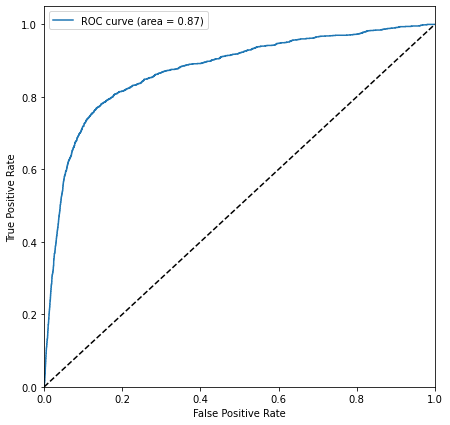

roc_auc_score:  0.8742696808984338


In [136]:
#plotting an roc curve using the train data
draw_roc(y_train_pred_final.Converted, y_train_pred_final.Conversion_probability)

In [137]:
confusion = metrics.confusion_matrix(y_train_pred_final.Converted, y_train_pred_final.predicted)
print(confusion)

[[17896   160]
 [ 1375   227]]


In [138]:
numbers = [float(x)/10 for x in range(10)]
for i in numbers:
    y_train_pred_final[i]= y_train_pred_final["Conversion_probability"].map(lambda x: 1 if x > i else 0)

y_train_pred_final.head()

Converted  Conversion_probability  predicted  0.0  0.1  0.2  0.3  0.4  0.5  \
0  0          0.031348                0          1    0    0    0    0    0     
1  0          0.037847                0          1    0    0    0    0    0     
2  1          0.378475                0          1    1    1    1    0    0     
3  0          0.001866                0          1    0    0    0    0    0     
4  0          0.083299                0          1    0    0    0    0    0     

   0.6  0.7  0.8  0.9  
0  0    0    0    0    
1  0    0    0    0    
2  0    0    0    0    
3  0    0    0    0    
4  0    0    0    0

In [139]:
#calculating various metrics based on different probability cutoffs

from sklearn.metrics import confusion_matrix

cutoff_df = pd.DataFrame(columns = ['probability','accuracy','sensitivity','specificity'])

num = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

for i in num:
    cm1 = metrics.confusion_matrix(y_train_pred_final.Converted, y_train_pred_final[i])
    total1 = sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    
    speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] = [i, accuracy, sensi, speci]
    
print(cutoff_df)

     probability  accuracy  sensitivity  specificity
0.0  0.0          0.081494  1.000000     0.000000   
0.1  0.1          0.816970  0.807740     0.817789   
0.2  0.2          0.897650  0.680400     0.916925   
0.3  0.3          0.919676  0.537453     0.953589   
0.4  0.4          0.923848  0.321473     0.977293   
0.5  0.5          0.921915  0.141698     0.991139   
0.6  0.6          0.920134  0.053683     0.997009   
0.7  0.7          0.918608  0.013733     0.998892   
0.8  0.8          0.918557  0.004370     0.999668   
0.9  0.9          0.918506  0.000000     1.000000   


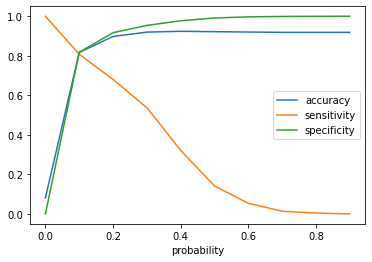

In [140]:
cutoff_df.plot.line(x = 'probability', y = ['accuracy','sensitivity','specificity'])
plt.show()

The point at which accuracy, sensitivity and specificity intersect is at 0.1 on the x-axis. Therefore, we will select this as our cutoff value.

In [141]:
#using our new cutoff

y_train_pred_final['final_predicted'] = y_train_pred_final["Conversion_probability"].map(lambda x: 1 if x > 0.1 else 0)

y_train_pred_final.head()

Converted  Conversion_probability  predicted  0.0  0.1  0.2  0.3  0.4  0.5  \
0  0          0.031348                0          1    0    0    0    0    0     
1  0          0.037847                0          1    0    0    0    0    0     
2  1          0.378475                0          1    1    1    1    0    0     
3  0          0.001866                0          1    0    0    0    0    0     
4  0          0.083299                0          1    0    0    0    0    0     

   0.6  0.7  0.8  0.9  final_predicted  
0  0    0    0    0    0                
1  0    0    0    0    0                
2  0    0    0    0    1                
3  0    0    0    0    0                
4  0    0    0    0    0

In [142]:
confusion2 = metrics.confusion_matrix(y_train_pred_final.Converted, y_train_pred_final.final_predicted)
confusion2

# [1,1]  true positive 
# [0,0]  true negatives
# [0,1]  false positives
# [1,0]  false negatives

array([[14766,  3290],
       [  308,  1294]], dtype=int64)

In [143]:
#Printing the evaluation metrics based on optimum cutoff

print("Accuracy: ", metrics.accuracy_score(y_train_pred_final.Converted, y_train_pred_final.predicted))
print("Precision: ", metrics.precision_score(y_train_pred_final.Converted, y_train_pred_final.predicted))
print("Recall: ", metrics.recall_score(y_train_pred_final.Converted, y_train_pred_final.predicted))
print("roc_auc_score: ", metrics.roc_auc_score(y_train_pred_final.Converted, y_train_pred_final.predicted))

Accuracy:  0.9219147420897345
Precision:  0.58656330749354
Recall:  0.14169787765293385
roc_auc_score:  0.5664182786581018


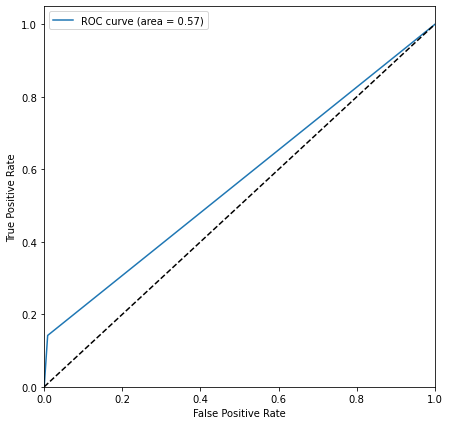

roc_auc_score:  0.5664182786581018


In [144]:
#plotting an roc curve using the train data

draw_roc(y_train_pred_final.Converted, y_train_pred_final.predicted)

In [145]:
#precision and recall tradeoff

from sklearn.metrics import precision_recall_curve

p, r, thresholds = precision_recall_curve(y_train_pred_final.Converted, y_train_pred_final.Conversion_probability)

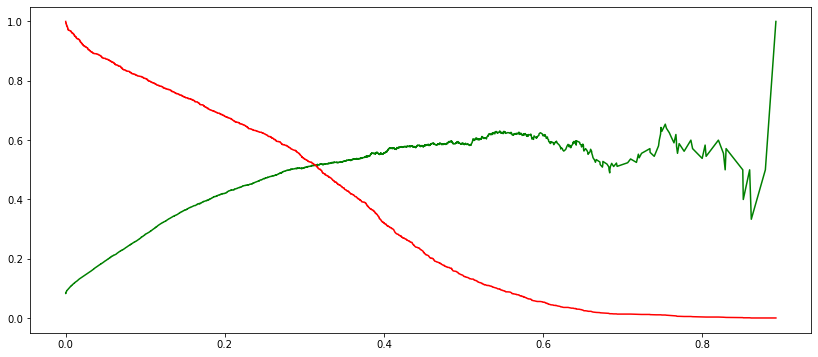

In [146]:
plt.figure(figsize = [14, 6])
plt.plot(thresholds, p[:-1], "g")
plt.plot(thresholds, r[:-1], "r")
plt.show()

The intersection point of recall and precision is approximately at 0.32

In [147]:
#making predictions on the test set

In [148]:
X_test_lr.head()

mobile_number    arpu_6    arpu_7    arpu_8  onnet_mou_6  onnet_mou_7  \
1952   0.064767      -0.876121 -0.869309 -0.590419 -0.558310    -0.557420      
7916  -0.742008      -0.931826 -0.028356 -0.733110 -0.611102    -0.604817      
16179 -1.099791      -0.978893 -0.590589 -0.405660 -0.580489    -0.559491      
4321   1.451608      -0.271550 -0.083765  0.167140 -0.534912    -0.529939      
7499   1.498488       1.122931  0.205397  0.849338 -0.324330    -0.395743      

       onnet_mou_8  offnet_mou_6  offnet_mou_7  offnet_mou_8  roam_ic_mou_6  \
1952  -0.492797    -0.670972     -0.724880     -0.562418     -0.243222        
7916  -0.568051    -0.832584     -0.823030     -0.781238     -0.243222        
16179 -0.476500    -0.640949     -0.726546     -0.486787     -0.243222        
4321  -0.530399     0.771113      0.775127      0.181189     -0.243222        
7499  -0.362215    -0.439600     -0.496726     -0.536996      1.008708        

       roam_ic_mou_7  roam_ic_mou_8  roam_og_mou_6  roam_og_mou_7  \
1952  -0.204672      -0.213925      -0.256909      -0.230119        
7916  -0.204672      -0.213925      -0.256909      -0.230119        
16179 -0.204672      -0.213925      -0.256909      -0.230119        
4321  -0.204672      -0.213925      -0.256909      -0.230119        
7499  -0.204672      -0.213925       0.511478      -0.230119        

       roam_og_mou_8  loc_og_t2t_mou_6  loc_og_t2t_mou_7  loc_og_t2t_mou_8  \
1952  -0.22741       -0.348633         -0.368975         -0.353968           
7916  -0.22741       -0.430819         -0.420314         -0.435902           
16179 -0.22741       -0.362728         -0.318650         -0.221714           
4321  -0.22741       -0.261351         -0.252368         -0.347812           
7499  -0.22741       -0.051441          0.009718         -0.160636           

       loc_og_t2m_mou_6  loc_og_t2m_mou_7  loc_og_t2m_mou_8  loc_og_t2f_mou_6  \
1952  -0.477608         -0.549154         -0.416692         -0.045458           
7916  -0.706162         -0.726932         -0.702734         -0.366899           
16179 -0.388556         -0.565498         -0.182268         -0.234765           
4321   0.787935          0.302390          0.091917          0.279794           
7499  -0.251317         -0.283446         -0.310820          1.273973           

       loc_og_t2f_mou_7  loc_og_t2f_mou_8  loc_og_t2c_mou_6  loc_og_t2c_mou_7  \
1952  -0.371753         -0.368581         -0.301234         -0.303484           
7916  -0.371753         -0.368581         -0.301234         -0.303484           
16179 -0.122100         -0.350953         -0.301234         -0.303484           
4321  -0.155133          0.221943         -0.301234          0.066925           
7499   0.335281         -0.237730         -0.301234         -0.303484           

       loc_og_t2c_mou_8  loc_og_mou_6  loc_og_mou_7  loc_og_mou_8  \
1952  -0.306060         -0.524922     -0.601657     -0.495750       
7916  -0.306060         -0.743023     -0.751305     -0.736831       
16179  0.081437         -0.480870     -0.571524     -0.262078       
4321  -0.306060          0.406703      0.050854     -0.114504       
7499  -0.306060         -0.140069     -0.169382     -0.312035       

       std_og_t2t_mou_6  std_og_t2t_mou_7  std_og_t2t_mou_8  std_og_t2m_mou_6  \
1952  -0.417278         -0.413181         -0.357345         -0.431639           
7916  -0.434746         -0.440051         -0.401632         -0.465210           
16179 -0.434746         -0.440051         -0.401632         -0.465210           
4321  -0.434746         -0.440051         -0.401632          0.460139           
7499  -0.417547         -0.421041         -0.304533         -0.433250           

       std_og_t2m_mou_7  std_og_t2m_mou_8  std_og_t2f_mou_6  std_og_t2f_mou_7  \
1952  -0.453508         -0.346378         -0.108107         -0.184248           
7916  -0.463341         -0.429879         -0.187549         -0.184248           
16179 -0.459190         -0.429879          0.369

In [149]:
X_test_sm = sm.add_constant(X_test_lr[col])

In [150]:
y_test_pred = res.predict(X_test_sm)

In [151]:
y_test_pred[:10]

1952     5.554457e-02
7916     1.737221e-02
16179    1.115077e-01
4321     2.757116e-02
7499     3.701220e-03
13463    3.194864e-03
9553     2.476949e-07
24678    5.963796e-01
20915    3.261737e-04
2504     4.001211e-02
dtype: float64

In [152]:
y_test_pred_final = pd.DataFrame({'Converted': y_test_lr.ravel(), 'Conversion_probability': y_test_pred})
y_test_pred_final['predicted'] = y_test_pred_final["Conversion_probability"].map(lambda x: 1 if x > 0.32 else 0) #using the cutoff of 0.32

y_test_pred_final.head(10)

Converted  Conversion_probability  predicted
1952   0          5.554457e-02            0        
7916   0          1.737221e-02            0        
16179  0          1.115077e-01            0        
4321   0          2.757116e-02            0        
7499   0          3.701220e-03            0        
13463  0          3.194864e-03            0        
9553   0          2.476949e-07            0        
24678  0          5.963796e-01            1        
20915  0          3.261737e-04            0        
2504   0          4.001211e-02            0

In [153]:
#evaluating metrics

print("Accuracy: ", metrics.accuracy_score(y_test_pred_final.Converted, y_test_pred_final.predicted))
print("Precision: ", metrics.precision_score(y_test_pred_final.Converted, y_test_pred_final.predicted))
print("Recall: ", metrics.recall_score(y_test_pred_final.Converted, y_test_pred_final.predicted))
print("roc_auc_score: ", metrics.roc_auc_score(y_test_pred_final.Converted, y_test_pred_final.predicted))

Accuracy:  0.9175074183976261
Precision:  0.4745269286754003
Recall:  0.49393939393939396
roc_auc_score:  0.7237243653534703


In [154]:
TP = metrics.confusion_matrix(y_test_pred_final.Converted, y_test_pred_final.predicted)[1,1] # true positive 
TN = metrics.confusion_matrix(y_test_pred_final.Converted, y_test_pred_final.predicted)[0,0] # true negatives
FP = metrics.confusion_matrix(y_test_pred_final.Converted, y_test_pred_final.predicted)[0,1] # false positives
FN = metrics.confusion_matrix(y_test_pred_final.Converted, y_test_pred_final.predicted)[1,0] # false negatives

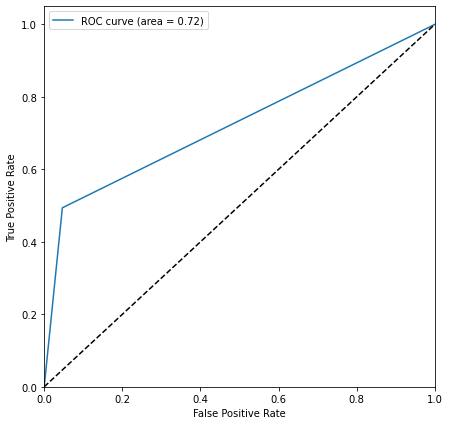

roc_auc_score:  0.7237243653534703


In [155]:
#plotting an roc curve using the test data

draw_roc(y_test_pred_final.Converted, y_test_pred_final.predicted)

In [156]:
compare_dataframe_log = pd.DataFrame({"Accuracy": metrics.accuracy_score(y_test_pred_final.Converted, y_test_pred_final.predicted),
                                      "Precision": metrics.precision_score(y_test_pred_final.Converted, y_test_pred_final.predicted),
                                      "Recall": metrics.recall_score(y_test_pred_final.Converted, y_test_pred_final.predicted),
                                      "Sensitivity": TP/float(TP+FN),
                                      "Specificity": TN/float(TN+FP),
                                      "roc_auc_score": metrics.roc_auc_score(y_test_pred_final.Converted, y_test_pred_final.predicted)}, index = ["Log. Reg. without PCA (RFE, P-values & VIF)"])

compare_dataframe = pd.concat([compare_dataframe, compare_dataframe_log])

compare_dataframe

Accuracy  Precision  \
Log. Reg. (with PCA)                             0.836558  0.297343    
Log. Reg. with hyperparameter Tuning (with PCA)  0.814243  0.273410    
Log. Reg. without PCA (RFE, P-values & VIF)      0.917507  0.474527    

                                                   Recall  Sensitivity  \
Log. Reg. (with PCA)                             0.796970  0.796970      
Log. Reg. with hyperparameter Tuning (with PCA)  0.827273  0.827273      
Log. Reg. without PCA (RFE, P-values & VIF)      0.493939  0.493939      

                                                 Specificity  roc_auc_score  
Log. Reg. (with PCA)                             0.839923     0.818446       
Log. Reg. with hyperparameter Tuning (with PCA)  0.813136     0.820204       
Log. Reg. without PCA (RFE, P-values & VIF)      0.953509     0.723724

# 5. Random Forest Model (With PCA)

In [157]:
# Importing random forest classifier
from sklearn.ensemble import RandomForestClassifier

#Creating a random forest with default parameters
rfc = RandomForestClassifier()

rfc.fit(X_train_pca, y_train)

RandomForestClassifier()

In [158]:
# Making predictions
y_pred_rf = rfc.predict(X_test_pca)

In [159]:
# Importing classification report and confusion matrix
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score

In [160]:
# Checking the report of our default model
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.96      0.94      0.95      7765
           1       0.42      0.49      0.45       660

    accuracy                           0.91      8425
   macro avg       0.69      0.71      0.70      8425
weighted avg       0.91      0.91      0.91      8425



### 5.1 Performing hyperparameter tuning

In [161]:
# GridSearchCV to find optimal min_samples_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

# Creating a parameter grid to the best paramteres

param_grid = {
    'max_depth': [4,8,10],
    'min_samples_leaf': [5,10,20,50,100,200],
    'n_estimators': [100,200, 300]
}

# Creating an rf model
rf = RandomForestClassifier()

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, 
                           param_grid = param_grid,
                           scoring= 'roc_auc', #Strategy to evaluate the performance of the cross-validated model on the test set
                           cv = 3,
                           n_jobs = -1,
                           verbose = 1)

# Fitting the grid search to the data
grid_search.fit(X_train_pca, y_train)

Fitting 3 folds for each of 54 candidates, totalling 162 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [4, 8, 10],
                         'min_samples_leaf': [5, 10, 20, 50, 100, 200],
                         'n_estimators': [100, 200, 300]},
             scoring='roc_auc', verbose=1)

In [162]:
# printing the optimal accuracy score and hyperparameters
print('Optimal score:', grid_search.best_score_, '\nOptimal hyperparameters: ', grid_search.best_params_)

Optimal score: 0.9549137091926619 
Optimal hyperparameters:  {'max_depth': 10, 'min_samples_leaf': 5, 'n_estimators': 300}


In [163]:
# modelling random forest with the optimum hyperparameters
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(bootstrap = True,
                             max_depth = grid_search.best_params_["max_depth"],
                             min_samples_leaf = grid_search.best_params_["min_samples_leaf"], 
                             n_estimators = grid_search.best_params_["n_estimators"])

In [164]:
#fitting the data
rfc.fit(X_train_pca, y_train)

#making predictions using the train data
y_train_pred_rf = rfc.predict(X_train_pca)

#making predictions using the test data
y_pred_rf = rfc.predict(X_test_pca)

In [165]:
#to display metrics
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.97      0.89      0.93      7765
           1       0.34      0.69      0.46       660

    accuracy                           0.87      8425
   macro avg       0.66      0.79      0.69      8425
weighted avg       0.92      0.87      0.89      8425



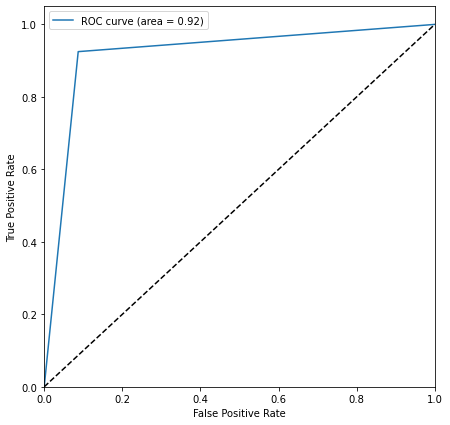

roc_auc_score:  0.9188912272928667


In [166]:
#plotting an roc curve using the train data
draw_roc(y_train, y_train_pred_rf)

In [167]:
# metrics
print(metrics.confusion_matrix(y_test, y_pred_rf), "\n") #printing the confusion matrix
print("Accuracy: ", metrics.accuracy_score(y_test, y_pred_rf))
print("Precision: ", metrics.precision_score(y_test, y_pred_rf))
print("Sensitivity/recall: ", metrics.recall_score(y_test, y_pred_rf))
print("roc_auc_score: ", metrics.roc_auc_score(y_test, y_pred_rf))

[[6883  882]
 [ 204  456]] 

Accuracy:  0.8710979228486647
Precision:  0.34080717488789236
Sensitivity/recall:  0.6909090909090909
roc_auc_score:  0.7886612421705789


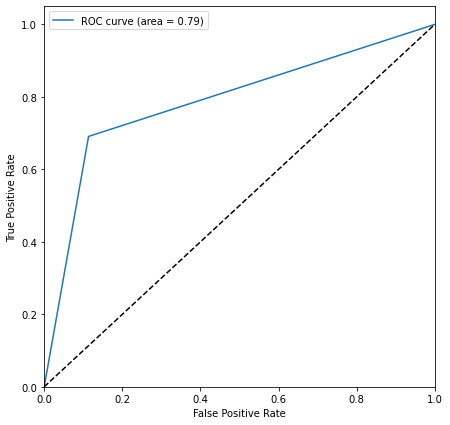

roc_auc_score:  0.7886612421705789


In [168]:
#plotting the roc curve using the test data
draw_roc(y_test, y_pred_rf)

In [169]:
TP = metrics.confusion_matrix(y_test, y_pred_rf)[1,1] # true positive 
TN = metrics.confusion_matrix(y_test, y_pred_rf)[0,0] # true negatives
FP = metrics.confusion_matrix(y_test, y_pred_rf)[0,1] # false positives
FN = metrics.confusion_matrix(y_test, y_pred_rf)[1,0] # false negatives

In [170]:
compare_dataframe_rf = pd.DataFrame({"Accuracy": metrics.accuracy_score(y_test, y_pred_rf),
                                  "Precision": metrics.precision_score(y_test, y_pred_rf),
                                  "Recall": metrics.recall_score(y_test, y_pred_rf),
                                  "Sensitivity": TP/float(TP+FN),
                                  "Specificity": TN/float(TN+FP),
                                  "roc_auc_score": metrics.roc_auc_score(y_test, y_pred_rf)}, index = ["Random Forest (with PCA)"])

compare_dataframe = pd.concat([compare_dataframe, compare_dataframe_rf])

compare_dataframe

Accuracy  Precision  \
Log. Reg. (with PCA)                             0.836558  0.297343    
Log. Reg. with hyperparameter Tuning (with PCA)  0.814243  0.273410    
Log. Reg. without PCA (RFE, P-values & VIF)      0.917507  0.474527    
Random Forest (with PCA)                         0.871098  0.340807    

                                                   Recall  Sensitivity  \
Log. Reg. (with PCA)                             0.796970  0.796970      
Log. Reg. with hyperparameter Tuning (with PCA)  0.827273  0.827273      
Log. Reg. without PCA (RFE, P-values & VIF)      0.493939  0.493939      
Random Forest (with PCA)                         0.690909  0.690909      

                                                 Specificity  roc_auc_score  
Log. Reg. (with PCA)                             0.839923     0.818446       
Log. Reg. with hyperparameter Tuning (with PCA)  0.813136     0.820204       
Log. Reg. without PCA (RFE, P-values & VIF)      0.953509     0.723724       
Random Forest (with PCA)                         0.886413     0.788661

# 6. XGBoost Model (With PCA)

In [171]:
print(X_train_pca.shape)
print(y_train.shape)

(36112, 50)
(36112,)


In [172]:
import xgboost as xgb
from sklearn import metrics

#creating an xgboost model and fitting it

xgclf = xgb.XGBClassifier()

xgclf.fit(X_train_pca, y_train)

[13:20:04] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [173]:
print('AUC on train data by XGBoost:', metrics.roc_auc_score(y_true = y_train, y_score = xgclf.predict_proba(X_train_pca)[:, 1]))

print('AUC on test data by XGBoost:', metrics.roc_auc_score(y_true = y_test, y_score = xgclf.predict_proba(X_test_pca)[:, 1]))

AUC on train data by XGBoost: 0.9995249818710029
AUC on test data by XGBoost: 0.8603750317079357


In [174]:
#making predictions using the train data
y_train_pred_xgclf = xgclf.predict(X_train_pca)

##making predictions using the test data
y_pred_xgclf = xgclf.predict(X_test_pca)

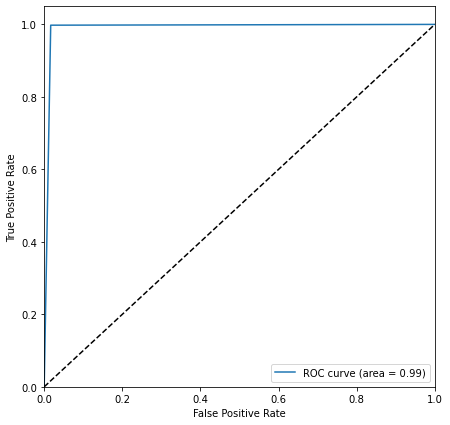

roc_auc_score:  0.9905848471422242


In [175]:
#plotting an roc curve using the train data
draw_roc(y_train, y_train_pred_xgclf)

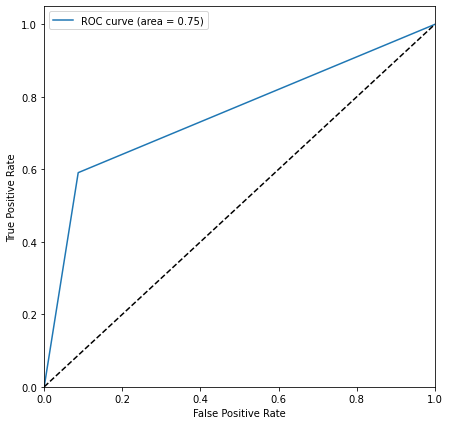

roc_auc_score:  0.7519258912369021


In [176]:
#plotting an roc curve using the test data
draw_roc(y_test, y_pred_xgclf)

In [177]:
X_train_pca.columns

RangeIndex(start=0, stop=50, step=1)

In [178]:
from sklearn import model_selection

xgb_model = xgb.XGBClassifier()

#passing a list of few hyperparameters to find the best ones among them

parameters = {'learning_rate': [0.1, 0.3, 0.5],
              'max_depth': [3, 6, 9],
              'min_child_weight': [1],
              'n_estimators': [50, 70, 100]}

scorer = metrics.make_scorer(metrics.roc_auc_score,
                             greater_is_better = True,
                             needs_proba = True, #default is false. Whether score_func requires predict_proba to get probability estimates out of a classifier.
                             needs_threshold = False) #Whether score_func takes a continuous decision certainty.

clf_xgb = model_selection.GridSearchCV(estimator = xgb_model,
                                       param_grid = parameters,
                                       n_jobs = -1, #to use all cores possible
                                       cv = 3,
                                       scoring = scorer,
                                       refit = True)

clf_xgb.fit(X_train_pca, y_train)

[13:33:34] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     enable_categorical=False, gamma=None,
                                     gpu_id=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,...
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight=None,
                                     subsample=None, tree_

In [179]:
print(clf_xgb.best_params_)
print(clf_xgb.best_score_)
print(clf_xgb.best_estimator_)

{'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 100}
0.9895770136214154
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.3, max_delta_step=0,
              max_depth=9, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)


In [180]:
clf_xgb.best_params_["n_estimators"]

100

In [181]:
#Using optimal parameters as per the above output

final_model = xgb.XGBClassifier(learning_rate = clf_xgb.best_params_["learning_rate"],
                                max_depth = clf_xgb.best_params_["max_depth"],
                                min_child_weight = clf_xgb.best_params_["min_child_weight"],
                                n_estimators = clf_xgb.best_params_["n_estimators"])

final_model.fit(X_train_pca, y_train)

print('AUC on train data by XGBoost =', metrics.roc_auc_score(y_true=y_train,
                                                              y_score=final_model.predict_proba(X_train_pca)[:, 1]))

print('AUC on test data by XGBoost =', metrics.roc_auc_score(y_true=y_test,
                                                             y_score=final_model.predict_proba(X_test_pca)[:, 1]))

[13:34:10] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
AUC on train data by XGBoost = 1.0
AUC on test data by XGBoost = 0.8636848523873637


In [182]:
#making predictions using the final model's train data
y_train_pred_xgb = final_model.predict(X_train_pca)

#making predictions using the final model
y_pred_xgb = final_model.predict(X_test_pca)

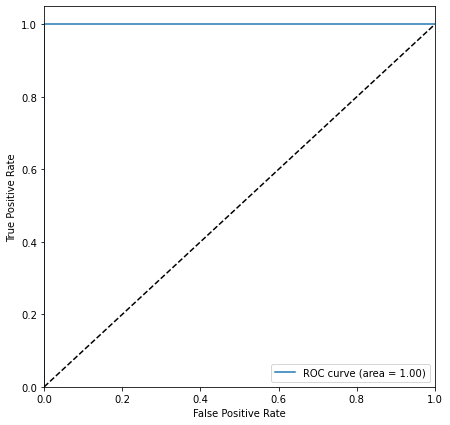

roc_auc_score:  1.0


In [183]:
#plotting an roc curve using the train data
draw_roc(y_train, y_train_pred_xgb)

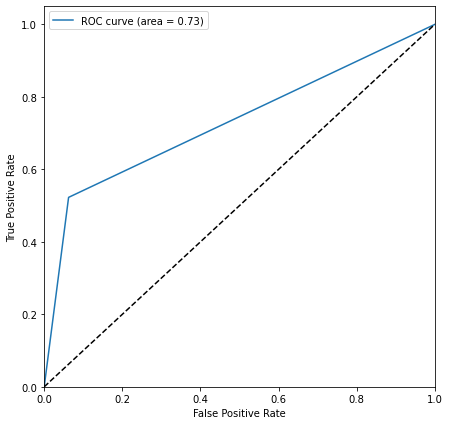

roc_auc_score:  0.730133758707487


In [184]:
#plotting an roc curve using the test data
draw_roc(y_test, y_pred_xgb)

In [185]:
#calculating the recall and precision scores
print(metrics.recall_score(y_test, y_pred_xgb))
print(metrics.precision_score(y_test, y_pred_xgb))

0.5227272727272727
0.41566265060240964


In [186]:
#creating the confusion matrix

TP = metrics.confusion_matrix(y_test, y_pred_xgb)[1,1] # true positive 
TN = metrics.confusion_matrix(y_test, y_pred_xgb)[0,0] # true negatives
FP = metrics.confusion_matrix(y_test, y_pred_xgb)[0,1] # false positives
FN = metrics.confusion_matrix(y_test, y_pred_xgb)[1,0] # false negatives

In [187]:
compare_dataframe_xgb = pd.DataFrame({"Accuracy": metrics.accuracy_score(y_test, y_pred_xgb),
                                      "Precision": metrics.precision_score(y_test, y_pred_xgb),
                                      "Recall": metrics.recall_score(y_test, y_pred_xgb),
                                      "Sensitivity": TP/float(TP+FN),
                                      "Specificity": TN/float(TN+FP),
                                      "roc_auc_score": metrics.roc_auc_score(y_test, y_pred_xgb)}, index = ["XGBoost (with PCA)"])

compare_dataframe = pd.concat([compare_dataframe, compare_dataframe_xgb])

compare_dataframe

Accuracy  Precision  \
Log. Reg. (with PCA)                             0.836558  0.297343    
Log. Reg. with hyperparameter Tuning (with PCA)  0.814243  0.273410    
Log. Reg. without PCA (RFE, P-values & VIF)      0.917507  0.474527    
Random Forest (with PCA)                         0.871098  0.340807    
XGBoost (with PCA)                               0.905045  0.415663    

                                                   Recall  Sensitivity  \
Log. Reg. (with PCA)                             0.796970  0.796970      
Log. Reg. with hyperparameter Tuning (with PCA)  0.827273  0.827273      
Log. Reg. without PCA (RFE, P-values & VIF)      0.493939  0.493939      
Random Forest (with PCA)                         0.690909  0.690909      
XGBoost (with PCA)                               0.522727  0.522727      

                                                 Specificity  roc_auc_score  
Log. Reg. (with PCA)                             0.839923     0.818446       
Log. Reg. with hyperparameter Tuning (with PCA)  0.813136     0.820204       
Log. Reg. without PCA (RFE, P-values & VIF)      0.953509     0.723724       
Random Forest (with PCA)                         0.886413     0.788661       
XGBoost (with PCA)                               0.937540     0.730134

# 7. Decision Tree Model (With PCA)

In [188]:
from sklearn.tree import DecisionTreeClassifier

In [189]:
y_train.shape

(36112,)

In [190]:
#creating a decision tree with the default parameters (except class_weight and max_depth)

#keeping the depth as a small number so as to control overfitting

dt_def = DecisionTreeClassifier(class_weight = "balanced", max_depth = 10) #use of balanced in class weight:  it basically means replicating the smaller classes until we have as many samples as in the larger one, but in an implicit way
dt_def.fit(X_train_pca, y_train)

DecisionTreeClassifier(class_weight='balanced', max_depth=10)

In [191]:
#making predictions using the train data
y_train_pred_dt = dt_def.predict(X_train_pca)

#making predictions using the test data
y_pred_dt = dt_def.predict(X_test_pca)

In [192]:
from sklearn.metrics import accuracy_score

#calculating some metrics

print("Train Accuracy :", accuracy_score(y_train, y_train_pred_dt))
print("x"+ "-"*50 + "x")
print("Test Accuracy :", accuracy_score(y_test, y_pred_dt))

Train Accuracy : 0.8959625609215773
x--------------------------------------------------x
Test Accuracy : 0.800593471810089


In [193]:
#creating the confusion matrix for the train data

confusion_tree = confusion_matrix(y_train, y_train_pred_dt)

TP = confusion_tree[1,1] # true positive 
TN = confusion_tree[0,0] # true negatives
FP = confusion_tree[0,1] # false positives
FN = confusion_tree[1,0] # false negatives

print('Acuracy:', accuracy_score(y_train, y_train_pred_dt))
print('Sensitivity:', TP/float(TP+FN))
print('Specificity:', TN/float(TN+FP))
print('Precision:', TP/float(TP+FP))
print('Recall:', TN/float(TN+ FN))

Acuracy: 0.8959625609215773
Sensitivity: 0.9259525919361985
Specificity: 0.8659725299069562
Precision: 0.873556612153195
Recall: 0.9212278324397573


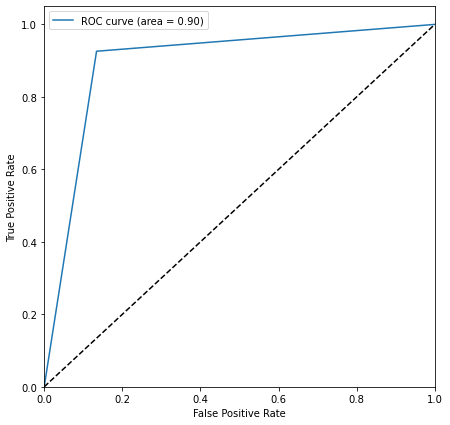

roc_auc_score:  0.8959625609215772


In [194]:
#plotting roc curve for the train data
draw_roc(y_train, y_train_pred_dt)

In [195]:
#creating the confusion matrix for the test data

confusion_tree = confusion_matrix(y_test, y_pred_dt)

TP = confusion_tree[1,1] # true positive 
TN = confusion_tree[0,0] # true negatives
FP = confusion_tree[0,1] # false positives
FN = confusion_tree[1,0] # false negatives

print('Acuracy:', accuracy_score(y_test, y_pred_dt))
print('Sensitivity:', TP/float(TP+FN))
print('Specificity:', TN/float(TN+FP))
print('Precision:', TP/float(TP+FP))
print('Recall:', TN/float(TN+ FN))

Acuracy: 0.800593471810089
Sensitivity: 0.6712121212121213
Specificity: 0.8115904700579524
Precision: 0.2324239244491081
Recall: 0.9667126859947844


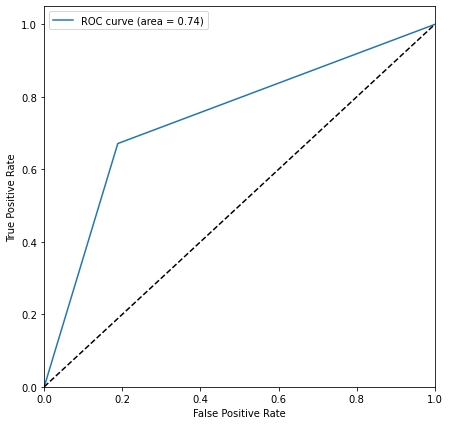

roc_auc_score:  0.7414012956350369


In [196]:
#plotting roc curve for the test data
draw_roc(y_test, y_pred_dt)

In [197]:
#creating the confusion matrix

TP = metrics.confusion_matrix(y_test, y_pred_rf)[1,1] # true positive 
TN = metrics.confusion_matrix(y_test, y_pred_rf)[0,0] # true negatives
FP = metrics.confusion_matrix(y_test, y_pred_rf)[0,1] # false positives
FN = metrics.confusion_matrix(y_test, y_pred_rf)[1,0] # false negatives

In [198]:
compare_dataframe_dt = pd.DataFrame({"Accuracy": accuracy_score(y_test, y_pred_dt),
                                      "Precision": TP/float(TP+FP),
                                      "Recall": TN/float(TN+ FN),
                                      "Sensitivity": TP/float(TP+FN),
                                      "Specificity": TN/float(TN+FP),
                                      "roc_auc_score": metrics.roc_auc_score(y_test, y_pred_dt)}, index = ["Decision Tree (with PCA)"])

compare_dataframe = pd.concat([compare_dataframe, compare_dataframe_dt])

# 8. Visualization of The Best Variables

In [199]:
#creating a function for plotting the best variables

def important_features(impo, title):
  imp = impo
  names = X.columns.values
  imp, names = zip(*sorted(zip(imp, names)))

  df_1 = pd.DataFrame({"Variable": names, "importance": imp})
  df_2 = df_1.sort_values(by= "importance", axis = 0, ascending = False)
  df_2 = df_2.reset_index(drop = True)
  sns.set_theme(style = "whitegrid")

  plt.figure(figsize = [25, 10])

  ax = sns.barplot(x = 'Variable', y = 'importance', data = df_2[0:20], palette = "dark")
  ax.set(xlabel = 'Top 20 Features', ylabel = 'Importance')
  plt.xticks(rotation = 45)
  plt.title(title)
  plt.show()

In [200]:
#to create a dataframe of the important variables

def important_features_df(impo):
  imp = impo
  names = X.columns.values
  imp, names = zip(*sorted(zip(imp, names)))

  df_1 = pd.DataFrame({"Variable": names, "importance": imp})
  df_2 = df_1.sort_values(by= "importance", axis = 0, ascending = False)
  df_2 = df_2.reset_index(drop = True)

  return df_2

## 8.1 Visualizing the best variables of Random Forest Model

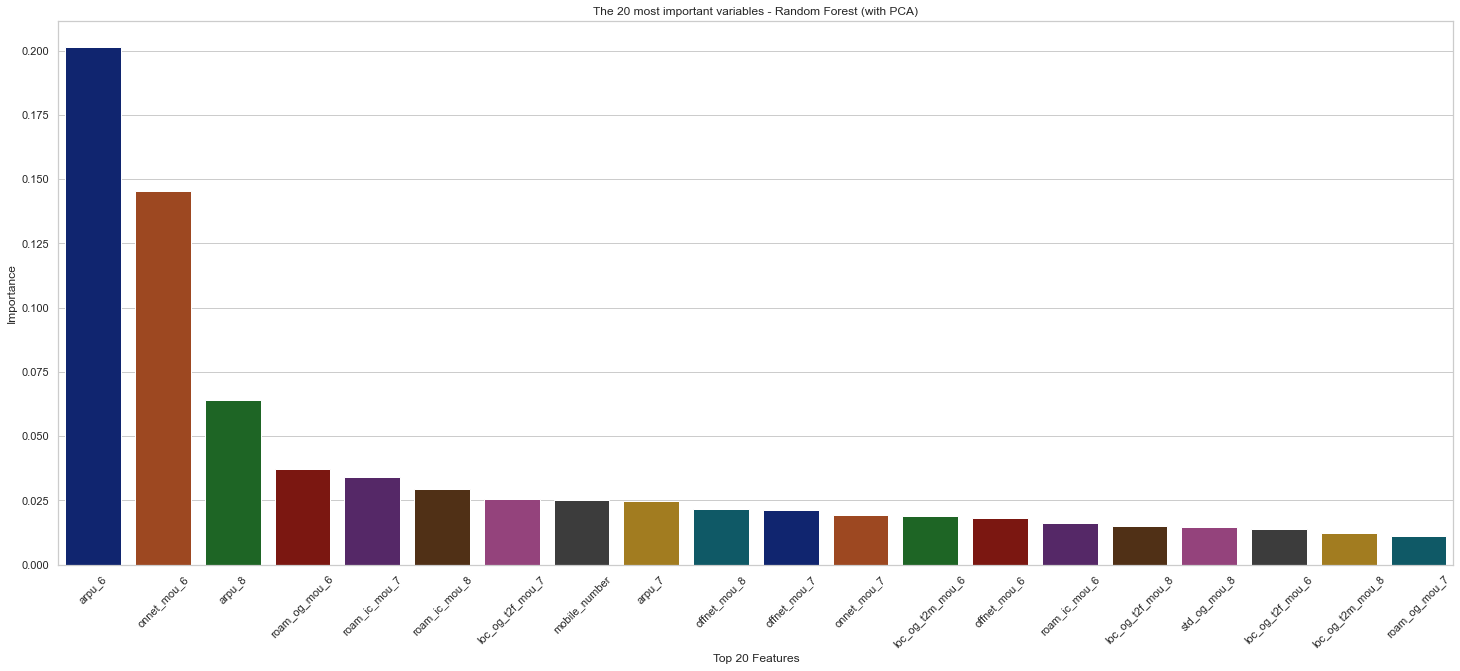

In [201]:
important_features(rfc.feature_importances_, "The 20 most important variables - Random Forest (with PCA)")

In [202]:
#listing the most important variables above

important_features_df(rfc.feature_importances_)

Variable  importance
0   arpu_6            0.201488  
1   onnet_mou_6       0.145509  
2   arpu_8            0.063999  
3   roam_og_mou_6     0.037051  
4   roam_ic_mou_7     0.033993  
5   roam_ic_mou_8     0.029600  
6   loc_og_t2f_mou_7  0.025361  
7   mobile_number     0.025016  
8   arpu_7            0.024898  
9   offnet_mou_8      0.021607  
10  offnet_mou_7      0.021220  
11  onnet_mou_7       0.019369  
12  loc_og_t2m_mou_6  0.018922  
13  offnet_mou_6      0.017999  
14  roam_ic_mou_6     0.015984  
15  loc_og_t2f_mou_8  0.015055  
16  std_og_mou_8      0.014592  
17  loc_og_t2f_mou_6  0.013920  
18  loc_og_t2m_mou_8  0.012195  
19  roam_og_mou_7     0.011111  
20  loc_og_t2t_mou_8  0.010969  
21  loc_og_t2t_mou_6  0.010537  
22  onnet_mou_8       0.010229  
23  std_og_t2t_mou_8  0.010193  
24  loc_og_t2c_mou_7  0.010181  
25  loc_og_t2m_mou_7  0.009379  
26  spl_og_mou_6      0.009256  
27  std_og_t2f_mou_7  0.008958  
28  spl_og_mou_8      0.008570  
29  loc_og_t2t_mou_7  0.008532  
30  loc_og_mou_8      0.008495  
31  loc_og_t2c_mou_8  0.007968  
32  std_og_t2m_mou_8  0.007751  
33  std_og_t2m_mou_6  0.007574  
34  loc_og_mou_7      0.007525  
35  std_og_t2f_mou_8  0.007456  
36  spl_og_mou_7      0.007393  
37  std_og_t2m_mou_7  0.007374  
38  isd_og_mou_6      0.007158  
39  std_og_mou_6      0.007007  
40  std_og_t2f_mou_6  0.006878  
41  roam_og_mou_8     0.006372  
42  std_og_mou_7      0.006244  
43  isd_og_mou_7      0.006211  
44  loc_og_t2c_mou_6  0.006181  
45  loc_og_mou_6      0.005963  
46  og_others_6       0.005574  
47  std_og_t2t_mou_6  0.005191  
48  std_og_t2t_mou_7  0.005175  
49  isd_og_mou_8      0.004817

## 8.2 Visualizing best variables of XGBoost model

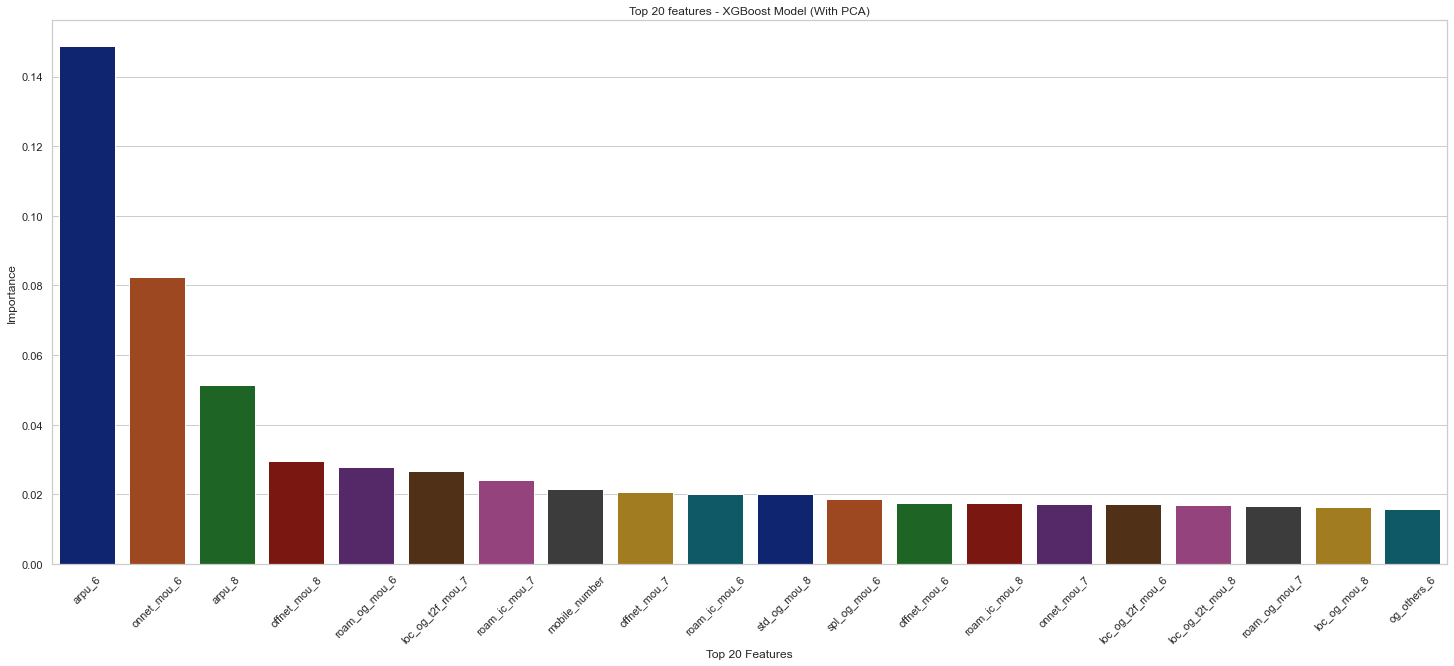

In [203]:
important_features(xgclf.feature_importances_, "Top 20 features - XGBoost Model (With PCA)")

In [204]:
#listing the most important variables above

important_features_df(xgclf.feature_importances_)

Variable  importance
0   arpu_6            0.148721  
1   onnet_mou_6       0.082319  
2   arpu_8            0.051520  
3   offnet_mou_8      0.029488  
4   roam_og_mou_6     0.027777  
5   loc_og_t2f_mou_7  0.026613  
6   roam_ic_mou_7     0.024095  
7   mobile_number     0.021639  
8   offnet_mou_7      0.020684  
9   roam_ic_mou_6     0.019944  
10  std_og_mou_8      0.019939  
11  spl_og_mou_6      0.018566  
12  offnet_mou_6      0.017531  
13  roam_ic_mou_8     0.017449  
14  onnet_mou_7       0.017233  
15  loc_og_t2f_mou_6  0.017152  
16  loc_og_t2t_mou_8  0.016964  
17  roam_og_mou_7     0.016522  
18  loc_og_mou_8      0.016262  
19  og_others_6       0.015674  
20  spl_og_mou_8      0.014764  
21  loc_og_t2t_mou_6  0.014569  
22  onnet_mou_8       0.014493  
23  loc_og_t2m_mou_8  0.014154  
24  loc_og_t2t_mou_7  0.014039  
25  std_og_mou_6      0.013948  
26  loc_og_t2c_mou_7  0.013940  
27  loc_og_t2f_mou_8  0.013878  
28  std_og_t2t_mou_8  0.013788  
29  loc_og_t2m_mou_6  0.013708  
30  loc_og_t2c_mou_8  0.013678  
31  std_og_t2m_mou_7  0.013321  
32  std_og_t2f_mou_6  0.013193  
33  std_og_t2t_mou_6  0.012976  
34  std_og_t2t_mou_7  0.012585  
35  arpu_7            0.012354  
36  roam_og_mou_8     0.012262  
37  std_og_mou_7      0.012242  
38  spl_og_mou_7      0.012195  
39  loc_og_mou_7      0.012160  
40  std_og_t2f_mou_7  0.011991  
41  isd_og_mou_7      0.011972  
42  loc_og_t2c_mou_6  0.011966  
43  std_og_t2m_mou_8  0.011850  
44  std_og_t2m_mou_6  0.011235  
45  isd_og_mou_8      0.010597  
46  loc_og_mou_6      0.010258  
47  isd_og_mou_6      0.009606  
48  std_og_t2f_mou_8  0.008492  
49  loc_og_t2m_mou_7  0.007697

## 8.3 Visualizing best variables of Decision Tree model

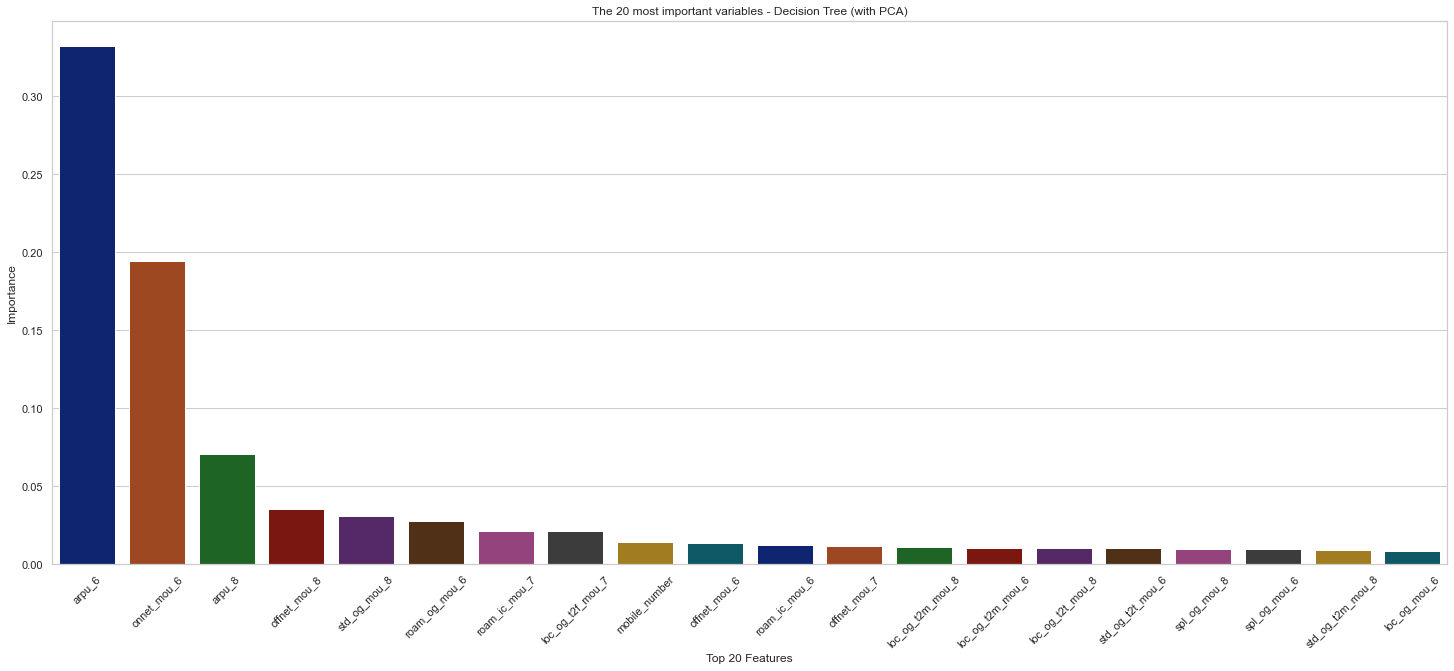

In [205]:
important_features(dt_def.feature_importances_, "The 20 most important variables - Decision Tree (with PCA)")

In [206]:
#listing the most important variables above

important_features_df(dt_def.feature_importances_)

Variable  importance
0   arpu_6            0.331885  
1   onnet_mou_6       0.194535  
2   arpu_8            0.070704  
3   offnet_mou_8      0.035186  
4   std_og_mou_8      0.030887  
5   roam_og_mou_6     0.027413  
6   roam_ic_mou_7     0.021445  
7   loc_og_t2f_mou_7  0.021040  
8   mobile_number     0.014426  
9   offnet_mou_6      0.013494  
10  roam_ic_mou_6     0.012616  
11  offnet_mou_7      0.011523  
12  loc_og_t2m_mou_8  0.010950  
13  loc_og_t2m_mou_6  0.010527  
14  loc_og_t2t_mou_8  0.010112  
15  std_og_t2t_mou_6  0.010103  
16  spl_og_mou_8      0.009723  
17  spl_og_mou_6      0.009713  
18  std_og_t2m_mou_8  0.009228  
19  loc_og_mou_6      0.008582  
20  spl_og_mou_7      0.008429  
21  onnet_mou_7       0.007619  
22  std_og_t2m_mou_7  0.007613  
23  onnet_mou_8       0.007606  
24  loc_og_t2t_mou_7  0.006702  
25  roam_ic_mou_8     0.006430  
26  loc_og_t2f_mou_6  0.006224  
27  std_og_t2t_mou_7  0.005769  
28  std_og_t2t_mou_8  0.005552  
29  roam_og_mou_7     0.005421  
30  loc_og_t2c_mou_8  0.005295  
31  og_others_6       0.005063  
32  loc_og_mou_7      0.004738  
33  loc_og_t2c_mou_7  0.004713  
34  std_og_t2f_mou_6  0.004347  
35  loc_og_mou_8      0.004317  
36  std_og_mou_7      0.004250  
37  std_og_t2m_mou_6  0.004185  
38  loc_og_t2c_mou_6  0.003875  
39  std_og_mou_6      0.003689  
40  loc_og_t2f_mou_8  0.003455  
41  loc_og_t2t_mou_6  0.003359  
42  isd_og_mou_8      0.003224  
43  isd_og_mou_7      0.003221  
44  std_og_t2f_mou_8  0.003124  
45  arpu_7            0.003032  
46  std_og_t2f_mou_7  0.002603  
47  roam_og_mou_8     0.001445  
48  isd_og_mou_6      0.000392  
49  loc_og_t2m_mou_7  0.000218

## 8.4 Visualizing the best variables of Logistic Regression with PCA (default parameter tuning)

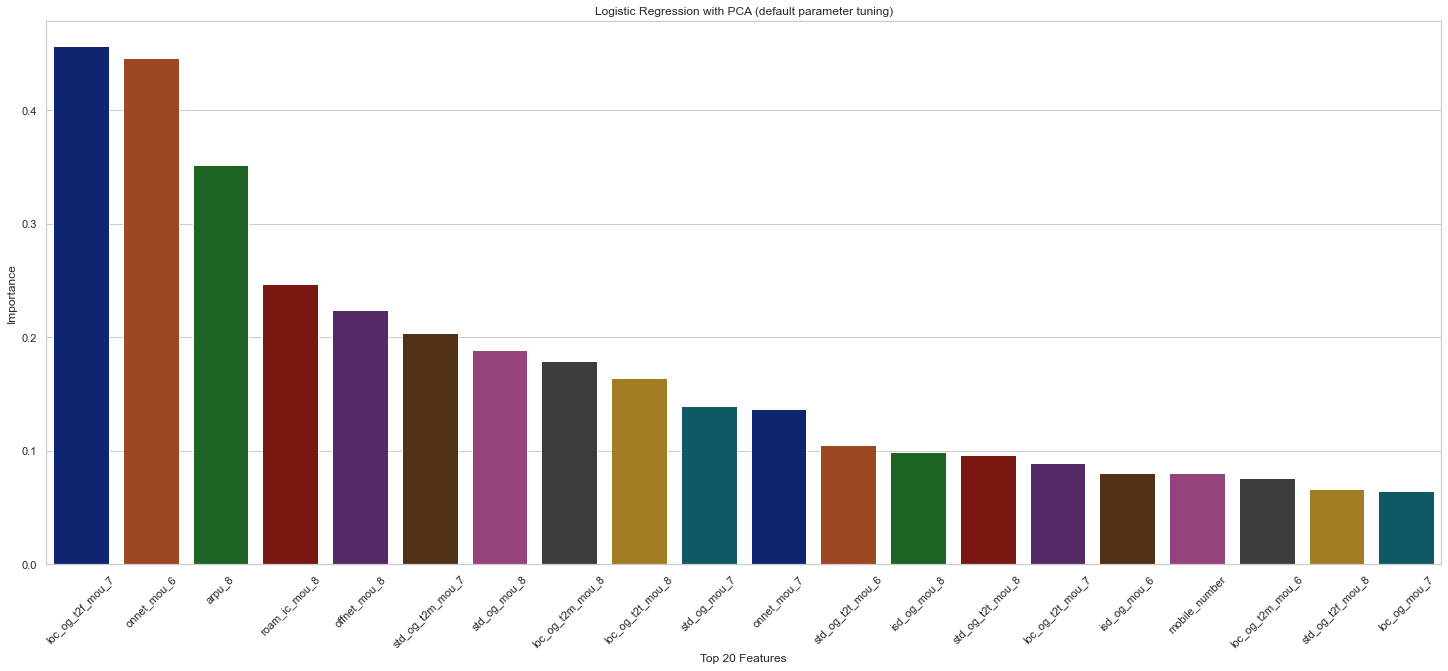

In [207]:
important_features(model_pca.coef_[0], "Logistic Regression with PCA (default parameter tuning)")

In [208]:
#listing the important variables

important_features_df(model_pca.coef_[0])

Variable  importance
0   loc_og_t2f_mou_7  0.455976  
1   onnet_mou_6       0.445843  
2   arpu_8            0.351288  
3   roam_ic_mou_8     0.246992  
4   offnet_mou_8      0.223938  
5   std_og_t2m_mou_7  0.203224  
6   std_og_mou_8      0.189043  
7   loc_og_t2m_mou_8  0.178866  
8   loc_og_t2t_mou_8  0.163784  
9   std_og_mou_7      0.139140  
10  onnet_mou_7       0.136869  
11  std_og_t2t_mou_6  0.104807  
12  isd_og_mou_8      0.099175  
13  std_og_t2t_mou_8  0.095850  
14  loc_og_t2t_mou_7  0.089183  
15  isd_og_mou_6      0.080518  
16  mobile_number     0.080353  
17  loc_og_t2m_mou_6  0.075505  
18  std_og_t2f_mou_8  0.066251  
19  loc_og_mou_7      0.064797  
20  roam_og_mou_8     0.063473  
21  offnet_mou_6      0.030539  
22  onnet_mou_8       0.022572  
23  loc_og_t2c_mou_8  0.017921  
24  arpu_7            0.005954  
25  loc_og_t2t_mou_6 -0.001851  
26  spl_og_mou_7     -0.011105  
27  std_og_t2f_mou_6 -0.022056  
28  offnet_mou_7     -0.041250  
29  og_others_6      -0.056559  
30  std_og_t2m_mou_6 -0.056661  
31  std_og_mou_6     -0.063237  
32  loc_og_t2c_mou_6 -0.072815  
33  isd_og_mou_7     -0.086934  
34  std_og_t2t_mou_7 -0.088251  
35  loc_og_t2m_mou_7 -0.089267  
36  loc_og_t2c_mou_7 -0.121449  
37  loc_og_mou_8     -0.132263  
38  std_og_t2m_mou_8 -0.132395  
39  loc_og_t2f_mou_6 -0.150525  
40  std_og_t2f_mou_7 -0.160781  
41  loc_og_mou_6     -0.212222  
42  roam_og_mou_7    -0.222532  
43  roam_ic_mou_6    -0.226297  
44  roam_ic_mou_7    -0.283395  
45  spl_og_mou_6     -0.285073  
46  roam_og_mou_6    -0.319254  
47  loc_og_t2f_mou_8 -0.400785  
48  spl_og_mou_8     -0.408481  
49  arpu_6           -0.510179

## 8.5 Visualizing the best variables of Logistic Regression with PCA (Optimal Hyperparameter tuning)

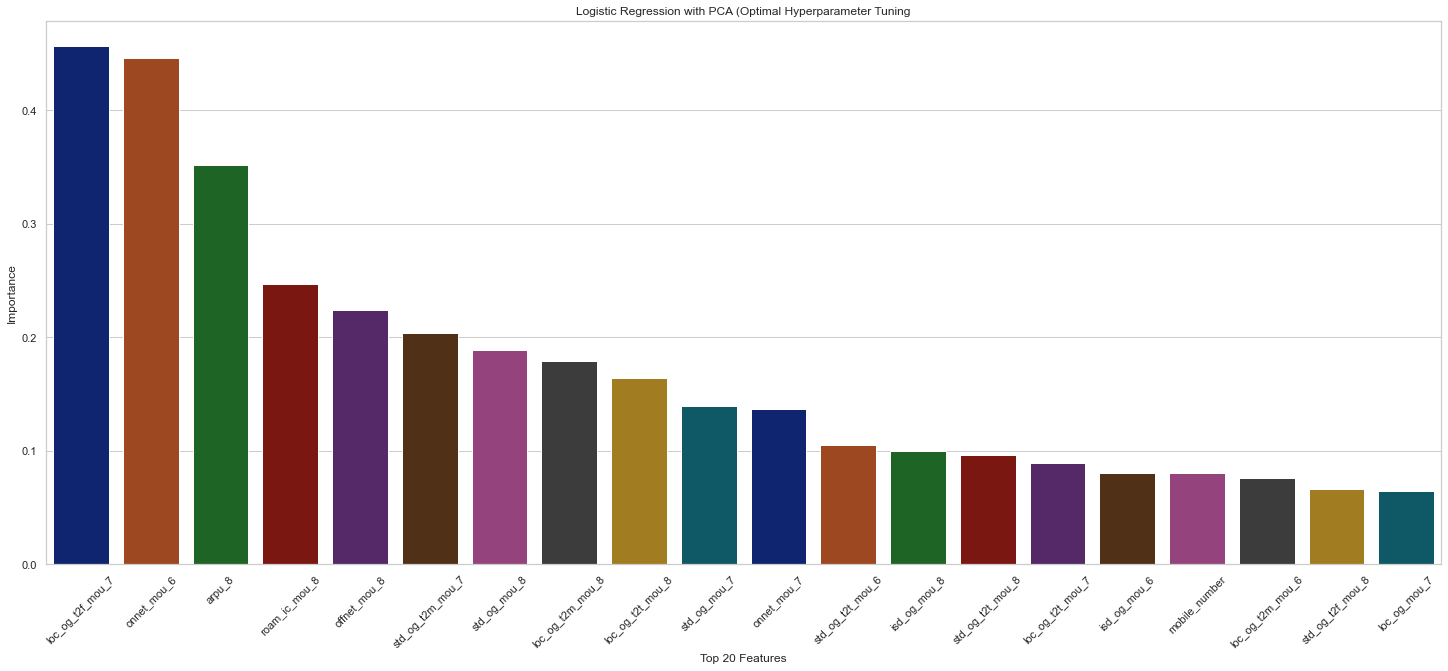

In [209]:
important_features(model.coef_[0], "Logistic Regression with PCA (Optimal Hyperparameter Tuning")

In [210]:
important_features_df(model.coef_[0])

Variable  importance
0   loc_og_t2f_mou_7  0.456199  
1   onnet_mou_6       0.445927  
2   arpu_8            0.351361  
3   roam_ic_mou_8     0.247047  
4   offnet_mou_8      0.223993  
5   std_og_t2m_mou_7  0.203339  
6   std_og_mou_8      0.189167  
7   loc_og_t2m_mou_8  0.178949  
8   loc_og_t2t_mou_8  0.163864  
9   std_og_mou_7      0.139242  
10  onnet_mou_7       0.136878  
11  std_og_t2t_mou_6  0.104868  
12  isd_og_mou_8      0.099318  
13  std_og_t2t_mou_8  0.095916  
14  loc_og_t2t_mou_7  0.089216  
15  isd_og_mou_6      0.080574  
16  mobile_number     0.080363  
17  loc_og_t2m_mou_6  0.075537  
18  std_og_t2f_mou_8  0.066297  
19  loc_og_mou_7      0.064805  
20  roam_og_mou_8     0.063501  
21  offnet_mou_6      0.030534  
22  onnet_mou_8       0.022571  
23  loc_og_t2c_mou_8  0.017904  
24  arpu_7            0.005968  
25  loc_og_t2t_mou_6 -0.001868  
26  spl_og_mou_7     -0.011033  
27  std_og_t2f_mou_6 -0.022057  
28  offnet_mou_7     -0.041250  
29  og_others_6      -0.056583  
30  std_og_t2m_mou_6 -0.056716  
31  std_og_mou_6     -0.063262  
32  loc_og_t2c_mou_6 -0.072849  
33  isd_og_mou_7     -0.087018  
34  std_og_t2t_mou_7 -0.088295  
35  loc_og_t2m_mou_7 -0.089305  
36  loc_og_t2c_mou_7 -0.121570  
37  loc_og_mou_8     -0.132321  
38  std_og_t2m_mou_8 -0.132485  
39  loc_og_t2f_mou_6 -0.150575  
40  std_og_t2f_mou_7 -0.160876  
41  loc_og_mou_6     -0.212333  
42  roam_og_mou_7    -0.222584  
43  roam_ic_mou_6    -0.226357  
44  roam_ic_mou_7    -0.283486  
45  spl_og_mou_6     -0.285417  
46  roam_og_mou_6    -0.319327  
47  loc_og_t2f_mou_8 -0.401005  
48  spl_og_mou_8     -0.408826  
49  arpu_6           -0.510275

## 8.6 Visualizing the best variables of Logistic Regression without PCA (Using RFE, P-values and VIF)


In [211]:
#printing the summary of the latest log reg model without pca
#9th model
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                19658
Model:                            GLM   Df Residuals:                    19645
Model Family:                Binomial   Df Model:                           12
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3925.5
Date:                Thu, 28 Apr 2022   Deviance:                       7851.0
Time:                        13:34:58   Pearson chi2:                 1.97e+05
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -3.9255      0.066    -59.648      0.000      -4.055      -3.797
onnet_mou_7            0.1652      0.039      4.275      0.000       0.089       0.241
onnet_mou_8           -0.2078      0.058     -3.607      0.000      -0.321      -0.095
offnet_mou_7           0.2428      0.036      6.702      0.000       0.172       0.314
std_og_t2m_mou_8      -0.2116      0.053     -4.001      0.000      -0.315      -0.108
loc_ic_mou_8          -1.9744      0.098    -20.066      0.000      -2.167      -1.782
std_ic_mou_8          -0.4618      0.074     -6.280      0.000      -0.606      -0.318
total_ic_mou_6         0.4750      0.044     10.888      0.000       0.389       0.561
spl_ic_mou_8          -0.3631      0.058     -6.284      0.000      -0.476      -0.250
total_rech_num_8      -0.7045      0.059    -11.926      0.000      -0.820      -0.589
last_day_rch_amt_8    -0.7754      0.061    -12.746      0.000      -0.895      -0.656
total_rech_data_8     -0.7363      0.078     -9.417      0.000      -0.890      -0.583
max_rech_data_8       -0.5656      0.056    -10.052      0.000      -0.676      -0.455
======================================================================================
"""

In [212]:
#manually inputting the names of the most important variables from the lastest model 
#of logistic regression along with their coefficients

names = ["onnet_mou_7", "onnet_mou_8", "offnet_mou_7", "std_og_t2m_mou_8", "loc_ic_mou_8", "std_ic_mou_8", "total_ic_mou_6", "spl_ic_mou_8", 
         "total_rech_num_8", "last_day_rch_amt_8", "total_rech_data_8", "max_rech_data_8"]

values = [0.1652, -0.2078, 0.2428, -0.2116, -1.9744, -0.4618, 0.4750, -0.3631, -0.7045, -0.7754, -0.7363, -0.5656]

final_df = pd.DataFrame({"Names": names, "Values": values})
final_df = final_df.sort_values(by = "Values", axis = 0, ascending = False)

final_df #displaying the variables from highest to lowest

Names  Values
6   total_ic_mou_6      0.4750
2   offnet_mou_7        0.2428
0   onnet_mou_7         0.1652
1   onnet_mou_8        -0.2078
3   std_og_t2m_mou_8   -0.2116
7   spl_ic_mou_8       -0.3631
5   std_ic_mou_8       -0.4618
11  max_rech_data_8    -0.5656
8   total_rech_num_8   -0.7045
10  total_rech_data_8  -0.7363
9   last_day_rch_amt_8 -0.7754
4   loc_ic_mou_8       -1.9744

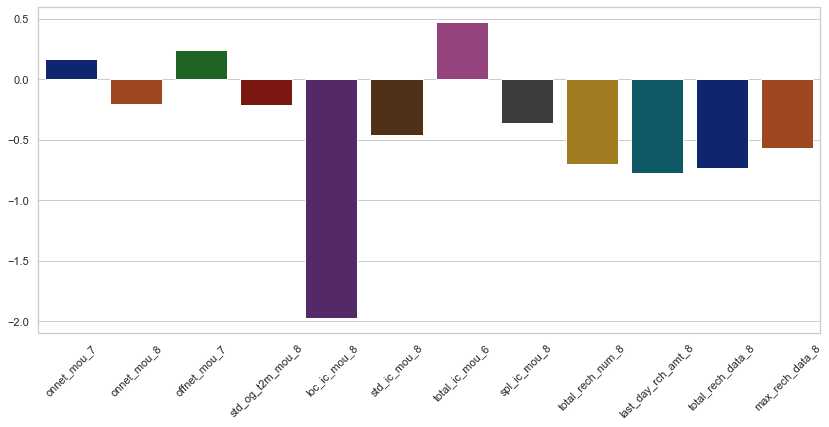

In [213]:
plt.figure(figsize = [14, 6])
sns.set_theme(style = "whitegrid")
sns.barplot(names, values, palette = "dark")
plt.xticks(rotation = 45)
plt.show()

# 9. Conclusions and Recommendations

So, we trained many models overall and found out their metrics for comparison which are shown below:

In [214]:
compare_dataframe

Accuracy  Precision  \
Log. Reg. (with PCA)                             0.836558  0.297343    
Log. Reg. with hyperparameter Tuning (with PCA)  0.814243  0.273410    
Log. Reg. without PCA (RFE, P-values & VIF)      0.917507  0.474527    
Random Forest (with PCA)                         0.871098  0.340807    
XGBoost (with PCA)                               0.905045  0.415663    
Decision Tree (with PCA)                         0.800593  0.340807    

                                                   Recall  Sensitivity  \
Log. Reg. (with PCA)                             0.796970  0.796970      
Log. Reg. with hyperparameter Tuning (with PCA)  0.827273  0.827273      
Log. Reg. without PCA (RFE, P-values & VIF)      0.493939  0.493939      
Random Forest (with PCA)                         0.690909  0.690909      
XGBoost (with PCA)                               0.522727  0.522727      
Decision Tree (with PCA)                         0.971215  0.690909      

                                                 Specificity  roc_auc_score  
Log. Reg. (with PCA)                             0.839923     0.818446       
Log. Reg. with hyperparameter Tuning (with PCA)  0.813136     0.820204       
Log. Reg. without PCA (RFE, P-values & VIF)      0.953509     0.723724       
Random Forest (with PCA)                         0.886413     0.788661       
XGBoost (with PCA)                               0.937540     0.730134       
Decision Tree (with PCA)                         0.886413     0.741401

### CONCLUSION:

We can see based on **accuracy** of the models that **Logistic Regression without PCA (RFE, P-values and VIF)** is the best model. In this case, the Logistic Regression without PCA (RFE, P-values and VIF) model is the most interpretable of all models but, judging a model by accuracy alone is not the best measure. 

Therefore, based on **ROC AUC score**, which tells us how much a model is capable of distinguishing between classes (A high ROC AUC score is desirable), we have the **logistic regression model with hyperparamter tuning (with PCA)** as the best possible model.

### Recommendations:

**Making recommendations based on the most interpretable model (Logistic Regression without PCA (Using RFE, P-values and VIF)):**

After arranging all the features in a descending order, we see the following features have the biggest correlation with customer churn (either positively or negatively):

**Variables that positively influence churn (positive coefficient):**

**total_ic_mou_6:** This variable tells us the total incoming calls minutes of usage in the 6th month (June). After performing Exploratory Data Analysis, we noticed that the minutes of usage in June is the highest for both the churned and non-churned customers (thought it gradually starts to decrease as the months go on for the churned customers).

So this variable is a great indicator of the behaviour of the customers and can be used to predict if they are going to churn or not. 

**offnet_mou_7:** This variable indicates the minutes of usage of calls of the customer outside their operator's network in the 7th month (July). By performing EDA and noticing the trend, it's hard to see a clear pattern to identify the behaviour of the customers (if they are going to churn or not). In the 7th month, we can notice the minutes of usage for both the set of customers (non-churned and churned) to be almost the same. 

If we go back a previous month of the same feature, we can notice the minutes of usage of the churned customers is around the same as the 7th month but, for the non-churned customers it is much less.

There is a sever reduction in the usage in the action phase, therefore this feature needs to be considered by the client for predicting the customer behaviour (The customers whose minutes of usage shows an increase are more likely to stay).

**onnet_mou_7:** This variable indicates the minutes of usage of calls of the customer inside their operator's network in the 7th month (July). During the good phase (i.e., during the 6th and 7th month), the churned customers' usage is constant and is noticeably more than the non-churned customers' usage. 

This feature also can help the client in predicting which customers can be retained. The customers whose minutes of usage shows an increase are more likely to stay.

**Variables that negatively influence churn (negative coefficient):**

**loc_ic_mou_8:** This variable explains about the local incoming calls within the same telecom circle in the month 8 (August). After performing EDA, in the month 8, it can be very clearly seen that this feature is not at all popular with the churned customers. In other words, customers who churned in our analysis, received very few incoming calls in the action phase. If we look at the previous months of this same feature, the incoming calls were always lower  compared to the non-churned customers. This indicates, or could indicate, that the churned customers started using a different number to receive incoming calls and may have already churned or decided to churn.

As can be seen from the visualiztion graph of the most important variables, loc_ic_mou_8 is a huge negatively influencing variable, which means investing too late in this area will most likely lead to loss (as the customer has most likely made up their minds to churn or has already churned).

**last_day_rch_amt_8**: This variable explains the recharge done by the customer in the last day of the month, in this case it's month 8 (August). After performing EDA, it can be seen very easily that the churned customers make very few recharges compared to the non-churned customers. The reason is very clear, as the customer has already decided to churn, they have no reason to recharge their number and continue using the operator's service to which they do not want to stay with. 

Therefore, investing in this feature in the month 8 may not yield any positive results as the customer has most likely made up their minds to churn.

**total_rech_data_8**: This variable explains the total recharge done to their internet services (data) in the month 8. As can be seen from the EDA performed, for churned customers, the recharge is very low compared to the non-churned customers (in month 8). Similar to the feature (and reasons) above, investing in retaining customers in this month may prove futile as they have already churned or have decided to churn.

**total_rech_num_8:** This variable explains the total recharge to their number in the month 8. As can be seen after performing EDA, in the month 8 (compared to the previous months), there is a severe reduction in the recharge done by the customer. This very likely indicates that the customer has already churned or has decided to churn.

